<a href="https://colab.research.google.com/github/yingzibu/MOL2ADMET/blob/main/examples/Ensemble/ensemble_T3_2024_01_24.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print(torch.__version__)
print('cuda: ', torch.cuda.is_available())

2.1.0+cu121
cuda:  True


In [2]:
! pip install rdkit --quiet
! pip install PyTDC --quiet
! pip install mycolorpy --quiet
! pip install selfies  --quiet
! pip install pubchempy --quiet
! pip install dgllife --quiet
! pip install molvs --quiet
! pip install dgl -f https://data.dgl.ai/wheels/cu121/repo.html --quiet
! pip install dglgo -f https://data.dgl.ai/wheels-test/repo.html --quiet
! pip install DeepPurpose --quiet
! pip install git+https://github.com/bp-kelley/descriptastorus --quiet
! pip install pandas-flavor --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 42.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 44.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.0/926.0 MB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
cd /content/drive/MyDrive/ADMET

/content/drive/MyDrive/ADMET


In [ ]:
from scripts.func_utils import make_path, convert_with_qed_sa, get_min, \
                                plot_loss, plot_performance

from scripts.eval_utils import *
from scripts.preprocess_mols import *
from scripts.model_architecture import *
from scripts.dataset import *
from scripts.train import *
import yaml
import pandas as pd
from scripts.get_vocab import *

from tdc.single_pred import ADME
from tdc.single_pred import Tox
from scripts.CONSTANT import *
from scripts.yaml_utils import *

print('VOCAB TYPE:', VOCAB_TYPE)

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
VOCAB TYPE: smiles


In [ ]:
model_types

['MLP', 'AttentiveFP', 'GIN', 'RNN', 'VAE', 'RNN_pretrain']

In [ ]:
a = tst.columns.tolist()
a

['Drug', 'LD50_Zhu', 'hERG_Karim', 'AMES']

In [ ]:
a.remove('Drug')
a

['LD50_Zhu', 'hERG_Karim', 'AMES']

In [ ]:
def process_ensemble(tst, model_types=['MLP', 'AttentiveFP', 'GIN', 'RNN'],
                     folder_name='T3/uw'):
    task_names = tst.columns.tolist()
    # print('col names', col_names)
    task_names.remove('Drug')
    print('task names',task_names)
    df_list = []
    for i in range(len(task_names)):
        # print(i, M5[i])

        # append true labels into df_list
        temp_df = pd.DataFrame()
        temp_df['Drug'] = tst['Drug'].tolist()
        temp_df[task_names[i]] = tst[task_names[i]].tolist()
        df_list.append(temp_df)

    for model_type in model_types:
        file_name = f'{folder_name}/{model_type}_MT_1.yml'
        with open(file_name, 'r') as f: yml_data = yaml.safe_load(f)
        models = PRED(**yml_data['config'])
        models.load_status(yml_data)

        df = models.predict(tst['Drug'].tolist(), return_probs=True)
        for j in range(len(task_names)):
            df_list[j][model_type] = df[task_names[j]].tolist()
    return df_list

In [ ]:
T3 = ['LD50_Zhu', 'hERG_Karim', 'AMES']
trn, val, tst = collect_data(T3)

trn_list = process_ensemble(trn)
val_list = process_ensemble(val)
tst_list = process_ensemble(tst)

Found local copy...
Loading...


collect data for:  ['LD50_Zhu', 'hERG_Karim', 'AMES']


Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

class ensemble_dataset(Dataset):
    def __init__(self, df, task_name, mask=MASK,
                 header=['MLP', 'AttentiveFP', 'GIN', 'RNN']):
        super(ensemble_dataset, self).__init__()

        self.df = df.copy().fillna(mask)
        self.len = len(df)
        self.fp = self.df[header]
        self.props = self.df[[task_name]]
    def __len__(self): return self.len
    def __getitem__(self, idx):
        fp = torch.tensor(self.fp.iloc[idx], dtype=torch.float32)
        label = torch.tensor(self.props.iloc[idx], dtype=torch.float32)
        return fp, label


In [ ]:
batch_size = 64
params_ = {'batch_size': batch_size, 'shuffle': True,
               'drop_last': False, 'num_workers': 0}

param_t = {'batch_size': batch_size, 'shuffle': False,
               'drop_last': False, 'num_workers': 0}

task_num = 0

trn_l = DataLoader(ensemble_dataset(trn_list[task_num], T3[task_num]), **params_)
val_l = DataLoader(ensemble_dataset(val_list[task_num], T3[task_num]), **params_)
tst_l = DataLoader(ensemble_dataset(tst_list[task_num], T3[task_num]), **param_t)

In [ ]:
config_ensemble = {
    'in_dim': len(['MLP', 'AttentiveFP', 'GIN', 'RNN']),
    'out_dim': 1,
    'hid_dims': [64, 32, 16],
    'dropout': 0.1,
    'model_type': 'MLP',
    'prop_names': [T3[task_num]],
    'IS_R': names_dict[T3[task_num]],
    'batch_size': 64,
    'lr': 5e-5,
    'wd': 1e-5,
    'patience': 10,
    'verbose_freq': 20,
    'model_path': f'ckpt_ensemble_T3.pt',
    'weight_loss': [1.0],
    'uncertainty_weight': False,
    'scale_dict': None}
# model_ensemble = Classifier(**config_ensemble).to('cuda')
models = PRED(**config_ensemble)

Model type:  MLP | Model parameters:  2945


Start training MLP...
Epoch:0 [Train] Loss: 7.794 | [Valid] Loss: 7.192	SAVE MODEL: loss: inf -> 7.192 | runtime: 0.170 ms
Epoch:1 [Train] Loss: 5.907 | [Valid] Loss: 5.001	SAVE MODEL: loss: 7.192 -> 5.001 | runtime: 0.139 ms
Epoch:2 [Train] Loss: 3.251 | [Valid] Loss: 1.970	SAVE MODEL: loss: 5.001 -> 1.970 | runtime: 0.144 ms
Epoch:3 [Train] Loss: 0.980 | [Valid] Loss: 0.460	SAVE MODEL: loss: 1.970 -> 0.460 | runtime: 0.140 ms
Epoch:4 [Train] Loss: 0.542 | [Valid] Loss: 0.356	SAVE MODEL: loss: 0.460 -> 0.356 | runtime: 0.139 ms
Epoch:5 [Train] Loss: 0.432 | [Valid] Loss: 0.370	EarlyStopping counter: 1 out of 10
Epoch:6 [Train] Loss: 0.474 | [Valid] Loss: 0.357	EarlyStopping counter: 2 out of 10
Epoch:7 [Train] Loss: 0.431 | [Valid] Loss: 0.346	SAVE MODEL: loss: 0.356 -> 0.346 | runtime: 0.139 ms
Epoch:8 [Train] Loss: 0.409 | [Valid] Loss: 0.355	EarlyStopping counter: 1 out of 10
Epoch:9 [Train] Loss: 0.404 | [Valid] Loss: 0.352	EarlyStopping counter: 2 out of 10
Epoch:10 [Train] Loss:

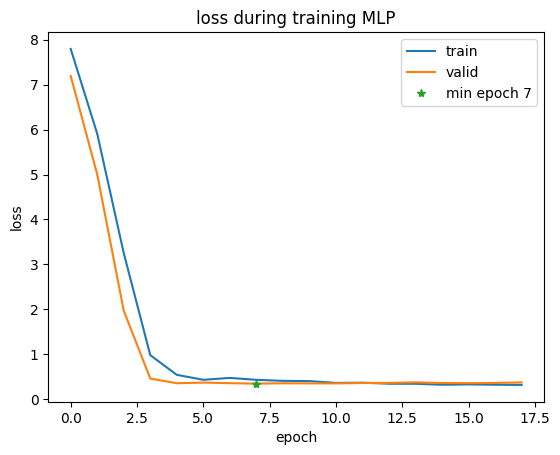

load pretrained model from  ckpt_ensemble_T3.pt
[Test] Loss: 0.088
*************** LD50_Zhu ***************
  MAE     MSE     RMSE    R2
&0.412  &0.317  &0.563  &0.645


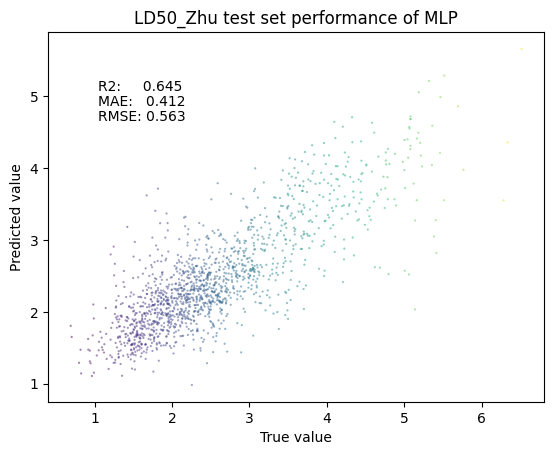



--> Train status saved at ckpt_ensemble_T3.yml
Finished evaluate test performance, outputs performance dict


{'LD50_Zhu': [0.4121086549419927,
  0.3173470647159338,
  0.5633356590132865,
  0.6447905126598992],
 'loss': 0.0881893742701103}

In [ ]:
models.train(trn_l, val_l, tst_l)

Model type:  MLP | Model parameters:  2945
Start training MLP...
Epoch:0 [Train] Loss: 0.688 | [Valid] Loss: 0.681	SAVE MODEL: loss: inf -> 0.681 | runtime: 0.147 ms
Epoch:1 [Train] Loss: 0.652 | [Valid] Loss: 0.638	SAVE MODEL: loss: 0.681 -> 0.638 | runtime: 0.143 ms
Epoch:2 [Train] Loss: 0.578 | [Valid] Loss: 0.569	SAVE MODEL: loss: 0.638 -> 0.569 | runtime: 0.143 ms
Epoch:3 [Train] Loss: 0.472 | [Valid] Loss: 0.486	SAVE MODEL: loss: 0.569 -> 0.486 | runtime: 0.144 ms
Epoch:4 [Train] Loss: 0.360 | [Valid] Loss: 0.425	SAVE MODEL: loss: 0.486 -> 0.425 | runtime: 0.145 ms
Epoch:5 [Train] Loss: 0.279 | [Valid] Loss: 0.405	SAVE MODEL: loss: 0.425 -> 0.405 | runtime: 0.142 ms
Epoch:6 [Train] Loss: 0.235 | [Valid] Loss: 0.415	EarlyStopping counter: 1 out of 10
Epoch:7 [Train] Loss: 0.216 | [Valid] Loss: 0.425	EarlyStopping counter: 2 out of 10
Epoch:8 [Train] Loss: 0.205 | [Valid] Loss: 0.446	EarlyStopping counter: 3 out of 10
Epoch:9 [Train] Loss: 0.199 | [Valid] Loss: 0.458	EarlyStopping 

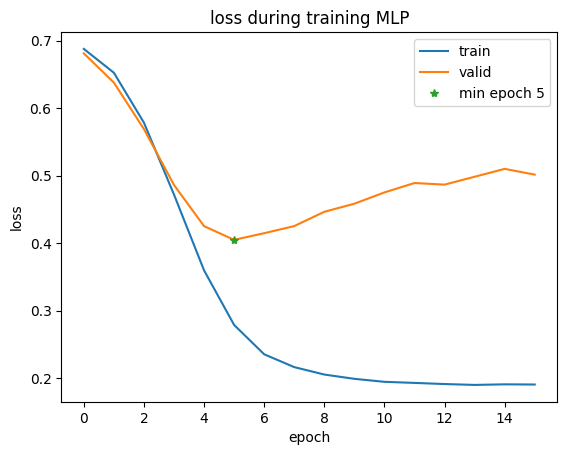

load pretrained model from  ckpt_ensemble_T3.pt
[Test] Loss: 0.218
*************** hERG_Karim ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.818  &0.818  &0.815  &0.821  &0.814  &0.818 &0.896 &0.636 &0.901


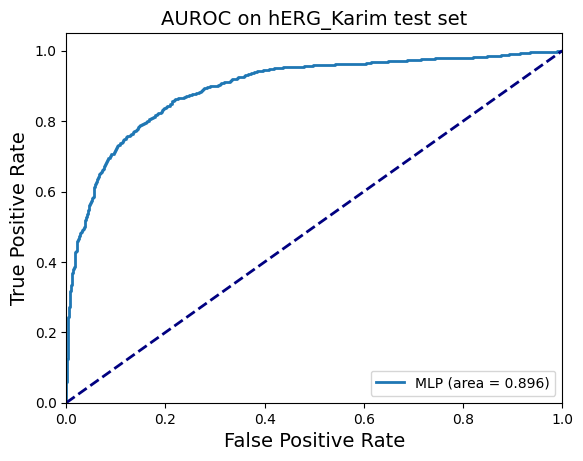

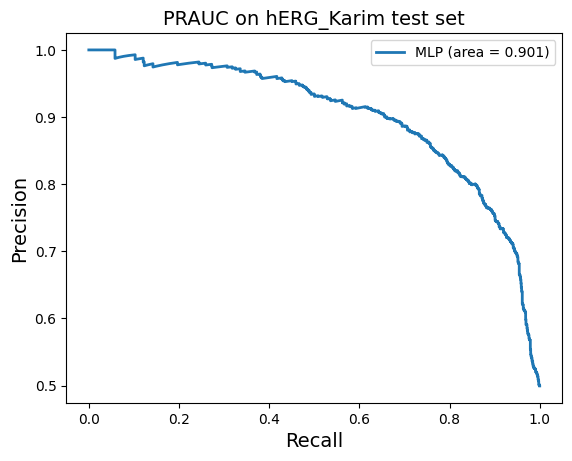



--> Train status saved at ckpt_ensemble_T3.yml
Finished evaluate test performance, outputs performance dict


{'hERG_Karim': [0.8177761249535144,
  0.8177800471101602,
  0.8152254249815225,
  0.8212956068503351,
  0.8142644873699851,
  0.8182492581602374,
  0.8963266687983148,
  0.6355724002003476,
  0.9009879197158386],
 'loss': 0.21823873739132935}

In [ ]:
task_num = 1

trn_l = DataLoader(ensemble_dataset(trn_list[task_num], T3[task_num]), **params_)
val_l = DataLoader(ensemble_dataset(val_list[task_num], T3[task_num]), **params_)
tst_l = DataLoader(ensemble_dataset(tst_list[task_num], T3[task_num]), **param_t)

config_ensemble = {
    'in_dim': len(['MLP', 'AttentiveFP', 'GIN', 'RNN']),
    'out_dim': 1,
    'hid_dims': [64, 32, 16],
    'dropout': 0.1,
    'model_type': 'MLP',
    'prop_names': [T3[task_num]],
    'IS_R': names_dict[T3[task_num]],
    'batch_size': 64,
    'lr': 5e-5,
    'wd': 1e-5,
    'patience': 10,
    'verbose_freq': 20,
    'model_path': f'ckpt_ensemble_T3.pt',
    'weight_loss': [1.0],
    'uncertainty_weight': False,
    'scale_dict': None}
# model_ensemble = Classifier(**config_ensemble).to('cuda')
models = PRED(**config_ensemble)
models.train(trn_l, val_l, tst_l)

In [ ]:
task_num = 2

trn_l = DataLoader(ensemble_dataset(trn_list[task_num], T3[task_num]), **params_)
val_l = DataLoader(ensemble_dataset(val_list[task_num], T3[task_num]), **params_)
tst_l = DataLoader(ensemble_dataset(tst_list[task_num], T3[task_num]), **param_t)

config_ensemble = {
    'in_dim': len(['MLP', 'AttentiveFP', 'GIN', 'RNN']),
    'out_dim': 1,
    'hid_dims': [64, 32, 16],
    'dropout': 0.1,
    'model_type': 'MLP',
    'prop_names': [T3[task_num]],
    'IS_R': names_dict[T3[task_num]],
    'batch_size': 64,
    'lr': 5e-5,
    'wd': 1e-5,
    'patience': 10,
    'verbose_freq': 20,
    'model_path': f'ckpt_ensemble_T3.pt',
    'weight_loss': [1.0],
    'uncertainty_weight': False,
    'scale_dict': None}
# model_ensemble = Classifier(**config_ensemble).to('cuda')
models = PRED(**config_ensemble)
# models.train(trn_l, val_l, tst_l)

Model type:  MLP | Model parameters:  2945


Start training MLP...
Epoch:0 [Train] Loss: 0.681 | [Valid] Loss: 0.673	SAVE MODEL: loss: inf -> 0.673 | runtime: 0.143 ms
Epoch:1 [Train] Loss: 0.650 | [Valid] Loss: 0.639	SAVE MODEL: loss: 0.673 -> 0.639 | runtime: 0.144 ms
Epoch:2 [Train] Loss: 0.582 | [Valid] Loss: 0.571	SAVE MODEL: loss: 0.639 -> 0.571 | runtime: 0.141 ms
Epoch:3 [Train] Loss: 0.475 | [Valid] Loss: 0.492	SAVE MODEL: loss: 0.571 -> 0.492 | runtime: 0.151 ms
Epoch:4 [Train] Loss: 0.357 | [Valid] Loss: 0.422	SAVE MODEL: loss: 0.492 -> 0.422 | runtime: 0.143 ms
Epoch:5 [Train] Loss: 0.269 | [Valid] Loss: 0.397	SAVE MODEL: loss: 0.422 -> 0.397 | runtime: 0.145 ms
Epoch:6 [Train] Loss: 0.219 | [Valid] Loss: 0.408	EarlyStopping counter: 1 out of 10
Epoch:7 [Train] Loss: 0.190 | [Valid] Loss: 0.417	EarlyStopping counter: 2 out of 10
Epoch:8 [Train] Loss: 0.178 | [Valid] Loss: 0.427	EarlyStopping counter: 3 out of 10
Epoch:9 [Train] Loss: 0.170 | [Valid] Loss: 0.422	EarlyStopping counter: 4 out of 10
Epoch:10 [Train] Loss:

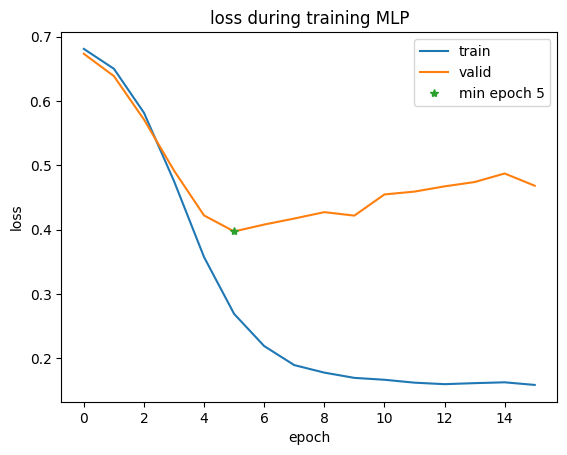

load pretrained model from  ckpt_ensemble_T3.pt
[Test] Loss: 0.234
*************** AMES ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.841  &0.840  &0.859  &0.850  &0.831  &0.854 &0.910 &0.680 &0.921


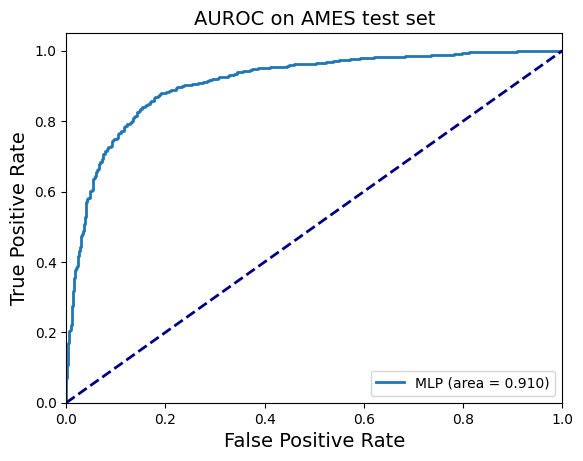

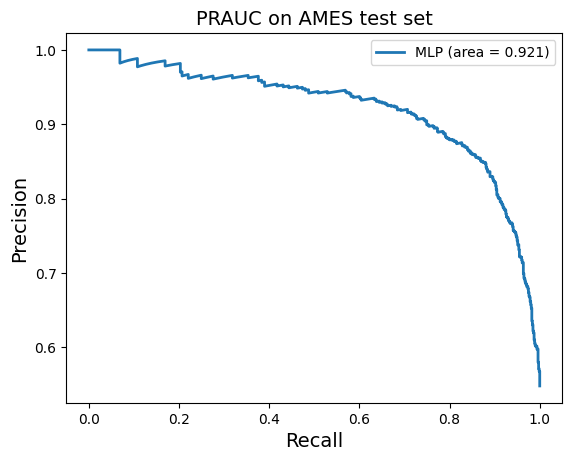



--> Train status saved at ckpt_ensemble_T3.yml
Finished evaluate test performance, outputs performance dict


{'AMES': [0.8413461538461539,
  0.8404655255159175,
  0.8593155893536122,
  0.849624060150376,
  0.831306990881459,
  0.8544423440453686,
  0.9103610089052419,
  0.6801678700209782,
  0.9207769270080298],
 'loss': 0.23411905131805902}

In [ ]:
models.train(trn_l, val_l, tst_l)

In [ ]:
names_dict

{'Caco2_Wang': True,
 'Lipophilicity_AstraZeneca': True,
 'HydrationFreeEnergy_FreeSolv': True,
 'Solubility_AqSolDB': True,
 'LD50_Zhu': True,
 'Kp': True,
 'CYP2C19_Veith': False,
 'CYP2D6_Veith': False,
 'CYP3A4_Veith': False,
 'CYP1A2_Veith': False,
 'CYP2C9_Veith': False,
 'BBB_Martins': False,
 'Bioavailability_Ma': False,
 'Pgp_Broccatelli': False,
 'HIA_Hou': False,
 'PAMPA_NCATS': False,
 'hERG_Karim': False,
 'AMES': False,
 'qed': True,
 'sa': True}

In [ ]:
A3 = ['Lipophilicity_AstraZeneca', 'Solubility_AqSolDB', 'PAMPA_NCATS']
model_types = ['MLP', 'AttentiveFP', 'GIN', 'RNN']

path: A3/uw is created


Found local copy...
Loading...



Run # 0 for MLP MT	 | save dir:  A3/uw/MLP_MT_0 | 	cannot open A3/uw/MLP_MT_0.yml, retrain
collect data for:  ['Lipophilicity_AstraZeneca', 'Solubility_AqSolDB', 'PAMPA_NCATS']


Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!



START scaling train valid test data set: 
---> scale Lipophilicity_AstraZeneca | min -1.500 | max 4.500

START scaling train valid test data set: 
---> scale Solubility_AqSolDB | min -13.172 | max 2.138
Finished scaling process | dict_scale: {'Lipophilicity_AstraZeneca': [-1.5, 4.5], 'Solubility_AqSolDB': [-13.1719, 2.1376816201]} 

---> loader for ['Lipophilicity_AstraZeneca', 'Solubility_AqSolDB', 'PAMPA_NCATS']
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
--> preparing data loader for model type  MLP
---> converting SMILES to MACCS...
---> FINISHED
Model type:  MLP | Model parameters:  32419
Start training MLP...
Epoch:0 [Train] Loss: 0.488 | [Valid] Loss: 0.483	SAVE MODEL: loss: inf -> 0.483 | runtime: 0.194 ms
Epoch:1 [Train] Loss: 0.403 | [Valid] Loss: 0.160	SAVE MODEL: loss: 0.483 -> 0.160 | runtime: 0.193 ms
Epoch:2 [Train] Loss: 0.15

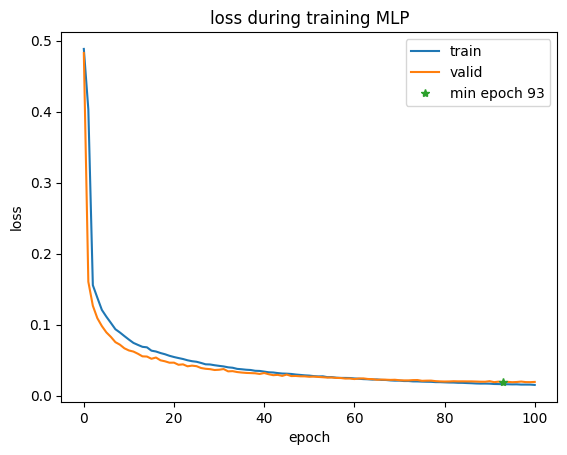

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.669  &0.757  &0.870  &0.473

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&1.005  &1.882  &1.372  &0.645

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.837  &0.500  &0.837  &1.000  &0.000  &0.912 &0.744 &  nan &0.924

Epoch:101 [Train] Loss: 0.015 | [Valid] Loss: 0.019	EarlyStopping counter: 8 out of 30
Epoch:102 [Train] Loss: 0.015 | [Valid] Loss: 0.019	EarlyStopping counter: 9 out of 30
Epoch:103 [Train] Loss: 0.015 | [Valid] Loss: 0.019	SAVE MODEL: loss: 0.019 -> 0.019 | runtime: 0.175 ms
Epoch:104 [Train] Loss: 0.015 | [Valid] Loss: 0.019	EarlyStopping counter: 1 out of 30
Epoch:105 [Train] Loss: 0.015 | [Valid] Loss: 0.019	EarlyStopping counter: 2 out of 30
Epoch:106 [Train] Loss: 0.014 | [Valid] Loss: 0.019	EarlyStopping counter: 3 out of 30
Epoch:107 [Train] Loss: 0.014 | [Valid] Loss: 0.01

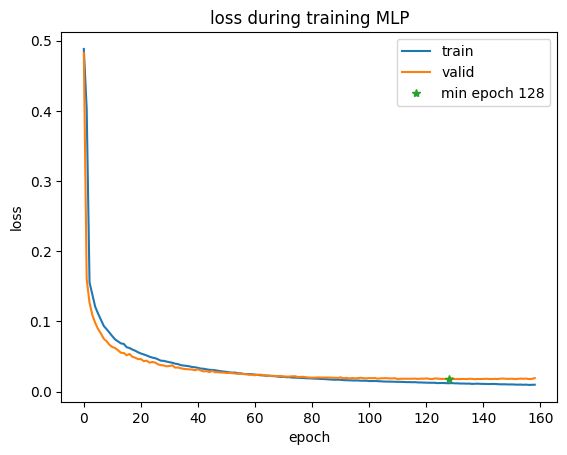

load pretrained model from  A3/uw/MLP_MT_0.pt
[Test] Loss: 0.023
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.661  &0.739  &0.860  &0.500


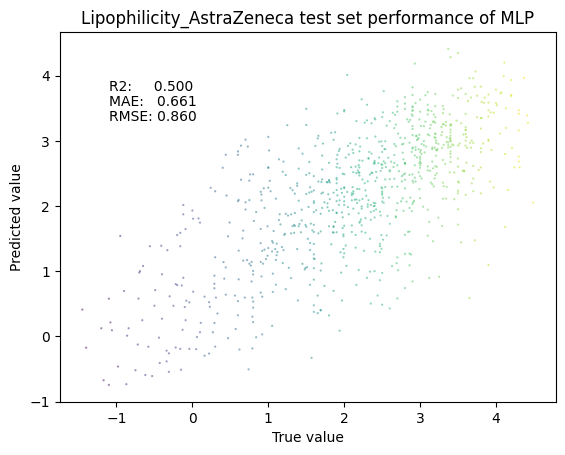


*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.982  &1.758  &1.326  &0.676


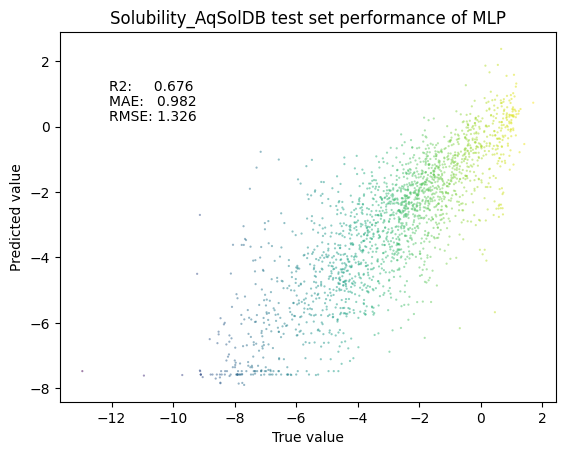


*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.845  &0.500  &0.845  &1.000  &0.000  &0.916 &0.785 &  nan &0.945


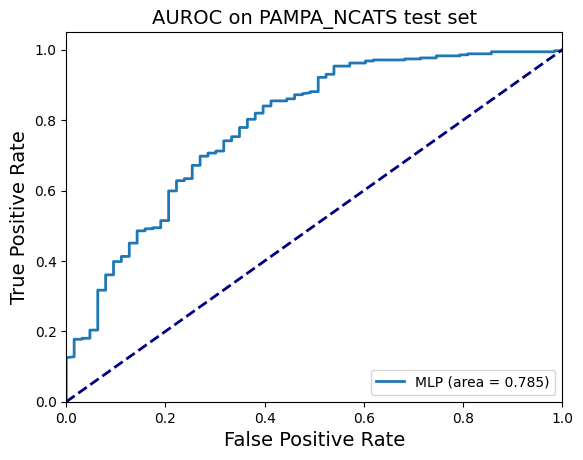

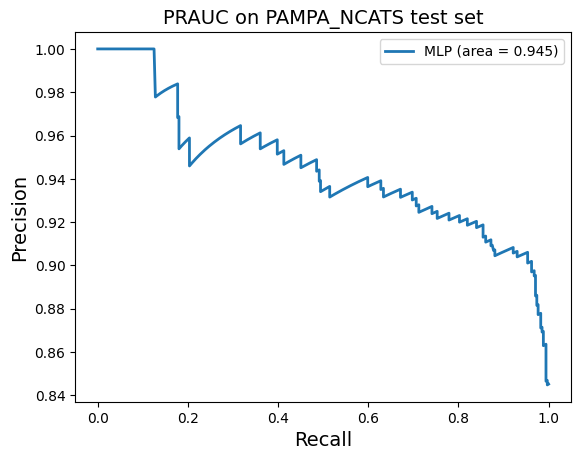



--> Train status saved at A3/uw/MLP_MT_0.yml
Finished evaluate test performance, outputs performance dict

Run # 1 for MLP MT	 | save dir:  A3/uw/MLP_MT_1 | 	cannot open A3/uw/MLP_MT_1.yml, retrain
Model type:  MLP | Model parameters:  32419
Start training MLP...
Epoch:0 [Train] Loss: 0.402 | [Valid] Loss: 0.426	SAVE MODEL: loss: inf -> 0.426 | runtime: 0.177 ms
Epoch:1 [Train] Loss: 0.367 | [Valid] Loss: 0.126	SAVE MODEL: loss: 0.426 -> 0.126 | runtime: 0.171 ms
Epoch:2 [Train] Loss: 0.131 | [Valid] Loss: 0.102	SAVE MODEL: loss: 0.126 -> 0.102 | runtime: 0.169 ms
Epoch:3 [Train] Loss: 0.112 | [Valid] Loss: 0.093	SAVE MODEL: loss: 0.102 -> 0.093 | runtime: 0.178 ms
Epoch:4 [Train] Loss: 0.101 | [Valid] Loss: 0.082	SAVE MODEL: loss: 0.093 -> 0.082 | runtime: 0.173 ms
Epoch:5 [Train] Loss: 0.091 | [Valid] Loss: 0.074	SAVE MODEL: loss: 0.082 -> 0.074 | runtime: 0.179 ms
Epoch:6 [Train] Loss: 0.083 | [Valid] Loss: 0.071	SAVE MODEL: loss: 0.074 -> 0.071 | runtime: 0.180 ms
Epoch:7 [Train]

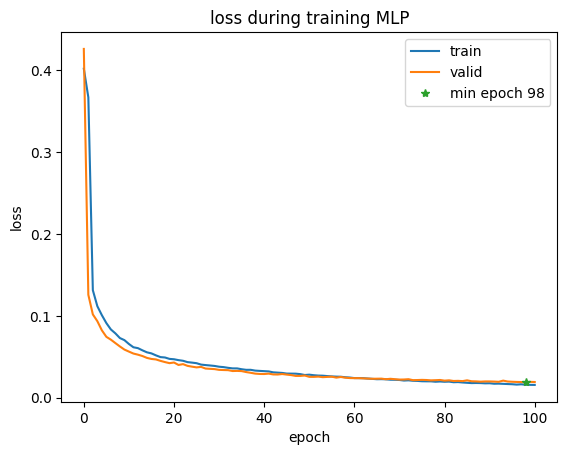

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.646  &0.705  &0.840  &0.509

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.994  &1.833  &1.354  &0.655

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.837  &0.500  &0.837  &1.000  &0.000  &0.912 &0.754 &  nan &0.924

Epoch:101 [Train] Loss: 0.015 | [Valid] Loss: 0.019	EarlyStopping counter: 3 out of 30
Epoch:102 [Train] Loss: 0.015 | [Valid] Loss: 0.019	EarlyStopping counter: 4 out of 30
Epoch:103 [Train] Loss: 0.015 | [Valid] Loss: 0.019	EarlyStopping counter: 5 out of 30
Epoch:104 [Train] Loss: 0.015 | [Valid] Loss: 0.019	EarlyStopping counter: 6 out of 30
Epoch:105 [Train] Loss: 0.015 | [Valid] Loss: 0.019	EarlyStopping counter: 7 out of 30
Epoch:106 [Train] Loss: 0.014 | [Valid] Loss: 0.019	EarlyStopping counter: 8 out of 30
Epoch:107 [Train] Loss: 0.014 | [Valid] Loss: 0.018	SAVE MODEL: loss

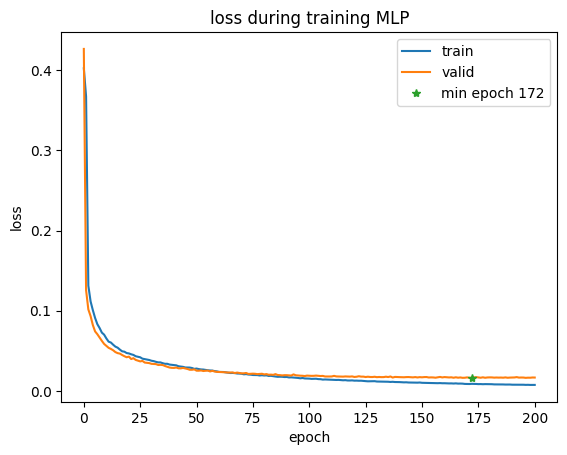

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.671  &0.768  &0.877  &0.465

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.959  &1.820  &1.349  &0.657

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.837  &0.500  &0.837  &1.000  &0.000  &0.912 &0.762 &  nan &0.930

Epoch:201 [Train] Loss: 0.008 | [Valid] Loss: 0.017	EarlyStopping counter: 29 out of 30
Epoch:202 [Train] Loss: 0.008 | [Valid] Loss: 0.017	EarlyStopping counter: 30 out of 30
early stop
Finished training


--> Train status saved at A3/uw/MLP_MT_1.yml
task weight ['0.437', '0.555', '0.008']
Model parameters:  32419
Train time: 0.176+/-0.004 ms
best epoch: 172, min loss: 0.0164


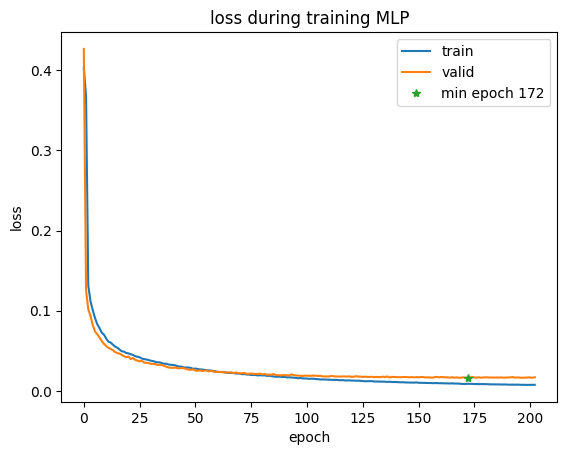

load pretrained model from  A3/uw/MLP_MT_1.pt
[Test] Loss: 0.023
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.669  &0.779  &0.883  &0.472


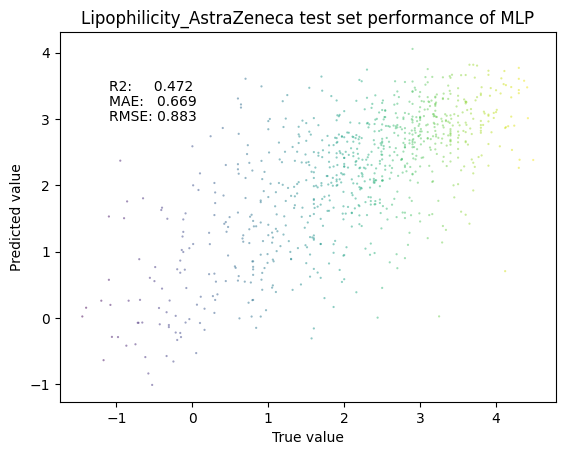


*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.974  &1.719  &1.311  &0.683


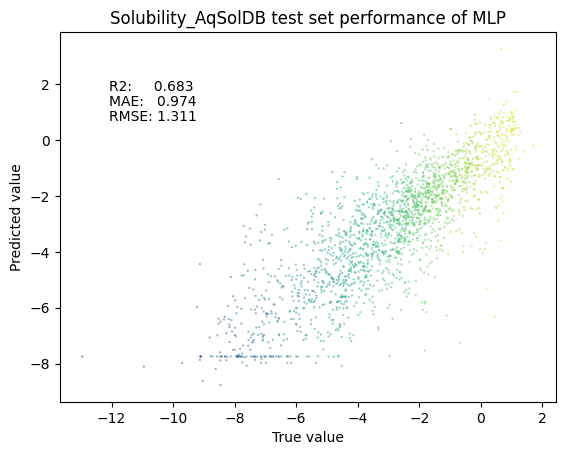


*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.845  &0.500  &0.845  &1.000  &0.000  &0.916 &0.785 &  nan &0.945


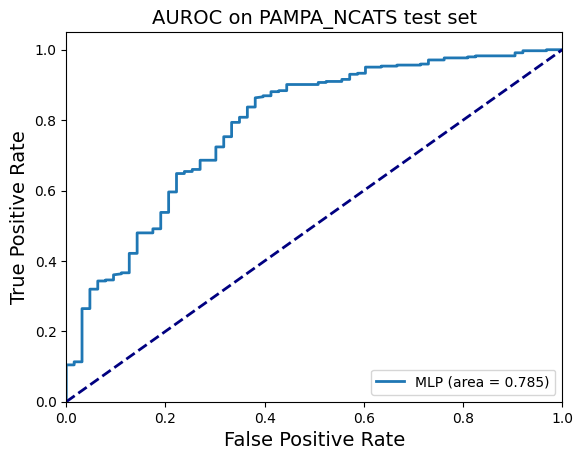

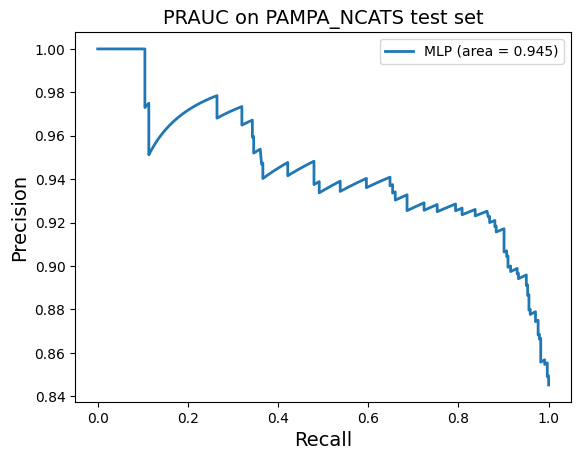



--> Train status saved at A3/uw/MLP_MT_1.yml
Finished evaluate test performance, outputs performance dict

Run # 2 for MLP MT	 | save dir:  A3/uw/MLP_MT_2 | 	cannot open A3/uw/MLP_MT_2.yml, retrain
Model type:  MLP | Model parameters:  32419
Start training MLP...
Epoch:0 [Train] Loss: 0.532 | [Valid] Loss: 0.490	SAVE MODEL: loss: inf -> 0.490 | runtime: 0.179 ms
Epoch:1 [Train] Loss: 0.392 | [Valid] Loss: 0.160	SAVE MODEL: loss: 0.490 -> 0.160 | runtime: 0.172 ms
Epoch:2 [Train] Loss: 0.157 | [Valid] Loss: 0.127	SAVE MODEL: loss: 0.160 -> 0.127 | runtime: 0.174 ms
Epoch:3 [Train] Loss: 0.137 | [Valid] Loss: 0.114	SAVE MODEL: loss: 0.127 -> 0.114 | runtime: 0.179 ms
Epoch:4 [Train] Loss: 0.126 | [Valid] Loss: 0.103	SAVE MODEL: loss: 0.114 -> 0.103 | runtime: 0.174 ms
Epoch:5 [Train] Loss: 0.115 | [Valid] Loss: 0.095	SAVE MODEL: loss: 0.103 -> 0.095 | runtime: 0.175 ms
Epoch:6 [Train] Loss: 0.106 | [Valid] Loss: 0.089	SAVE MODEL: loss: 0.095 -> 0.089 | runtime: 0.174 ms
Epoch:7 [Train]

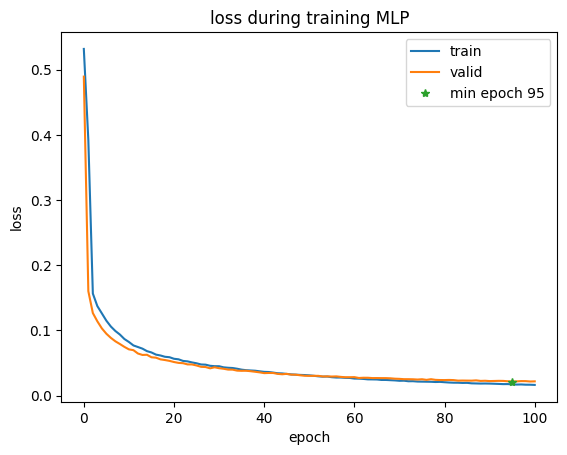

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.684  &0.781  &0.884  &0.457

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&1.030  &1.925  &1.387  &0.637

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.837  &0.500  &0.837  &1.000  &0.000  &0.912 &0.763 &  nan &0.927

Epoch:101 [Train] Loss: 0.016 | [Valid] Loss: 0.022	EarlyStopping counter: 6 out of 30
Epoch:102 [Train] Loss: 0.016 | [Valid] Loss: 0.021	SAVE MODEL: loss: 0.022 -> 0.021 | runtime: 0.170 ms
Epoch:103 [Train] Loss: 0.016 | [Valid] Loss: 0.022	EarlyStopping counter: 1 out of 30
Epoch:104 [Train] Loss: 0.016 | [Valid] Loss: 0.021	SAVE MODEL: loss: 0.021 -> 0.021 | runtime: 0.171 ms
Epoch:105 [Train] Loss: 0.016 | [Valid] Loss: 0.022	EarlyStopping counter: 1 out of 30
Epoch:106 [Train] Loss: 0.016 | [Valid] Loss: 0.022	EarlyStopping counter: 2 out of 30
Epoch:107 [Train] Loss: 0.015 | 

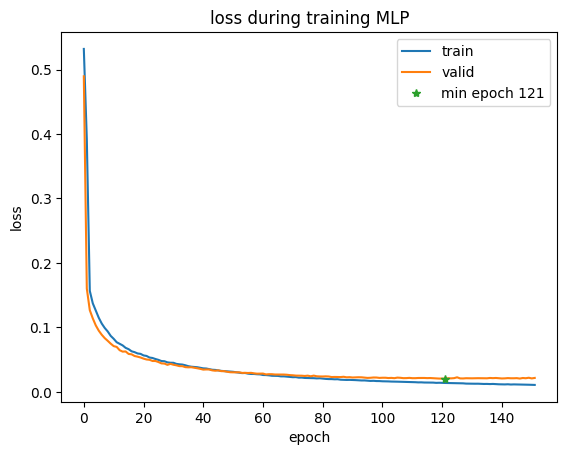

load pretrained model from  A3/uw/MLP_MT_2.pt
[Test] Loss: 0.023
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.693  &0.830  &0.911  &0.438


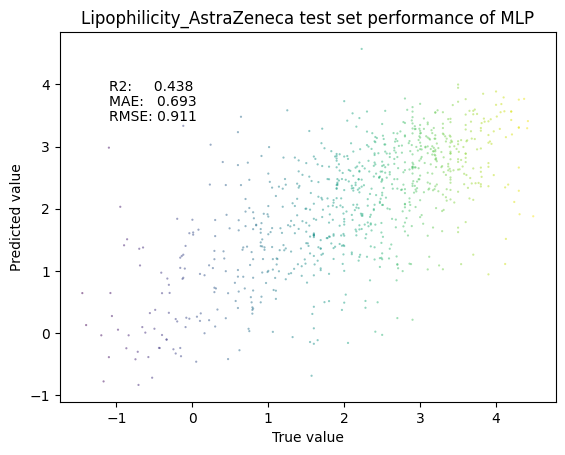


*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.975  &1.723  &1.313  &0.683


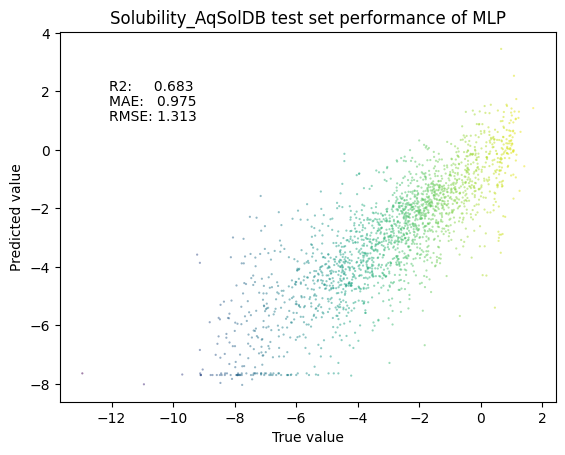


*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.845  &0.500  &0.845  &1.000  &0.000  &0.916 &0.789 &  nan &0.941


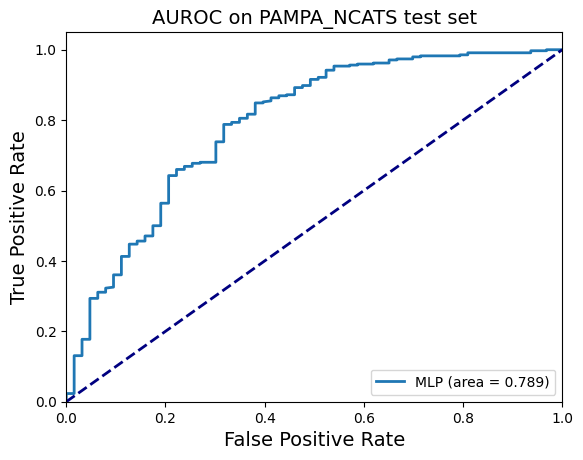

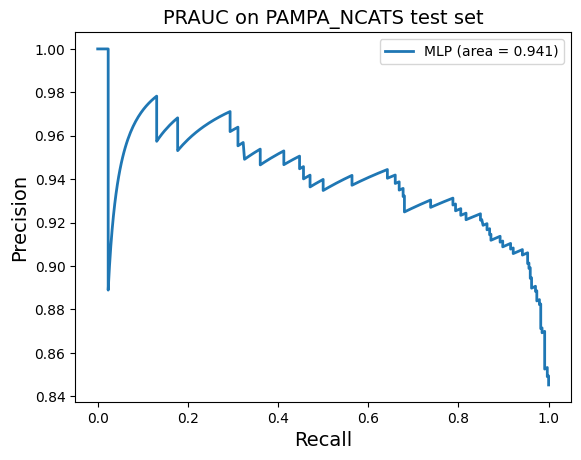

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!




--> Train status saved at A3/uw/MLP_MT_2.yml
Finished evaluate test performance, outputs performance dict
repeated num # 3 idx 1 has the lowest loss from [0.02265180749460482, 0.022580833313091155, 0.022631745991440348]
******************** Lipophilicity_AstraZeneca ******************** 
	|       mae      |       mse      |       rmse      |       r2      
	&0.674$\pm$0.013  &0.783$\pm$0.037  &0.885$\pm$0.021  &0.470$\pm$0.025  
 idx 1: &0.669            &0.779            &0.883            &0.472            

******************** Solubility_AqSolDB ******************** 
	|       mae      |       mse      |       rmse      |       r2      
	&0.977$\pm$0.004  &1.733$\pm$0.017  &1.316$\pm$0.007  &0.681$\pm$0.003  
 idx 1: &0.974            &1.719            &1.311            &0.683            

******************** PAMPA_NCATS ******************** 
	|       acc      |       w_acc      |       prec      |       recall      |       sp      |       f1      |       auc      |       mcc     

[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  43 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done 3724 tasks      | elapsed:    7.0s
[Parallel(n_jobs=6)]: Done 11245 out of 11245 | elapsed:   12.5s finished


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 1617 out of 1617 | elapsed:    1.6s finished
[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


--> preparing data loader for model type  AttentiveFP
Processing dgl graphs from scratch...


[Parallel(n_jobs=6)]: Done 100 tasks      | elapsed:    0.1s
[Parallel(n_jobs=6)]: Done 3148 tasks      | elapsed:    2.1s
[Parallel(n_jobs=6)]: Done 3238 out of 3238 | elapsed:    2.2s finished


Model type:  AttentiveFP | Model parameters:  3824109
Start training AttentiveFP...
Epoch:0 [Train] Loss: 0.204 | [Valid] Loss: 0.231	SAVE MODEL: loss: inf -> 0.231 | runtime: 0.319 ms
Epoch:1 [Train] Loss: 0.229 | [Valid] Loss: 0.117	SAVE MODEL: loss: 0.231 -> 0.117 | runtime: 0.273 ms
Epoch:2 [Train] Loss: 0.109 | [Valid] Loss: 0.092	SAVE MODEL: loss: 0.117 -> 0.092 | runtime: 0.273 ms
Epoch:3 [Train] Loss: 0.089 | [Valid] Loss: 0.078	SAVE MODEL: loss: 0.092 -> 0.078 | runtime: 0.272 ms
Epoch:4 [Train] Loss: 0.077 | [Valid] Loss: 0.073	SAVE MODEL: loss: 0.078 -> 0.073 | runtime: 0.278 ms
Epoch:5 [Train] Loss: 0.068 | [Valid] Loss: 0.068	SAVE MODEL: loss: 0.073 -> 0.068 | runtime: 0.276 ms
Epoch:6 [Train] Loss: 0.062 | [Valid] Loss: 0.060	SAVE MODEL: loss: 0.068 -> 0.060 | runtime: 0.275 ms
Epoch:7 [Train] Loss: 0.056 | [Valid] Loss: 0.053	SAVE MODEL: loss: 0.060 -> 0.053 | runtime: 0.273 ms
Epoch:8 [Train] Loss: 0.052 | [Valid] Loss: 0.048	SAVE MODEL: loss: 0.053 -> 0.048 | runtime: 

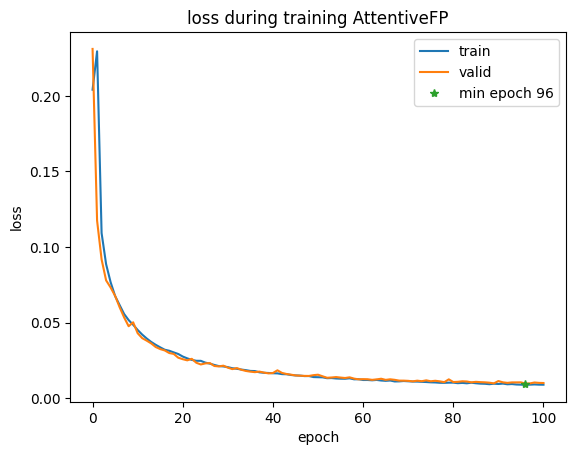

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.472  &0.367  &0.606  &0.745

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.772  &1.175  &1.084  &0.779

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.872  &0.679  &0.891  &0.965  &0.394  &0.927 &0.774 &0.454 &0.921

Epoch:101 [Train] Loss: 0.009 | [Valid] Loss: 0.011	EarlyStopping counter: 5 out of 30
Epoch:102 [Train] Loss: 0.009 | [Valid] Loss: 0.010	EarlyStopping counter: 6 out of 30
Epoch:103 [Train] Loss: 0.009 | [Valid] Loss: 0.010	EarlyStopping counter: 7 out of 30
Epoch:104 [Train] Loss: 0.009 | [Valid] Loss: 0.010	EarlyStopping counter: 8 out of 30
Epoch:105 [Train] Loss: 0.008 | [Valid] Loss: 0.010	EarlyStopping counter: 9 out of 30
Epoch:106 [Train] Loss: 0.009 | [Valid] Loss: 0.011	EarlyStopping counter: 10 out of 30
Epoch:107 [Train] Loss: 0.008 | [Valid] Loss: 0.010	EarlyStopping c

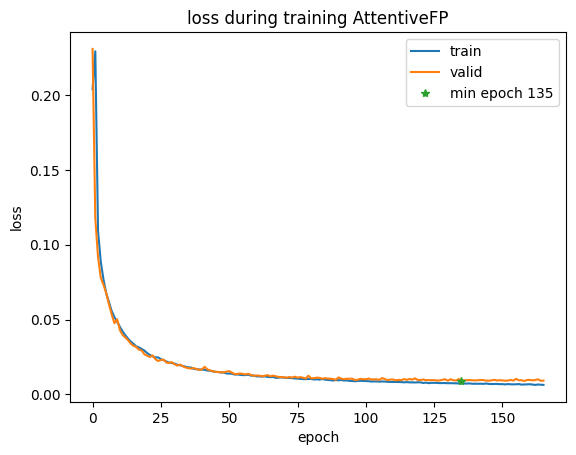

load pretrained model from  A3/uw/AttentiveFP_MT_0.pt
[Test] Loss: 0.019
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.464  &0.397  &0.630  &0.731


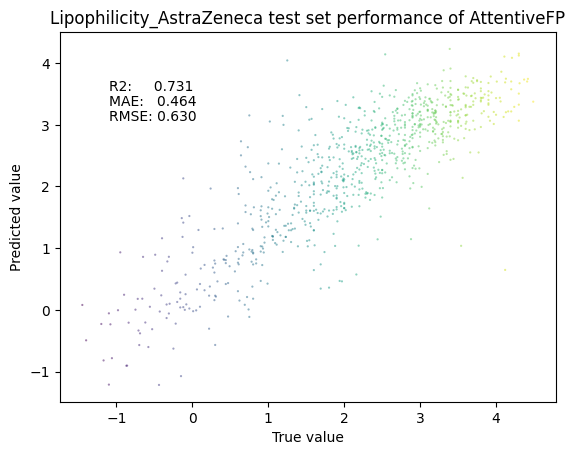


*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.689  &1.003  &1.001  &0.815


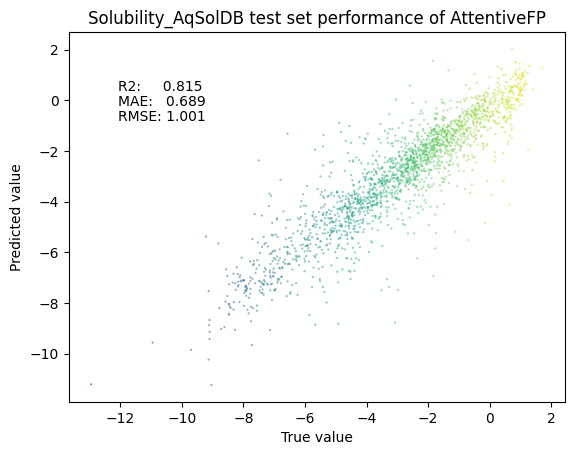


*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.870  &0.670  &0.894  &0.959  &0.381  &0.926 &0.791 &0.423 &0.949


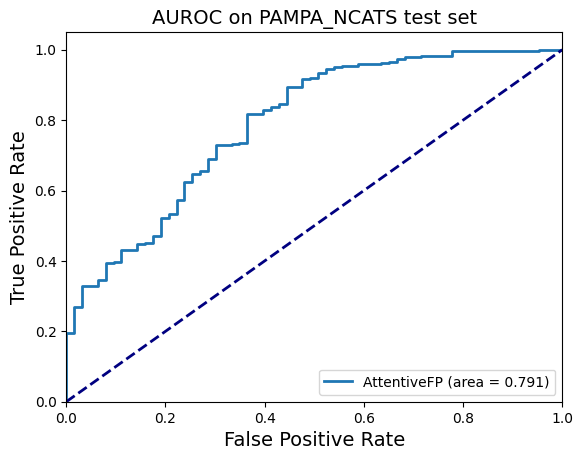

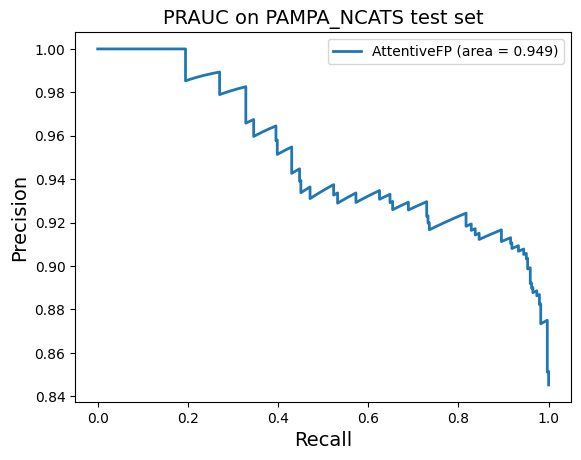



--> Train status saved at A3/uw/AttentiveFP_MT_0.yml
Finished evaluate test performance, outputs performance dict

Run # 1 for AttentiveFP MT	 | save dir:  A3/uw/AttentiveFP_MT_1 | 	cannot open A3/uw/AttentiveFP_MT_1.yml, retrain
Model type:  AttentiveFP | Model parameters:  3824109
Start training AttentiveFP...
Epoch:0 [Train] Loss: 0.219 | [Valid] Loss: 0.266	SAVE MODEL: loss: inf -> 0.266 | runtime: 0.276 ms
Epoch:1 [Train] Loss: 0.234 | [Valid] Loss: 0.120	SAVE MODEL: loss: 0.266 -> 0.120 | runtime: 0.269 ms
Epoch:2 [Train] Loss: 0.107 | [Valid] Loss: 0.091	SAVE MODEL: loss: 0.120 -> 0.091 | runtime: 0.269 ms
Epoch:3 [Train] Loss: 0.088 | [Valid] Loss: 0.079	SAVE MODEL: loss: 0.091 -> 0.079 | runtime: 0.271 ms
Epoch:4 [Train] Loss: 0.076 | [Valid] Loss: 0.073	SAVE MODEL: loss: 0.079 -> 0.073 | runtime: 0.270 ms
Epoch:5 [Train] Loss: 0.068 | [Valid] Loss: 0.066	SAVE MODEL: loss: 0.073 -> 0.066 | runtime: 0.270 ms
Epoch:6 [Train] Loss: 0.061 | [Valid] Loss: 0.059	SAVE MODEL: loss: 

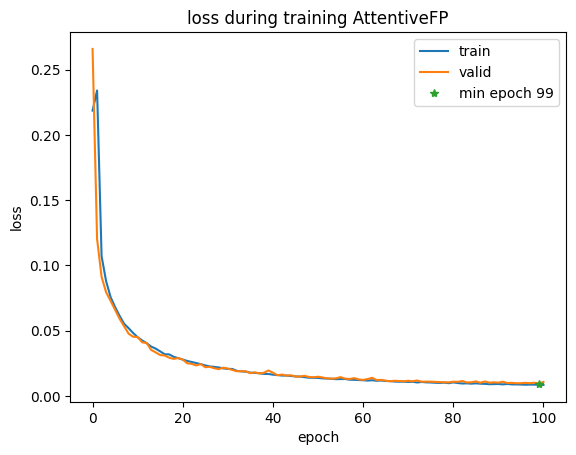

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.530  &0.470  &0.685  &0.673

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.717  &1.065  &1.032  &0.799

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.887  &0.676  &0.889  &0.988  &0.364  &0.936 &0.784 &0.512 &0.926

Epoch:101 [Train] Loss: 0.008 | [Valid] Loss: 0.010	EarlyStopping counter: 2 out of 30
Epoch:102 [Train] Loss: 0.008 | [Valid] Loss: 0.010	EarlyStopping counter: 3 out of 30
Epoch:103 [Train] Loss: 0.008 | [Valid] Loss: 0.010	EarlyStopping counter: 4 out of 30
Epoch:104 [Train] Loss: 0.008 | [Valid] Loss: 0.010	EarlyStopping counter: 5 out of 30
Epoch:105 [Train] Loss: 0.008 | [Valid] Loss: 0.012	EarlyStopping counter: 6 out of 30
Epoch:106 [Train] Loss: 0.008 | [Valid] Loss: 0.010	EarlyStopping counter: 7 out of 30
Epoch:107 [Train] Loss: 0.008 | [Valid] Loss: 0.010	EarlyStopping co

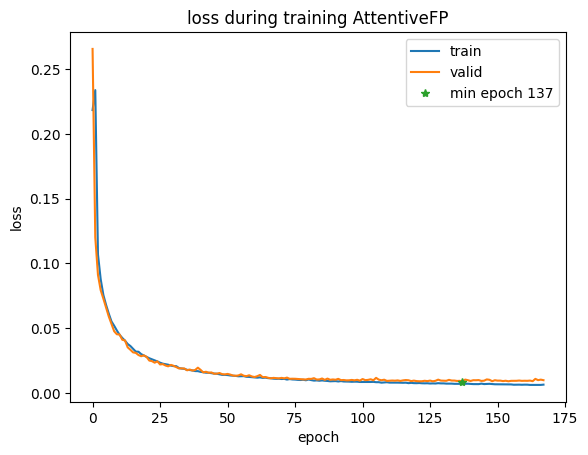

load pretrained model from  A3/uw/AttentiveFP_MT_1.pt
[Test] Loss: 0.019
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.467  &0.401  &0.633  &0.729


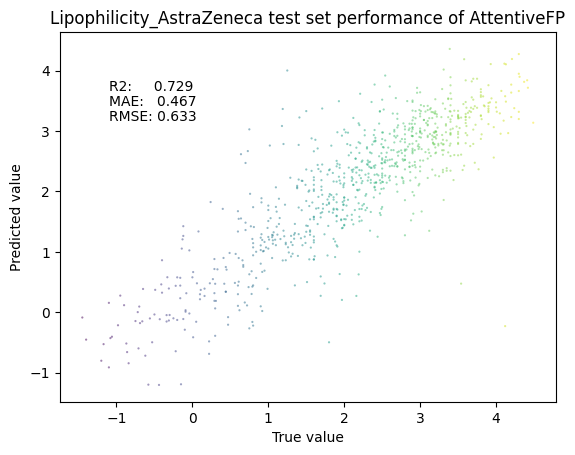


*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.720  &1.054  &1.027  &0.806


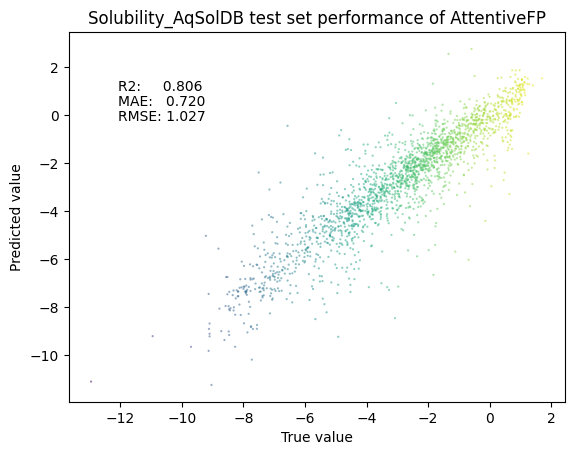


*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.880  &0.695  &0.902  &0.962  &0.429  &0.931 &0.812 &0.475 &0.957


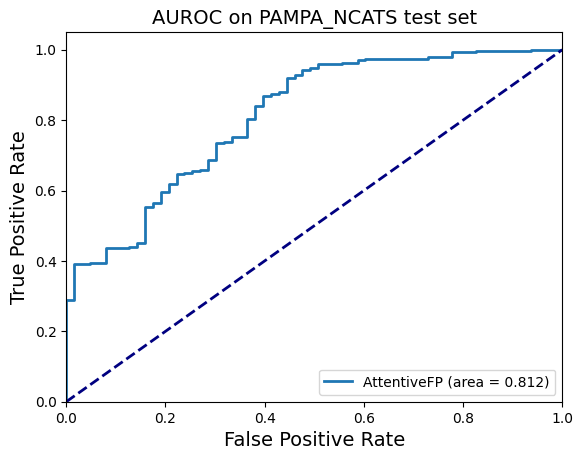

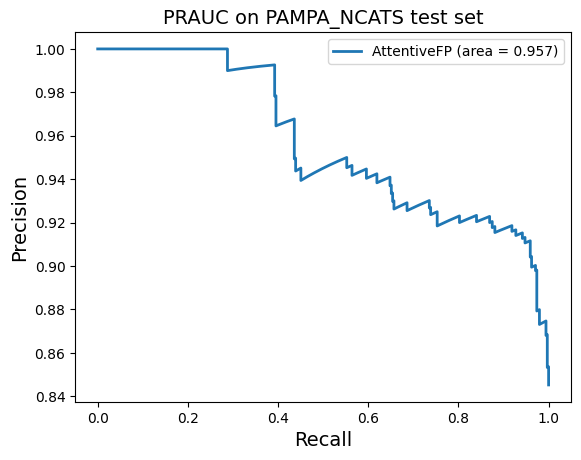



--> Train status saved at A3/uw/AttentiveFP_MT_1.yml
Finished evaluate test performance, outputs performance dict

Run # 2 for AttentiveFP MT	 | save dir:  A3/uw/AttentiveFP_MT_2 | 	cannot open A3/uw/AttentiveFP_MT_2.yml, retrain
Model type:  AttentiveFP | Model parameters:  3824109
Start training AttentiveFP...
Epoch:0 [Train] Loss: 0.219 | [Valid] Loss: 0.240	SAVE MODEL: loss: inf -> 0.240 | runtime: 0.280 ms
Epoch:1 [Train] Loss: 0.229 | [Valid] Loss: 0.114	SAVE MODEL: loss: 0.240 -> 0.114 | runtime: 0.280 ms
Epoch:2 [Train] Loss: 0.109 | [Valid] Loss: 0.093	SAVE MODEL: loss: 0.114 -> 0.093 | runtime: 0.279 ms
Epoch:3 [Train] Loss: 0.089 | [Valid] Loss: 0.084	SAVE MODEL: loss: 0.093 -> 0.084 | runtime: 0.279 ms
Epoch:4 [Train] Loss: 0.077 | [Valid] Loss: 0.075	SAVE MODEL: loss: 0.084 -> 0.075 | runtime: 0.284 ms
Epoch:5 [Train] Loss: 0.070 | [Valid] Loss: 0.067	SAVE MODEL: loss: 0.075 -> 0.067 | runtime: 0.279 ms
Epoch:6 [Train] Loss: 0.063 | [Valid] Loss: 0.061	SAVE MODEL: loss: 

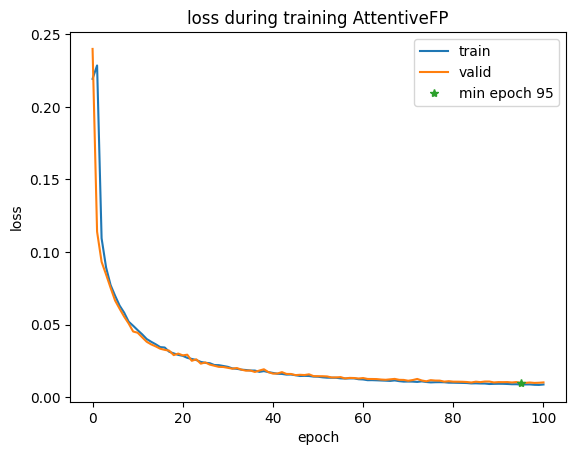

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.454  &0.365  &0.604  &0.746

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.749  &1.139  &1.067  &0.785

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.847  &0.616  &0.872  &0.959  &0.273  &0.913 &0.771 &0.317 &0.927

Epoch:101 [Train] Loss: 0.009 | [Valid] Loss: 0.010	SAVE MODEL: loss: 0.010 -> 0.010 | runtime: 0.276 ms
Epoch:102 [Train] Loss: 0.008 | [Valid] Loss: 0.010	SAVE MODEL: loss: 0.010 -> 0.010 | runtime: 0.273 ms
Epoch:103 [Train] Loss: 0.008 | [Valid] Loss: 0.011	EarlyStopping counter: 1 out of 30
Epoch:104 [Train] Loss: 0.008 | [Valid] Loss: 0.009	SAVE MODEL: loss: 0.010 -> 0.009 | runtime: 0.275 ms
Epoch:105 [Train] Loss: 0.008 | [Valid] Loss: 0.010	EarlyStopping counter: 1 out of 30
Epoch:106 [Train] Loss: 0.008 | [Valid] Loss: 0.010	EarlyStopping counter: 2 out of 30
Epoch:107 [Tra

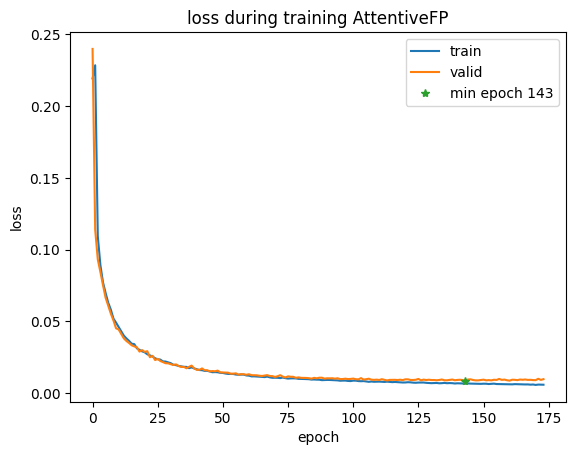

load pretrained model from  A3/uw/AttentiveFP_MT_2.pt
[Test] Loss: 0.019
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.462  &0.384  &0.619  &0.740


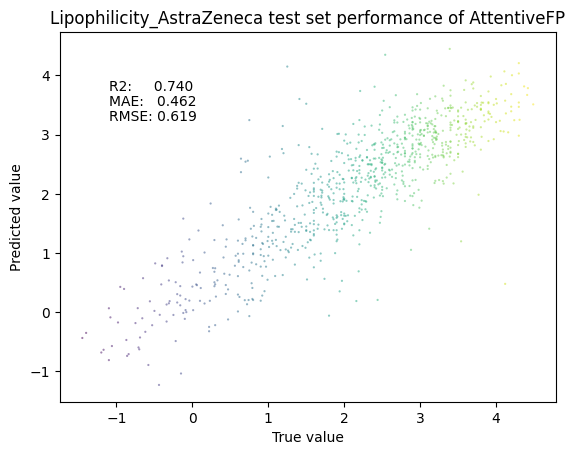


*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.722  &1.110  &1.054  &0.795


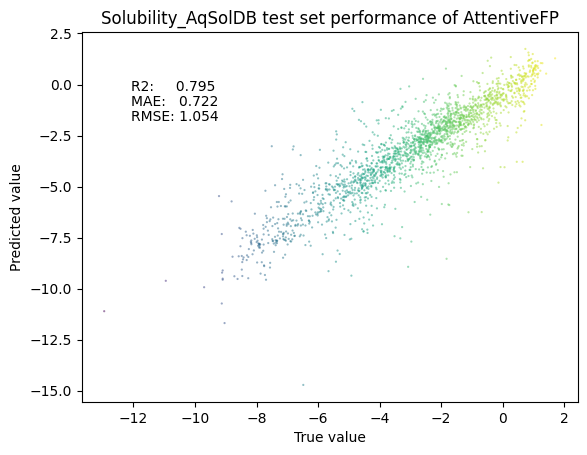


*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.875  &0.686  &0.899  &0.959  &0.413  &0.928 &0.786 &0.452 &0.946


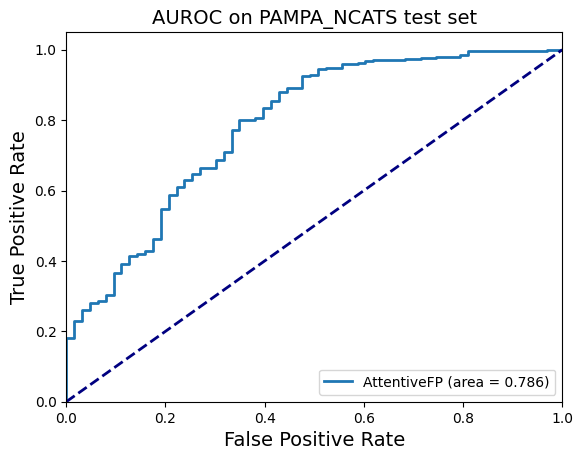

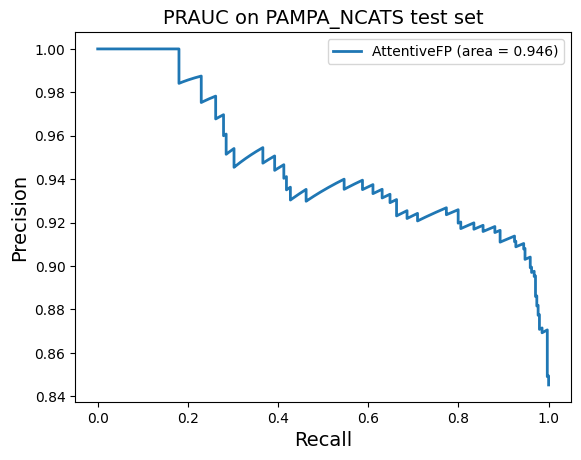



--> Train status saved at A3/uw/AttentiveFP_MT_2.yml
Finished evaluate test performance, outputs performance dict
repeated num # 3 idx 1 has the lowest loss from [0.019499136734968767, 0.018508612626017287, 0.019487951506072514]
******************** Lipophilicity_AstraZeneca ******************** 
	|       mae      |       mse      |       rmse      |       r2      
	&0.465$\pm$0.002  &0.394$\pm$0.007  &0.627$\pm$0.006  &0.734$\pm$0.005  
 idx 1: &0.467            &0.401            &0.633            &0.729            

******************** Solubility_AqSolDB ******************** 
	|       mae      |       mse      |       rmse      |       r2      
	&0.710$\pm$0.015  &1.056$\pm$0.044  &1.027$\pm$0.021  &0.805$\pm$0.008  
 idx 1: &0.720            &1.054            &1.027            &0.806            

******************** PAMPA_NCATS ******************** 
	|       acc      |       w_acc      |       prec      |       recall      |       sp      |       f1      |       auc      |      

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!



Run # 0 for GIN MT	 | save dir:  A3/uw/GIN_MT_0 | 	cannot open A3/uw/GIN_MT_0.yml, retrain
collect data for:  ['Lipophilicity_AstraZeneca', 'Solubility_AqSolDB', 'PAMPA_NCATS']

START scaling train valid test data set: 
---> scale Lipophilicity_AstraZeneca | min -1.500 | max 4.500

START scaling train valid test data set: 
---> scale Solubility_AqSolDB | min -13.172 | max 2.138
Finished scaling process | dict_scale: {'Lipophilicity_AstraZeneca': [-1.5, 4.5], 'Solubility_AqSolDB': [-13.1719, 2.1376816201]} 

---> loader for ['Lipophilicity_AstraZeneca', 'Solubility_AqSolDB', 'PAMPA_NCATS']
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN
--> preparing data loader for model type  GIN


gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 67.4MB/s]


Pretrained model loaded
Model type:  GIN | Model parameters:  1978767
Start training GIN...
Epoch:0 [Train] Loss: 0.477 | [Valid] Loss: 0.432	SAVE MODEL: loss: inf -> 0.432 | runtime: 2.117 ms
Epoch:1 [Train] Loss: 0.286 | [Valid] Loss: 0.106	SAVE MODEL: loss: 0.432 -> 0.106 | runtime: 2.113 ms
Epoch:2 [Train] Loss: 0.104 | [Valid] Loss: 0.090	SAVE MODEL: loss: 0.106 -> 0.090 | runtime: 2.119 ms
Epoch:3 [Train] Loss: 0.096 | [Valid] Loss: 0.082	SAVE MODEL: loss: 0.090 -> 0.082 | runtime: 2.098 ms
Epoch:4 [Train] Loss: 0.089 | [Valid] Loss: 0.077	SAVE MODEL: loss: 0.082 -> 0.077 | runtime: 2.095 ms
Epoch:5 [Train] Loss: 0.085 | [Valid] Loss: 0.073	SAVE MODEL: loss: 0.077 -> 0.073 | runtime: 2.102 ms
Epoch:6 [Train] Loss: 0.082 | [Valid] Loss: 0.067	SAVE MODEL: loss: 0.073 -> 0.067 | runtime: 2.131 ms
Epoch:7 [Train] Loss: 0.077 | [Valid] Loss: 0.064	SAVE MODEL: loss: 0.067 -> 0.064 | runtime: 2.156 ms
Epoch:8 [Train] Loss: 0.073 | [Valid] Loss: 0.063	SAVE MODEL: loss: 0.064 -> 0.063 | r

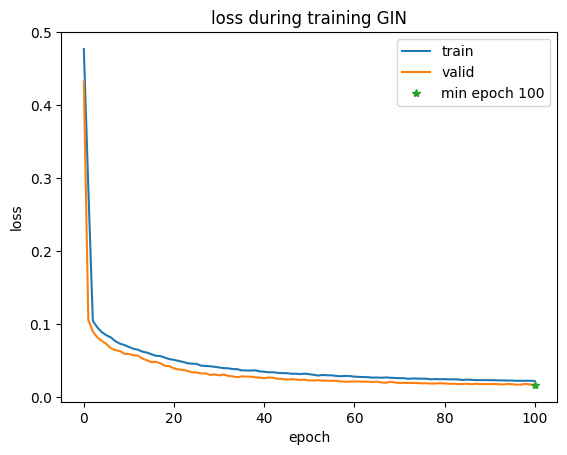

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.555  &0.500  &0.707  &0.652

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.956  &1.692  &1.301  &0.681

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.837  &0.500  &0.837  &1.000  &0.000  &0.912 &0.746 &  nan &0.906

Epoch:101 [Train] Loss: 0.023 | [Valid] Loss: 0.018	EarlyStopping counter: 1 out of 30
Epoch:102 [Train] Loss: 0.022 | [Valid] Loss: 0.017	EarlyStopping counter: 2 out of 30
Epoch:103 [Train] Loss: 0.022 | [Valid] Loss: 0.018	EarlyStopping counter: 3 out of 30
Epoch:104 [Train] Loss: 0.022 | [Valid] Loss: 0.017	EarlyStopping counter: 4 out of 30
Epoch:105 [Train] Loss: 0.022 | [Valid] Loss: 0.016	SAVE MODEL: loss: 0.017 -> 0.016 | runtime: 2.031 ms
Epoch:106 [Train] Loss: 0.021 | [Valid] Loss: 0.017	EarlyStopping counter: 1 out of 30
Epoch:107 [Train] Loss: 0.022 | [Valid] Loss: 0.01

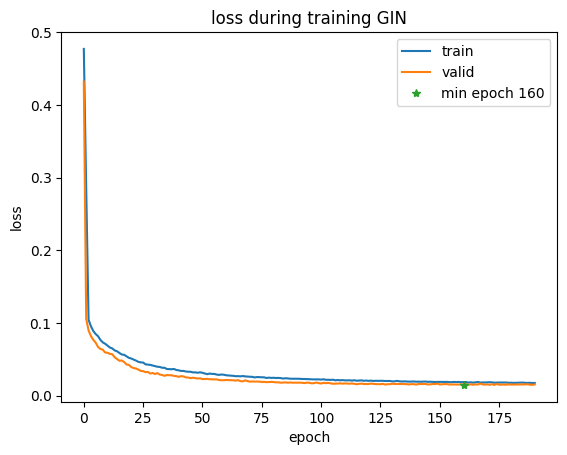

load pretrained model from  A3/uw/GIN_MT_0.pt
[Test] Loss: 0.020
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.551  &0.507  &0.712  &0.657


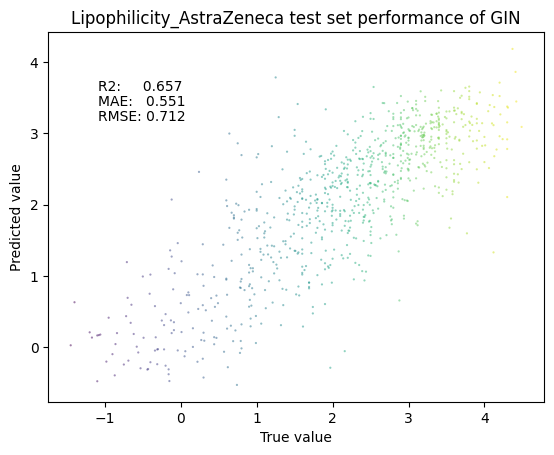


*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.892  &1.537  &1.240  &0.717


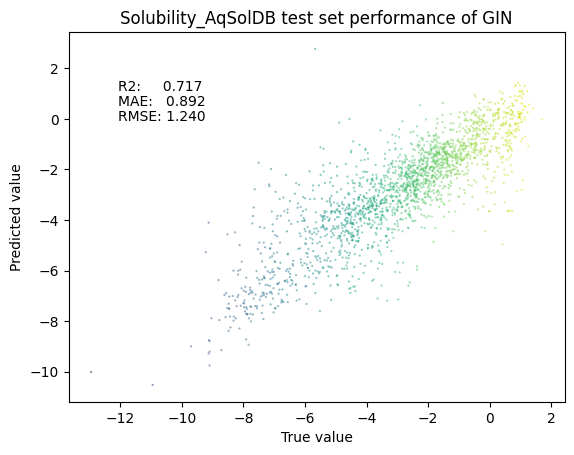


*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.882  &0.645  &0.885  &0.988  &0.302  &0.934 &0.819 &0.454 &0.953


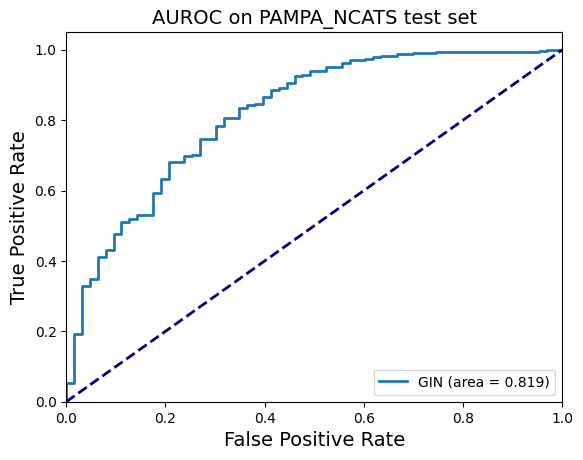

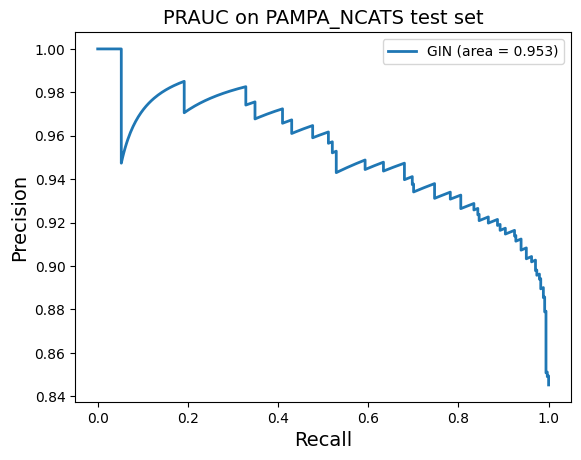



--> Train status saved at A3/uw/GIN_MT_0.yml
Finished evaluate test performance, outputs performance dict

Run # 1 for GIN MT	 | save dir:  A3/uw/GIN_MT_1 | 	cannot open A3/uw/GIN_MT_1.yml, retrain


gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 68.1MB/s]


Pretrained model loaded
Model type:  GIN | Model parameters:  1978767
Start training GIN...
Epoch:0 [Train] Loss: 0.405 | [Valid] Loss: 0.424	SAVE MODEL: loss: inf -> 0.424 | runtime: 2.055 ms
Epoch:1 [Train] Loss: 0.350 | [Valid] Loss: 0.096	SAVE MODEL: loss: 0.424 -> 0.096 | runtime: 2.056 ms
Epoch:2 [Train] Loss: 0.106 | [Valid] Loss: 0.080	SAVE MODEL: loss: 0.096 -> 0.080 | runtime: 2.048 ms
Epoch:3 [Train] Loss: 0.095 | [Valid] Loss: 0.073	SAVE MODEL: loss: 0.080 -> 0.073 | runtime: 2.040 ms
Epoch:4 [Train] Loss: 0.087 | [Valid] Loss: 0.068	SAVE MODEL: loss: 0.073 -> 0.068 | runtime: 2.069 ms
Epoch:5 [Train] Loss: 0.081 | [Valid] Loss: 0.061	SAVE MODEL: loss: 0.068 -> 0.061 | runtime: 2.032 ms
Epoch:6 [Train] Loss: 0.076 | [Valid] Loss: 0.057	SAVE MODEL: loss: 0.061 -> 0.057 | runtime: 2.047 ms
Epoch:7 [Train] Loss: 0.071 | [Valid] Loss: 0.051	SAVE MODEL: loss: 0.057 -> 0.051 | runtime: 2.056 ms
Epoch:8 [Train] Loss: 0.066 | [Valid] Loss: 0.048	SAVE MODEL: loss: 0.051 -> 0.048 | r

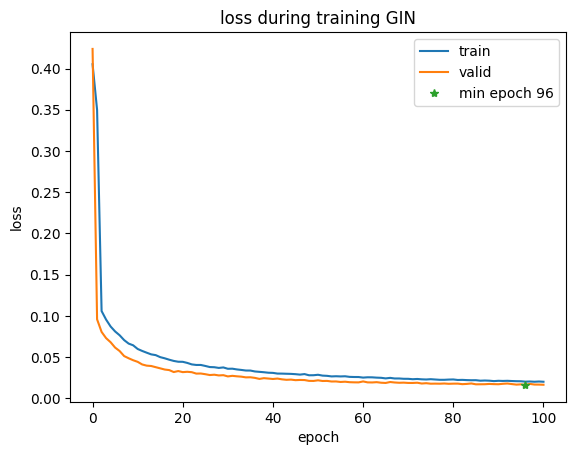

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.537  &0.463  &0.680  &0.678

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.989  &1.759  &1.326  &0.669

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.847  &0.555  &0.853  &0.988  &0.121  &0.916 &0.747 &0.238 &0.914

Epoch:101 [Train] Loss: 0.020 | [Valid] Loss: 0.016	SAVE MODEL: loss: 0.016 -> 0.016 | runtime: 2.055 ms
Epoch:102 [Train] Loss: 0.020 | [Valid] Loss: 0.017	EarlyStopping counter: 1 out of 30
Epoch:103 [Train] Loss: 0.020 | [Valid] Loss: 0.017	EarlyStopping counter: 2 out of 30
Epoch:104 [Train] Loss: 0.020 | [Valid] Loss: 0.016	EarlyStopping counter: 3 out of 30
Epoch:105 [Train] Loss: 0.020 | [Valid] Loss: 0.016	EarlyStopping counter: 4 out of 30
Epoch:106 [Train] Loss: 0.020 | [Valid] Loss: 0.017	EarlyStopping counter: 5 out of 30
Epoch:107 [Train] Loss: 0.020 | [Valid] Loss: 0.01

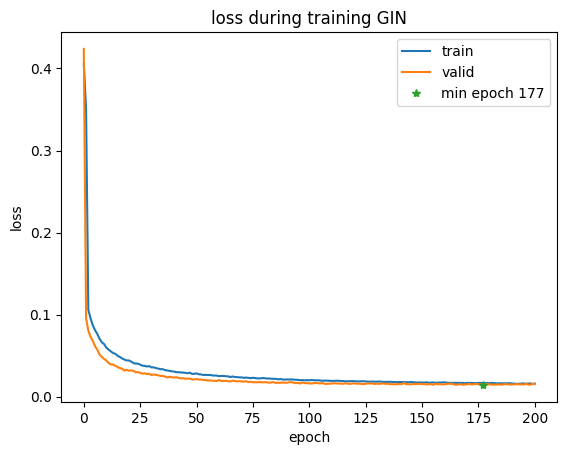

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.549  &0.481  &0.694  &0.665

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.887  &1.528  &1.236  &0.712

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.887  &0.700  &0.897  &0.976  &0.424  &0.935 &0.749 &0.520 &0.913

Epoch:201 [Train] Loss: 0.016 | [Valid] Loss: 0.015	EarlyStopping counter: 24 out of 30
Epoch:202 [Train] Loss: 0.016 | [Valid] Loss: 0.015	EarlyStopping counter: 25 out of 30
Epoch:203 [Train] Loss: 0.016 | [Valid] Loss: 0.015	EarlyStopping counter: 26 out of 30
Epoch:204 [Train] Loss: 0.016 | [Valid] Loss: 0.015	EarlyStopping counter: 27 out of 30
Epoch:205 [Train] Loss: 0.016 | [Valid] Loss: 0.015	EarlyStopping counter: 28 out of 30
Epoch:206 [Train] Loss: 0.016 | [Valid] Loss: 0.015	EarlyStopping counter: 29 out of 30
Epoch:207 [Train] Loss: 0.016 | [Valid] Loss: 0.015	EarlyStopp

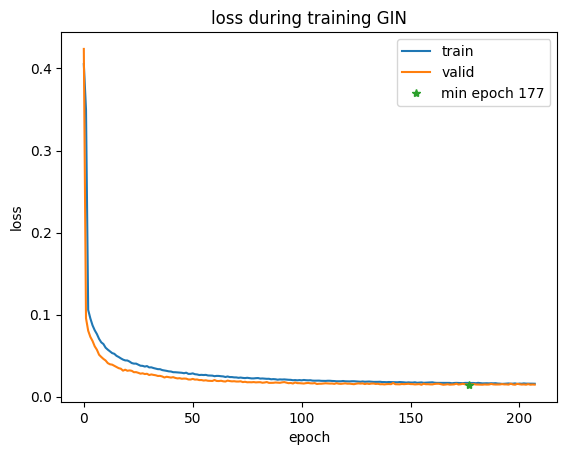

load pretrained model from  A3/uw/GIN_MT_1.pt
[Test] Loss: 0.019
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.529  &0.466  &0.682  &0.685


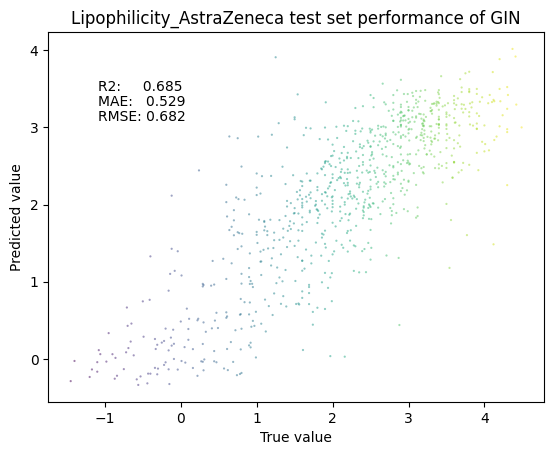


*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.879  &1.498  &1.224  &0.724


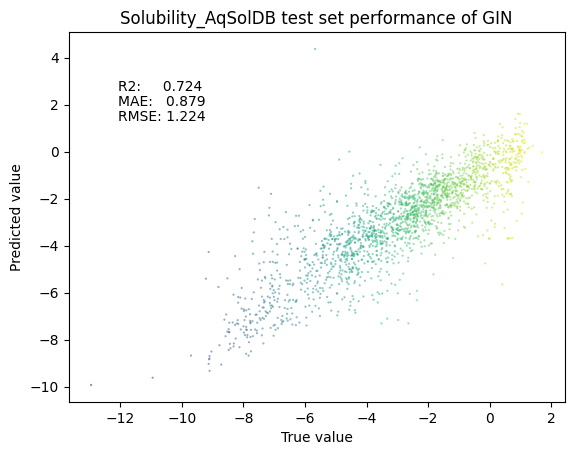


*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.880  &0.676  &0.895  &0.971  &0.381  &0.932 &0.812 &0.460 &0.949


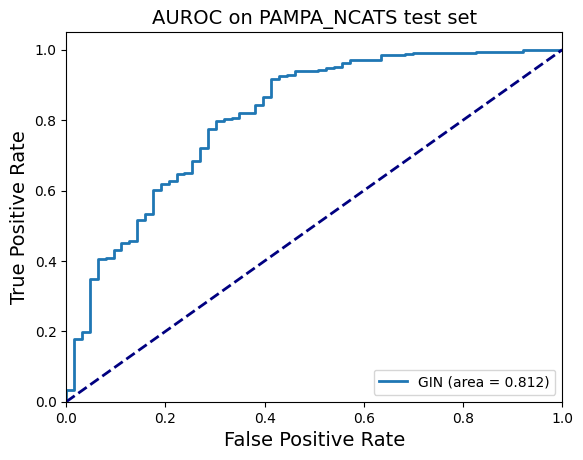

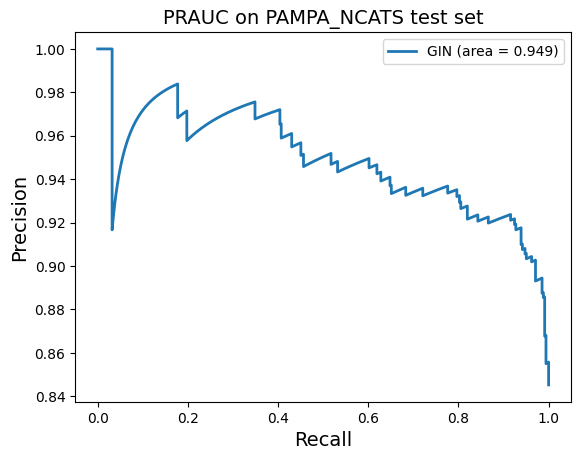



--> Train status saved at A3/uw/GIN_MT_1.yml
Finished evaluate test performance, outputs performance dict

Run # 2 for GIN MT	 | save dir:  A3/uw/GIN_MT_2 | 	cannot open A3/uw/GIN_MT_2.yml, retrain


gin_supervised_contextpred_pre_trained.pth: 100%|██████████| 7.45M/7.45M [00:00<00:00, 70.1MB/s]


Pretrained model loaded
Model type:  GIN | Model parameters:  1978767
Start training GIN...
Epoch:0 [Train] Loss: 0.658 | [Valid] Loss: 0.626	SAVE MODEL: loss: inf -> 0.626 | runtime: 2.048 ms
Epoch:1 [Train] Loss: 0.458 | [Valid] Loss: 0.151	SAVE MODEL: loss: 0.626 -> 0.151 | runtime: 2.053 ms
Epoch:2 [Train] Loss: 0.164 | [Valid] Loss: 0.137	SAVE MODEL: loss: 0.151 -> 0.137 | runtime: 2.068 ms
Epoch:3 [Train] Loss: 0.152 | [Valid] Loss: 0.128	SAVE MODEL: loss: 0.137 -> 0.128 | runtime: 2.060 ms
Epoch:4 [Train] Loss: 0.141 | [Valid] Loss: 0.121	SAVE MODEL: loss: 0.128 -> 0.121 | runtime: 2.057 ms
Epoch:5 [Train] Loss: 0.132 | [Valid] Loss: 0.110	SAVE MODEL: loss: 0.121 -> 0.110 | runtime: 2.056 ms
Epoch:6 [Train] Loss: 0.122 | [Valid] Loss: 0.102	SAVE MODEL: loss: 0.110 -> 0.102 | runtime: 2.073 ms
Epoch:7 [Train] Loss: 0.116 | [Valid] Loss: 0.097	SAVE MODEL: loss: 0.102 -> 0.097 | runtime: 2.058 ms
Epoch:8 [Train] Loss: 0.112 | [Valid] Loss: 0.094	SAVE MODEL: loss: 0.097 -> 0.094 | r

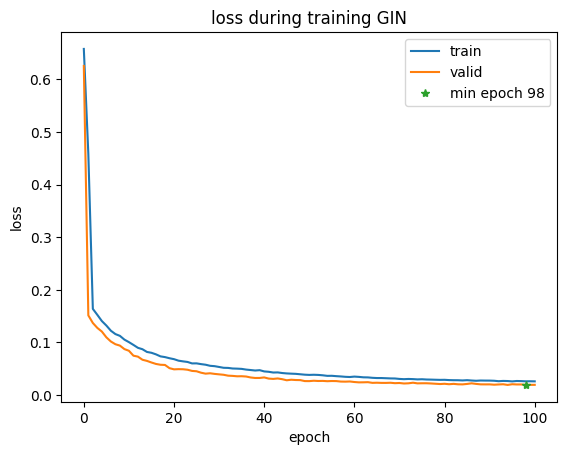

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.575  &0.525  &0.725  &0.634

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.993  &1.785  &1.336  &0.664

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.837  &0.500  &0.837  &1.000  &0.000  &0.912 &0.749 &  nan &0.911

Epoch:101 [Train] Loss: 0.026 | [Valid] Loss: 0.019	EarlyStopping counter: 3 out of 30
Epoch:102 [Train] Loss: 0.025 | [Valid] Loss: 0.020	EarlyStopping counter: 4 out of 30
Epoch:103 [Train] Loss: 0.025 | [Valid] Loss: 0.019	SAVE MODEL: loss: 0.019 -> 0.019 | runtime: 2.027 ms
Epoch:104 [Train] Loss: 0.025 | [Valid] Loss: 0.020	EarlyStopping counter: 1 out of 30
Epoch:105 [Train] Loss: 0.026 | [Valid] Loss: 0.019	EarlyStopping counter: 2 out of 30
Epoch:106 [Train] Loss: 0.025 | [Valid] Loss: 0.018	SAVE MODEL: loss: 0.019 -> 0.018 | runtime: 2.064 ms
Epoch:107 [Train] Loss: 0.025 | 

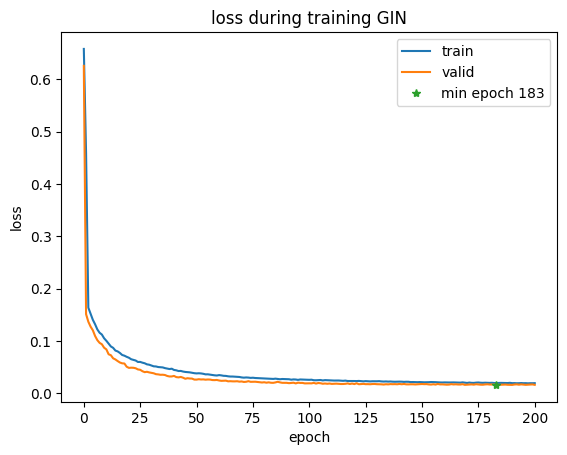

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.514  &0.434  &0.659  &0.698

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.919  &1.589  &1.261  &0.701

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.862  &0.600  &0.866  &0.988  &0.212  &0.923 &0.756 &0.359 &0.922

Epoch:201 [Train] Loss: 0.019 | [Valid] Loss: 0.017	EarlyStopping counter: 18 out of 30
Epoch:202 [Train] Loss: 0.020 | [Valid] Loss: 0.017	EarlyStopping counter: 19 out of 30
Epoch:203 [Train] Loss: 0.019 | [Valid] Loss: 0.017	EarlyStopping counter: 20 out of 30
Epoch:204 [Train] Loss: 0.019 | [Valid] Loss: 0.017	EarlyStopping counter: 21 out of 30
Epoch:205 [Train] Loss: 0.019 | [Valid] Loss: 0.017	EarlyStopping counter: 22 out of 30
Epoch:206 [Train] Loss: 0.019 | [Valid] Loss: 0.016	SAVE MODEL: loss: 0.016 -> 0.016 | runtime: 2.047 ms
Epoch:207 [Train] Loss: 0.019 | [Valid] Loss:

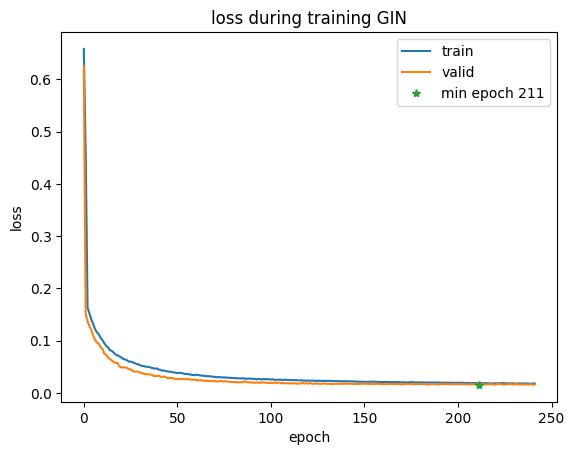

load pretrained model from  A3/uw/GIN_MT_2.pt
[Test] Loss: 0.020
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.536  &0.488  &0.699  &0.670


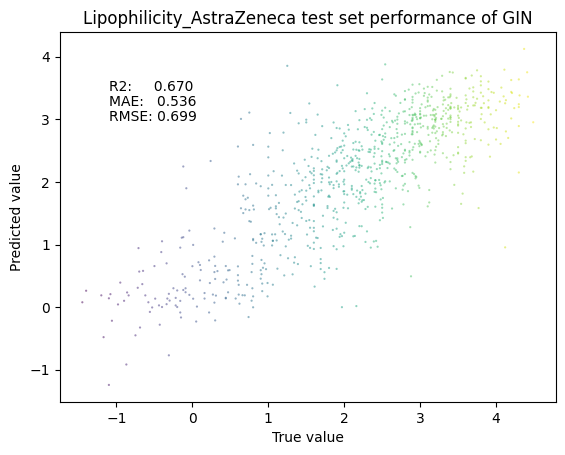


*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.906  &1.572  &1.254  &0.710


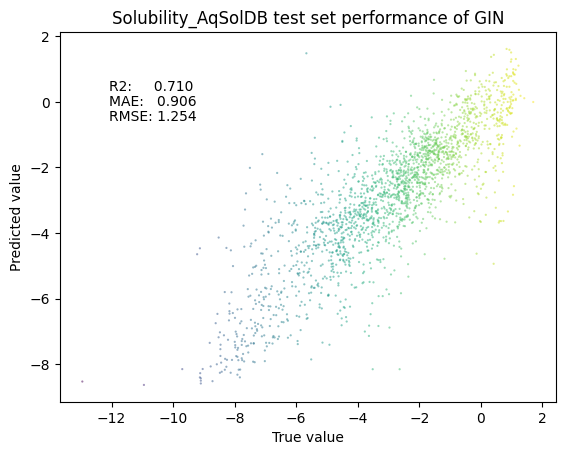


*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.860  &0.638  &0.885  &0.959  &0.317  &0.921 &0.797 &0.362 &0.943


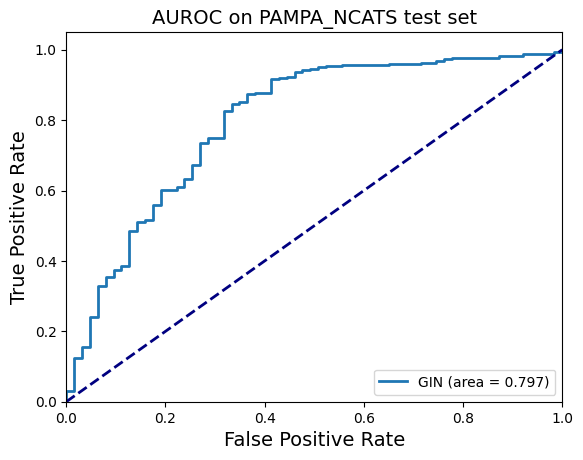

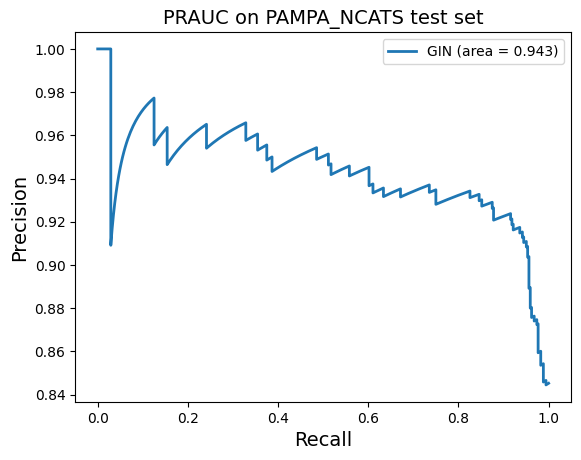

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!




--> Train status saved at A3/uw/GIN_MT_2.yml
Finished evaluate test performance, outputs performance dict
repeated num # 3 idx 1 has the lowest loss from [0.019672739874714844, 0.019209866371686354, 0.01996947856297573]
******************** Lipophilicity_AstraZeneca ******************** 
	|       mae      |       mse      |       rmse      |       r2      
	&0.538$\pm$0.009  &0.487$\pm$0.017  &0.698$\pm$0.012  &0.670$\pm$0.011  
 idx 1: &0.529            &0.466            &0.682            &0.685            

******************** Solubility_AqSolDB ******************** 
	|       mae      |       mse      |       rmse      |       r2      
	&0.892$\pm$0.011  &1.536$\pm$0.030  &1.239$\pm$0.012  &0.717$\pm$0.006  
 idx 1: &0.879            &1.498            &1.224            &0.724            

******************** PAMPA_NCATS ******************** 
	|       acc      |       w_acc      |       prec      |       recall      |       sp      |       f1      |       auc      |       mcc     

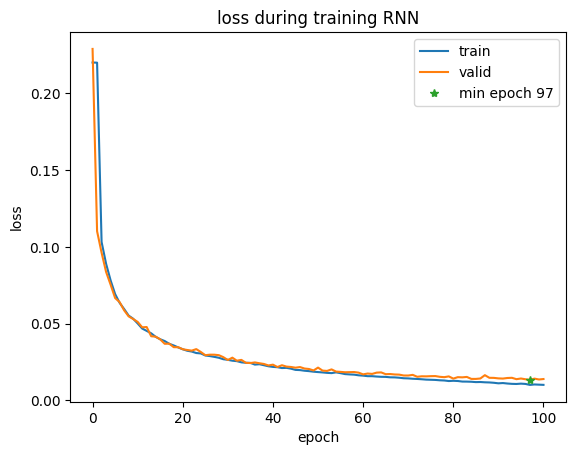

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.647  &0.672  &0.820  &0.533

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.863  &1.469  &1.212  &0.723

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.837  &0.573  &0.859  &0.965  &0.182  &0.909 &0.703 &0.229 &0.889

Epoch:101 [Train] Loss: 0.010 | [Valid] Loss: 0.013	SAVE MODEL: loss: 0.013 -> 0.013 | runtime: 1.176 ms
Epoch:102 [Train] Loss: 0.010 | [Valid] Loss: 0.013	EarlyStopping counter: 1 out of 30
Epoch:103 [Train] Loss: 0.010 | [Valid] Loss: 0.013	EarlyStopping counter: 2 out of 30
Epoch:104 [Train] Loss: 0.010 | [Valid] Loss: 0.014	EarlyStopping counter: 3 out of 30
Epoch:105 [Train] Loss: 0.010 | [Valid] Loss: 0.013	EarlyStopping counter: 4 out of 30
Epoch:106 [Train] Loss: 0.010 | [Valid] Loss: 0.014	EarlyStopping counter: 5 out of 30
Epoch:107 [Train] Loss: 0.010 | [Valid] Loss: 0.01

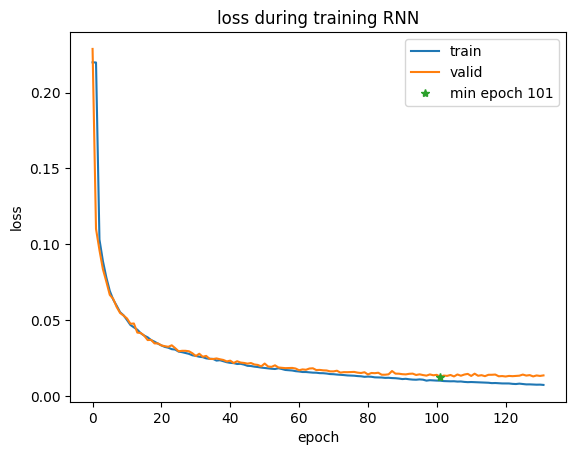

load pretrained model from  A3/uw/RNN_MT_0.pt
[Test] Loss: 0.024
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.629  &0.657  &0.810  &0.555


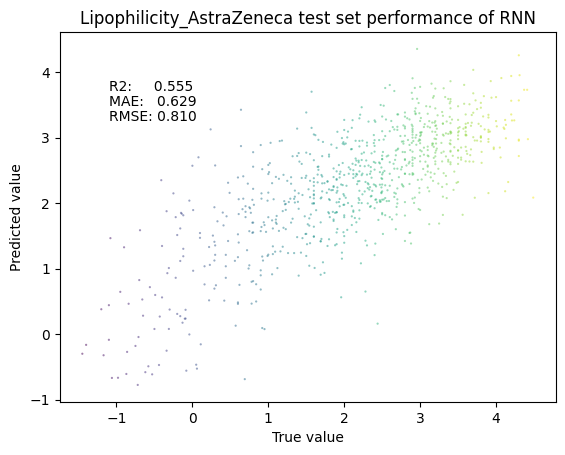


*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.786  &1.255  &1.120  &0.769


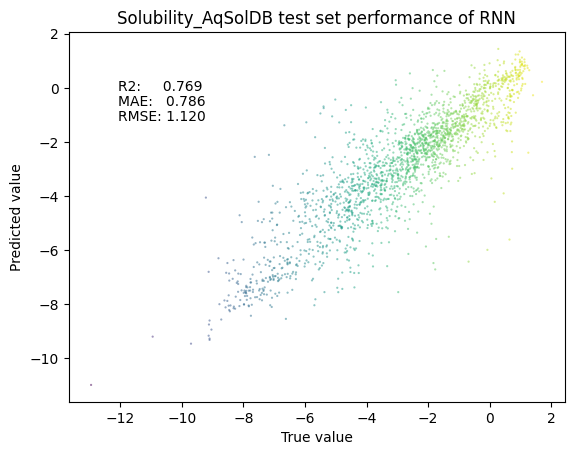


*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.845  &0.565  &0.863  &0.971  &0.159  &0.914 &0.730 &0.217 &0.927


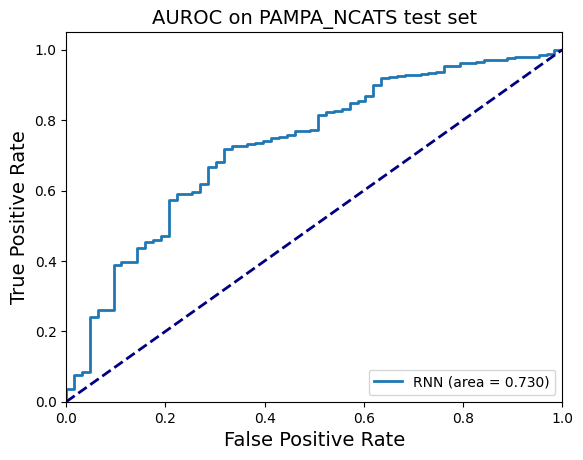

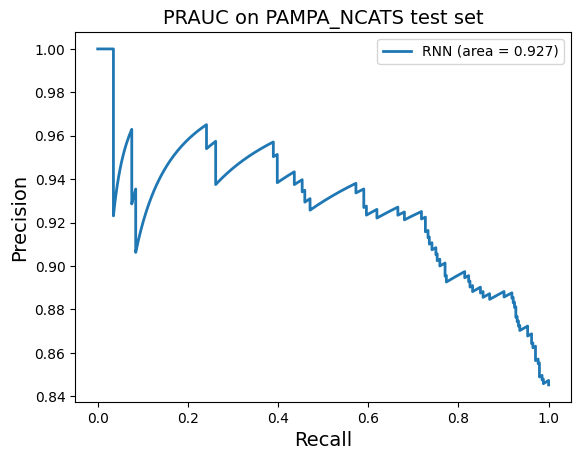



--> Train status saved at A3/uw/RNN_MT_0.yml
Finished evaluate test performance, outputs performance dict

Run # 1 for RNN MT	 | save dir:  A3/uw/RNN_MT_1 | 	cannot open A3/uw/RNN_MT_1.yml, retrain
Model type:  RNN | Model parameters:  2980999
Start training RNN...
Epoch:0 [Train] Loss: 0.238 | [Valid] Loss: 0.234	SAVE MODEL: loss: inf -> 0.234 | runtime: 1.211 ms
Epoch:1 [Train] Loss: 0.221 | [Valid] Loss: 0.107	SAVE MODEL: loss: 0.234 -> 0.107 | runtime: 1.191 ms
Epoch:2 [Train] Loss: 0.100 | [Valid] Loss: 0.093	SAVE MODEL: loss: 0.107 -> 0.093 | runtime: 1.181 ms
Epoch:3 [Train] Loss: 0.088 | [Valid] Loss: 0.087	SAVE MODEL: loss: 0.093 -> 0.087 | runtime: 1.199 ms
Epoch:4 [Train] Loss: 0.079 | [Valid] Loss: 0.074	SAVE MODEL: loss: 0.087 -> 0.074 | runtime: 1.204 ms
Epoch:5 [Train] Loss: 0.069 | [Valid] Loss: 0.069	SAVE MODEL: loss: 0.074 -> 0.069 | runtime: 1.201 ms
Epoch:6 [Train] Loss: 0.064 | [Valid] Loss: 0.063	SAVE MODEL: loss: 0.069 -> 0.063 | runtime: 1.192 ms
Epoch:7 [Trai

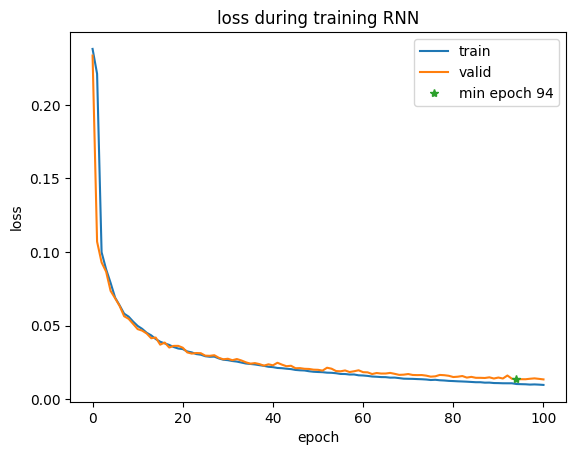

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.622  &0.658  &0.811  &0.542

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.811  &1.372  &1.171  &0.742

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.837  &0.561  &0.855  &0.971  &0.152  &0.909 &0.727 &0.208 &0.912

Epoch:101 [Train] Loss: 0.010 | [Valid] Loss: 0.013	SAVE MODEL: loss: 0.013 -> 0.013 | runtime: 1.202 ms
Epoch:102 [Train] Loss: 0.009 | [Valid] Loss: 0.014	EarlyStopping counter: 1 out of 30
Epoch:103 [Train] Loss: 0.009 | [Valid] Loss: 0.013	EarlyStopping counter: 2 out of 30
Epoch:104 [Train] Loss: 0.009 | [Valid] Loss: 0.013	SAVE MODEL: loss: 0.013 -> 0.013 | runtime: 1.204 ms
Epoch:105 [Train] Loss: 0.009 | [Valid] Loss: 0.014	EarlyStopping counter: 1 out of 30
Epoch:106 [Train] Loss: 0.009 | [Valid] Loss: 0.013	SAVE MODEL: loss: 0.013 -> 0.013 | runtime: 1.195 ms
Epoch:107 [Tra

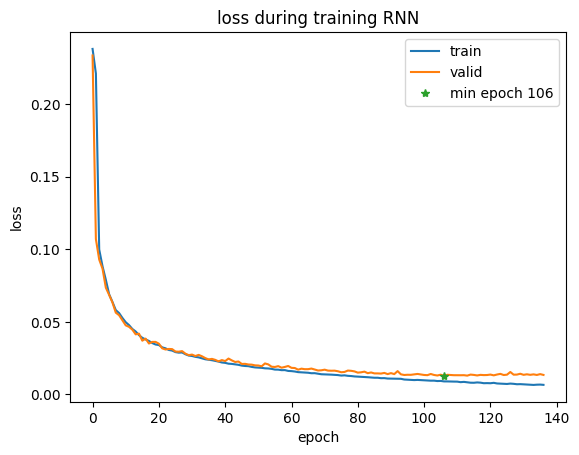

load pretrained model from  A3/uw/RNN_MT_1.pt
[Test] Loss: 0.022
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.576  &0.575  &0.758  &0.611


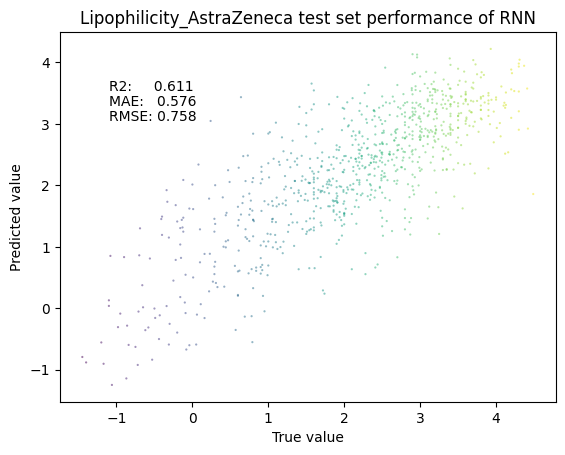


*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.813  &1.313  &1.146  &0.758


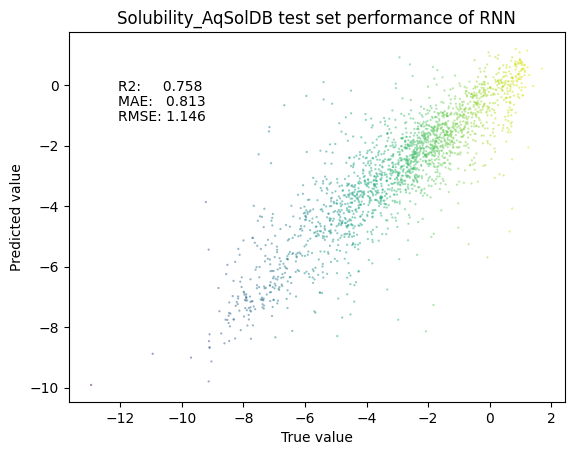


*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.867  &0.597  &0.872  &0.988  &0.206  &0.926 &0.768 &0.352 &0.946


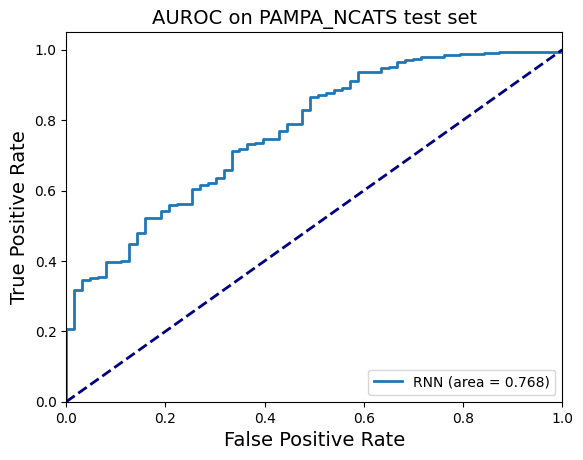

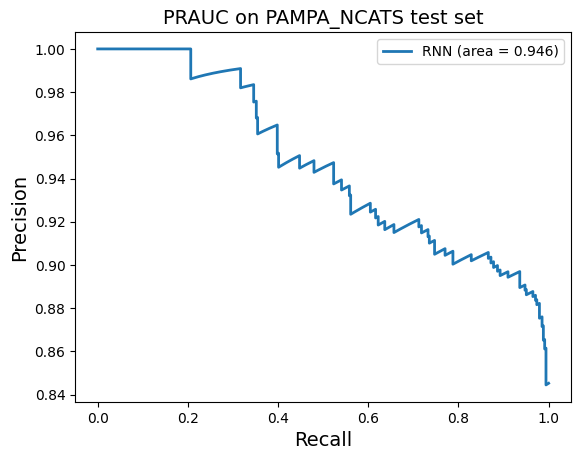



--> Train status saved at A3/uw/RNN_MT_1.yml
Finished evaluate test performance, outputs performance dict

Run # 2 for RNN MT	 | save dir:  A3/uw/RNN_MT_2 | 	cannot open A3/uw/RNN_MT_2.yml, retrain
Model type:  RNN | Model parameters:  2980999
Start training RNN...
Epoch:0 [Train] Loss: 0.226 | [Valid] Loss: 0.247	SAVE MODEL: loss: inf -> 0.247 | runtime: 1.196 ms
Epoch:1 [Train] Loss: 0.221 | [Valid] Loss: 0.109	SAVE MODEL: loss: 0.247 -> 0.109 | runtime: 1.221 ms
Epoch:2 [Train] Loss: 0.102 | [Valid] Loss: 0.100	SAVE MODEL: loss: 0.109 -> 0.100 | runtime: 1.200 ms
Epoch:3 [Train] Loss: 0.089 | [Valid] Loss: 0.086	SAVE MODEL: loss: 0.100 -> 0.086 | runtime: 1.211 ms
Epoch:4 [Train] Loss: 0.078 | [Valid] Loss: 0.076	SAVE MODEL: loss: 0.086 -> 0.076 | runtime: 1.195 ms
Epoch:5 [Train] Loss: 0.069 | [Valid] Loss: 0.066	SAVE MODEL: loss: 0.076 -> 0.066 | runtime: 1.213 ms
Epoch:6 [Train] Loss: 0.063 | [Valid] Loss: 0.063	SAVE MODEL: loss: 0.066 -> 0.063 | runtime: 1.188 ms
Epoch:7 [Trai

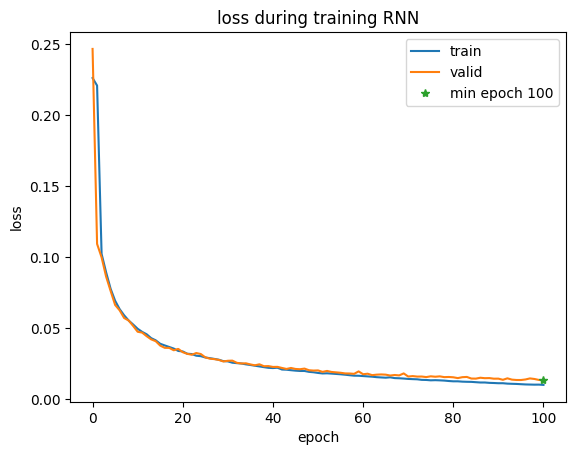

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.648  &0.687  &0.829  &0.522

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.852  &1.440  &1.200  &0.729

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.818  &0.513  &0.841  &0.965  &0.061  &0.899 &0.722 &0.048 &0.912

Epoch:101 [Train] Loss: 0.010 | [Valid] Loss: 0.013	SAVE MODEL: loss: 0.013 -> 0.013 | runtime: 1.219 ms
Epoch:102 [Train] Loss: 0.010 | [Valid] Loss: 0.014	EarlyStopping counter: 1 out of 30
Epoch:103 [Train] Loss: 0.010 | [Valid] Loss: 0.013	EarlyStopping counter: 2 out of 30
Epoch:104 [Train] Loss: 0.009 | [Valid] Loss: 0.013	SAVE MODEL: loss: 0.013 -> 0.013 | runtime: 1.177 ms
Epoch:105 [Train] Loss: 0.009 | [Valid] Loss: 0.014	EarlyStopping counter: 1 out of 30
Epoch:106 [Train] Loss: 0.009 | [Valid] Loss: 0.012	SAVE MODEL: loss: 0.013 -> 0.012 | runtime: 1.188 ms
Epoch:107 [Tra

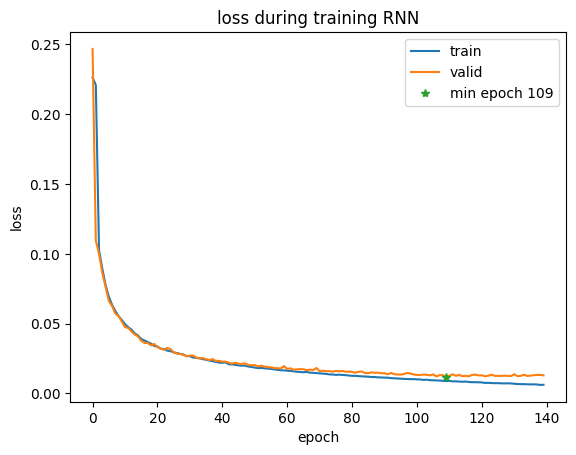

load pretrained model from  A3/uw/RNN_MT_2.pt
[Test] Loss: 0.023
*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.615  &0.633  &0.796  &0.571


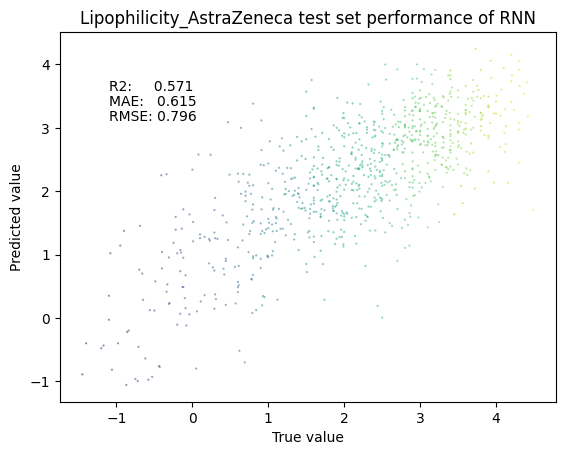


*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.788  &1.217  &1.103  &0.776


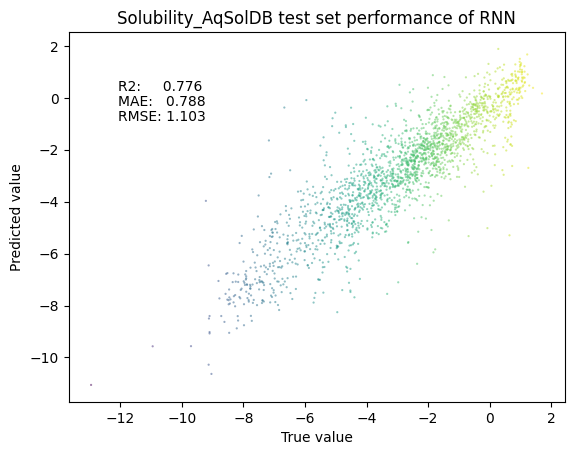


*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.850  &0.555  &0.860  &0.983  &0.127  &0.917 &0.771 &0.217 &0.944


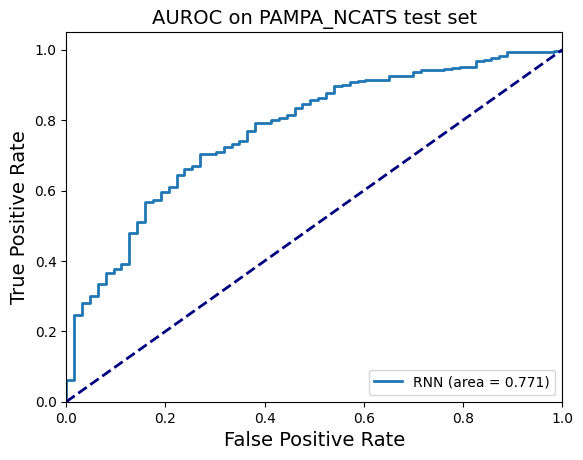

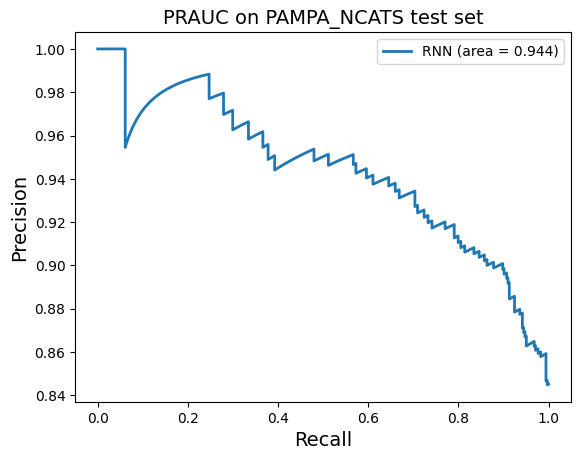

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!




--> Train status saved at A3/uw/RNN_MT_2.yml
Finished evaluate test performance, outputs performance dict
repeated num # 3 idx 1 has the lowest loss from [0.023807906321823023, 0.02209814555513171, 0.022978701427256547]
******************** Lipophilicity_AstraZeneca ******************** 
	|       mae      |       mse      |       rmse      |       r2      
	&0.606$\pm$0.022  &0.622$\pm$0.034  &0.788$\pm$0.022  &0.579$\pm$0.023  
 idx 1: &0.576            &0.575            &0.758            &0.611            

******************** Solubility_AqSolDB ******************** 
	|       mae      |       mse      |       rmse      |       r2      
	&0.796$\pm$0.013  &1.262$\pm$0.040  &1.123$\pm$0.018  &0.768$\pm$0.007  
 idx 1: &0.813            &1.313            &1.146            &0.758            

******************** PAMPA_NCATS ******************** 
	|       acc      |       w_acc      |       prec      |       recall      |       sp      |       f1      |       auc      |       mcc     

Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:0 [Train] Loss: 3.032 | KL Div: 111.984 | Recon: 3.032 | Classify: 0.578 | KL w: 0.000 | cls w: 0.000


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


Epoch:0 [Valid] Loss: 2.545 | KL Div: 201.040 | Recon: 2.545 | Classify: 0.575 | KL w: 0.000 | cls w: 0.000
# SAVE MODEL: loss: inf -> 2.545 | ## SAVE Enc, Dec, Cls: classify loss: inf -> 0.575  | runtime: 2.635 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:1 [Train] Loss: 2.590 | KL Div: 29.198 | Recon: 2.575 | Classify: 0.551 | KL w: 0.001 | cls w: 0.001


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.91it/s]


Epoch:1 [Valid] Loss: 2.553 | KL Div: 6.535 | Recon: 2.550 | Classify: 0.526 | KL w: 0.001 | cls w: 0.001
## SAVE Enc, Dec, Cls: classify loss: 0.575 -> 0.526  | runtime: 2.715 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:2 [Train] Loss: 2.568 | KL Div: 5.651 | Recon: 2.561 | Classify: 0.314 | KL w: 0.001 | cls w: 0.002


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.19it/s]


Epoch:2 [Valid] Loss: 2.544 | KL Div: 7.474 | Recon: 2.536 | Classify: 0.216 | KL w: 0.001 | cls w: 0.002
# SAVE MODEL: loss: 2.545 -> 2.544 | ## SAVE Enc, Dec, Cls: classify loss: 0.526 -> 0.216  | runtime: 2.671 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:3 [Train] Loss: 2.538 | KL Div: 6.226 | Recon: 2.529 | Classify: 0.161 | KL w: 0.002 | cls w: 0.003


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]


Epoch:3 [Valid] Loss: 2.436 | KL Div: 8.477 | Recon: 2.423 | Classify: 0.139 | KL w: 0.002 | cls w: 0.003
# SAVE MODEL: loss: 2.544 -> 2.436 | ## SAVE Enc, Dec, Cls: classify loss: 0.216 -> 0.139  | runtime: 2.651 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:4 [Train] Loss: 2.325 | KL Div: 6.838 | Recon: 2.310 | Classify: 0.129 | KL w: 0.002 | cls w: 0.004


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


Epoch:4 [Valid] Loss: 2.194 | KL Div: 5.714 | Recon: 2.182 | Classify: 0.120 | KL w: 0.002 | cls w: 0.004
# SAVE MODEL: loss: 2.436 -> 2.194 | ## SAVE Enc, Dec, Cls: classify loss: 0.139 -> 0.120  | runtime: 2.685 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:5 [Train] Loss: 2.057 | KL Div: 5.370 | Recon: 2.043 | Classify: 0.117 | KL w: 0.003 | cls w: 0.005


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.16it/s]


Epoch:5 [Valid] Loss: 1.881 | KL Div: 5.716 | Recon: 1.866 | Classify: 0.109 | KL w: 0.003 | cls w: 0.005
# SAVE MODEL: loss: 2.194 -> 1.881 | ## SAVE Enc, Dec, Cls: classify loss: 0.120 -> 0.109  | runtime: 2.681 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:6 [Train] Loss: 1.802 | KL Div: 4.246 | Recon: 1.789 | Classify: 0.111 | KL w: 0.003 | cls w: 0.006


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


Epoch:6 [Valid] Loss: 1.692 | KL Div: 4.419 | Recon: 1.679 | Classify: 0.113 | KL w: 0.003 | cls w: 0.006
# SAVE MODEL: loss: 1.881 -> 1.692 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:7 [Train] Loss: 1.646 | KL Div: 3.349 | Recon: 1.634 | Classify: 0.108 | KL w: 0.004 | cls w: 0.007


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.86it/s]


Epoch:7 [Valid] Loss: 1.555 | KL Div: 2.852 | Recon: 1.544 | Classify: 0.096 | KL w: 0.004 | cls w: 0.007
# SAVE MODEL: loss: 1.692 -> 1.555 | ## SAVE Enc, Dec, Cls: classify loss: 0.109 -> 0.096  | runtime: 2.693 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]


Epoch:8 [Train] Loss: 1.523 | KL Div: 2.277 | Recon: 1.514 | Classify: 0.101 | KL w: 0.004 | cls w: 0.008


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.45it/s]


Epoch:8 [Valid] Loss: 1.453 | KL Div: 2.025 | Recon: 1.444 | Classify: 0.099 | KL w: 0.004 | cls w: 0.008
# SAVE MODEL: loss: 1.555 -> 1.453 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:9 [Train] Loss: 1.432 | KL Div: 1.733 | Recon: 1.423 | Classify: 0.099 | KL w: 0.004 | cls w: 0.009


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.18it/s]


Epoch:9 [Valid] Loss: 1.373 | KL Div: 1.677 | Recon: 1.365 | Classify: 0.094 | KL w: 0.004 | cls w: 0.009
# SAVE MODEL: loss: 1.453 -> 1.373 | ## SAVE Enc, Dec, Cls: classify loss: 0.096 -> 0.094  | runtime: 2.637 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Epoch:10 [Train] Loss: 1.359 | KL Div: 1.411 | Recon: 1.351 | Classify: 0.097 | KL w: 0.005 | cls w: 0.010


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.59it/s]


Epoch:10 [Valid] Loss: 1.310 | KL Div: 1.441 | Recon: 1.302 | Classify: 0.091 | KL w: 0.005 | cls w: 0.010
# SAVE MODEL: loss: 1.373 -> 1.310 | ## SAVE Enc, Dec, Cls: classify loss: 0.094 -> 0.091  | runtime: 2.628 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:11 [Train] Loss: 1.303 | KL Div: 1.193 | Recon: 1.295 | Classify: 0.094 | KL w: 0.005 | cls w: 0.011


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.86it/s]


Epoch:11 [Valid] Loss: 1.264 | KL Div: 1.438 | Recon: 1.256 | Classify: 0.089 | KL w: 0.005 | cls w: 0.011
# SAVE MODEL: loss: 1.310 -> 1.264 | ## SAVE Enc, Dec, Cls: classify loss: 0.091 -> 0.089  | runtime: 2.688 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:12 [Train] Loss: 1.256 | KL Div: 1.068 | Recon: 1.248 | Classify: 0.092 | KL w: 0.006 | cls w: 0.012


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epoch:12 [Valid] Loss: 1.218 | KL Div: 0.998 | Recon: 1.211 | Classify: 0.087 | KL w: 0.006 | cls w: 0.012
# SAVE MODEL: loss: 1.264 -> 1.218 | ## SAVE Enc, Dec, Cls: classify loss: 0.089 -> 0.087  | runtime: 2.673 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:13 [Train] Loss: 1.213 | KL Div: 0.903 | Recon: 1.206 | Classify: 0.090 | KL w: 0.006 | cls w: 0.013


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]


Epoch:13 [Valid] Loss: 1.183 | KL Div: 0.847 | Recon: 1.177 | Classify: 0.085 | KL w: 0.006 | cls w: 0.013
# SAVE MODEL: loss: 1.218 -> 1.183 | ## SAVE Enc, Dec, Cls: classify loss: 0.087 -> 0.085  | runtime: 2.694 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:14 [Train] Loss: 1.180 | KL Div: 0.857 | Recon: 1.173 | Classify: 0.087 | KL w: 0.007 | cls w: 0.014


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]


Epoch:14 [Valid] Loss: 1.152 | KL Div: 0.873 | Recon: 1.145 | Classify: 0.083 | KL w: 0.007 | cls w: 0.014
# SAVE MODEL: loss: 1.183 -> 1.152 | ## SAVE Enc, Dec, Cls: classify loss: 0.085 -> 0.083  | runtime: 2.649 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.85it/s]


Epoch:15 [Train] Loss: 1.151 | KL Div: 0.774 | Recon: 1.144 | Classify: 0.086 | KL w: 0.007 | cls w: 0.015


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.62it/s]


Epoch:15 [Valid] Loss: 1.127 | KL Div: 0.807 | Recon: 1.120 | Classify: 0.081 | KL w: 0.007 | cls w: 0.015
# SAVE MODEL: loss: 1.152 -> 1.127 | ## SAVE Enc, Dec, Cls: classify loss: 0.083 -> 0.081  | runtime: 2.743 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.85it/s]


Epoch:16 [Train] Loss: 1.126 | KL Div: 0.717 | Recon: 1.119 | Classify: 0.083 | KL w: 0.008 | cls w: 0.016


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.43it/s]


Epoch:16 [Valid] Loss: 1.102 | KL Div: 0.628 | Recon: 1.096 | Classify: 0.080 | KL w: 0.008 | cls w: 0.016
# SAVE MODEL: loss: 1.127 -> 1.102 | ## SAVE Enc, Dec, Cls: classify loss: 0.081 -> 0.080  | runtime: 2.746 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:17 [Train] Loss: 1.104 | KL Div: 0.641 | Recon: 1.098 | Classify: 0.083 | KL w: 0.009 | cls w: 0.017


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]


Epoch:17 [Valid] Loss: 1.085 | KL Div: 0.736 | Recon: 1.078 | Classify: 0.077 | KL w: 0.009 | cls w: 0.017
# SAVE MODEL: loss: 1.102 -> 1.085 | ## SAVE Enc, Dec, Cls: classify loss: 0.080 -> 0.077  | runtime: 2.685 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Epoch:18 [Train] Loss: 1.084 | KL Div: 0.594 | Recon: 1.078 | Classify: 0.081 | KL w: 0.009 | cls w: 0.018


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]


Epoch:18 [Valid] Loss: 1.065 | KL Div: 0.552 | Recon: 1.058 | Classify: 0.077 | KL w: 0.009 | cls w: 0.018
# SAVE MODEL: loss: 1.085 -> 1.065 | ## SAVE Enc, Dec, Cls: classify loss: 0.077 -> 0.077  | runtime: 2.621 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:19 [Train] Loss: 1.066 | KL Div: 0.530 | Recon: 1.060 | Classify: 0.079 | KL w: 0.009 | cls w: 0.019


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]


Epoch:19 [Valid] Loss: 1.045 | KL Div: 0.543 | Recon: 1.038 | Classify: 0.073 | KL w: 0.009 | cls w: 0.019
# SAVE MODEL: loss: 1.065 -> 1.045 | ## SAVE Enc, Dec, Cls: classify loss: 0.077 -> 0.073  | runtime: 2.678 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:20 [Train] Loss: 1.050 | KL Div: 0.471 | Recon: 1.043 | Classify: 0.077 | KL w: 0.010 | cls w: 0.020


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Epoch:20 [Valid] Loss: 1.029 | KL Div: 0.448 | Recon: 1.023 | Classify: 0.073 | KL w: 0.010 | cls w: 0.020
# SAVE MODEL: loss: 1.045 -> 1.029 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]


Epoch:21 [Train] Loss: 1.032 | KL Div: 0.430 | Recon: 1.026 | Classify: 0.077 | KL w: 0.011 | cls w: 0.021


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.43it/s]


Epoch:21 [Valid] Loss: 1.011 | KL Div: 0.404 | Recon: 1.006 | Classify: 0.071 | KL w: 0.011 | cls w: 0.021
# SAVE MODEL: loss: 1.029 -> 1.011 | ## SAVE Enc, Dec, Cls: classify loss: 0.073 -> 0.071  | runtime: 2.736 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:22 [Train] Loss: 1.016 | KL Div: 0.370 | Recon: 1.010 | Classify: 0.075 | KL w: 0.011 | cls w: 0.022


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]


Epoch:22 [Valid] Loss: 0.998 | KL Div: 0.385 | Recon: 0.992 | Classify: 0.070 | KL w: 0.011 | cls w: 0.022
# SAVE MODEL: loss: 1.011 -> 0.998 | ## SAVE Enc, Dec, Cls: classify loss: 0.071 -> 0.070  | runtime: 2.636 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.85it/s]


Epoch:23 [Train] Loss: 1.000 | KL Div: 0.313 | Recon: 0.995 | Classify: 0.075 | KL w: 0.011 | cls w: 0.023


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]


Epoch:23 [Valid] Loss: 0.986 | KL Div: 0.327 | Recon: 0.980 | Classify: 0.072 | KL w: 0.011 | cls w: 0.023
# SAVE MODEL: loss: 0.998 -> 0.986 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:24 [Train] Loss: 0.987 | KL Div: 0.279 | Recon: 0.982 | Classify: 0.073 | KL w: 0.012 | cls w: 0.024


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.24it/s]


Epoch:24 [Valid] Loss: 0.976 | KL Div: 0.300 | Recon: 0.970 | Classify: 0.067 | KL w: 0.012 | cls w: 0.024
# SAVE MODEL: loss: 0.986 -> 0.976 | ## SAVE Enc, Dec, Cls: classify loss: 0.070 -> 0.067  | runtime: 2.664 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.93it/s]


Epoch:25 [Train] Loss: 0.975 | KL Div: 0.236 | Recon: 0.971 | Classify: 0.073 | KL w: 0.013 | cls w: 0.025


Valid: 100%|██████████| 13/13 [00:01<00:00,  8.12it/s]


Epoch:25 [Valid] Loss: 0.965 | KL Div: 0.220 | Recon: 0.961 | Classify: 0.068 | KL w: 0.013 | cls w: 0.025
# SAVE MODEL: loss: 0.976 -> 0.965 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:26 [Train] Loss: 0.965 | KL Div: 0.202 | Recon: 0.960 | Classify: 0.071 | KL w: 0.013 | cls w: 0.026


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.29it/s]


Epoch:26 [Valid] Loss: 0.955 | KL Div: 0.187 | Recon: 0.951 | Classify: 0.068 | KL w: 0.013 | cls w: 0.026
# SAVE MODEL: loss: 0.965 -> 0.955 | EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:27 [Train] Loss: 0.953 | KL Div: 0.182 | Recon: 0.949 | Classify: 0.070 | KL w: 0.013 | cls w: 0.027


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Epoch:27 [Valid] Loss: 0.944 | KL Div: 0.181 | Recon: 0.939 | Classify: 0.066 | KL w: 0.013 | cls w: 0.027
# SAVE MODEL: loss: 0.955 -> 0.944 | ## SAVE Enc, Dec, Cls: classify loss: 0.067 -> 0.066  | runtime: 2.719 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Epoch:28 [Train] Loss: 0.943 | KL Div: 0.147 | Recon: 0.939 | Classify: 0.069 | KL w: 0.014 | cls w: 0.028


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]


Epoch:28 [Valid] Loss: 0.934 | KL Div: 0.137 | Recon: 0.930 | Classify: 0.065 | KL w: 0.014 | cls w: 0.028
# SAVE MODEL: loss: 0.944 -> 0.934 | ## SAVE Enc, Dec, Cls: classify loss: 0.066 -> 0.065  | runtime: 2.631 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Epoch:29 [Train] Loss: 0.934 | KL Div: 0.128 | Recon: 0.930 | Classify: 0.069 | KL w: 0.015 | cls w: 0.029


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]


Epoch:29 [Valid] Loss: 0.927 | KL Div: 0.107 | Recon: 0.923 | Classify: 0.064 | KL w: 0.015 | cls w: 0.029
# SAVE MODEL: loss: 0.934 -> 0.927 | ## SAVE Enc, Dec, Cls: classify loss: 0.065 -> 0.064  | runtime: 2.619 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:30 [Train] Loss: 0.926 | KL Div: 0.108 | Recon: 0.922 | Classify: 0.068 | KL w: 0.015 | cls w: 0.030


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]


Epoch:30 [Valid] Loss: 0.919 | KL Div: 0.088 | Recon: 0.915 | Classify: 0.065 | KL w: 0.015 | cls w: 0.030
# SAVE MODEL: loss: 0.927 -> 0.919 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:31 [Train] Loss: 0.917 | KL Div: 0.091 | Recon: 0.914 | Classify: 0.066 | KL w: 0.015 | cls w: 0.031


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]


Epoch:31 [Valid] Loss: 0.909 | KL Div: 0.080 | Recon: 0.906 | Classify: 0.063 | KL w: 0.015 | cls w: 0.031
# SAVE MODEL: loss: 0.919 -> 0.909 | ## SAVE Enc, Dec, Cls: classify loss: 0.064 -> 0.063  | runtime: 2.656 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:32 [Train] Loss: 0.908 | KL Div: 0.077 | Recon: 0.904 | Classify: 0.066 | KL w: 0.016 | cls w: 0.032


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epoch:32 [Valid] Loss: 0.905 | KL Div: 0.067 | Recon: 0.901 | Classify: 0.062 | KL w: 0.016 | cls w: 0.032
# SAVE MODEL: loss: 0.909 -> 0.905 | ## SAVE Enc, Dec, Cls: classify loss: 0.063 -> 0.062  | runtime: 2.678 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Epoch:33 [Train] Loss: 0.900 | KL Div: 0.066 | Recon: 0.897 | Classify: 0.065 | KL w: 0.017 | cls w: 0.033


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Epoch:33 [Valid] Loss: 0.898 | KL Div: 0.062 | Recon: 0.895 | Classify: 0.062 | KL w: 0.017 | cls w: 0.033
# SAVE MODEL: loss: 0.905 -> 0.898 | ## SAVE Enc, Dec, Cls: classify loss: 0.062 -> 0.062  | runtime: 2.630 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:34 [Train] Loss: 0.892 | KL Div: 0.058 | Recon: 0.889 | Classify: 0.064 | KL w: 0.017 | cls w: 0.034


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Epoch:34 [Valid] Loss: 0.890 | KL Div: 0.050 | Recon: 0.887 | Classify: 0.061 | KL w: 0.017 | cls w: 0.034
# SAVE MODEL: loss: 0.898 -> 0.890 | ## SAVE Enc, Dec, Cls: classify loss: 0.062 -> 0.061  | runtime: 2.694 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:35 [Train] Loss: 0.885 | KL Div: 0.048 | Recon: 0.882 | Classify: 0.063 | KL w: 0.018 | cls w: 0.035


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s]


Epoch:35 [Valid] Loss: 0.886 | KL Div: 0.038 | Recon: 0.883 | Classify: 0.060 | KL w: 0.018 | cls w: 0.035
# SAVE MODEL: loss: 0.890 -> 0.886 | ## SAVE Enc, Dec, Cls: classify loss: 0.061 -> 0.060  | runtime: 2.687 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:36 [Train] Loss: 0.878 | KL Div: 0.038 | Recon: 0.875 | Classify: 0.063 | KL w: 0.018 | cls w: 0.036


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Epoch:36 [Valid] Loss: 0.876 | KL Div: 0.024 | Recon: 0.873 | Classify: 0.059 | KL w: 0.018 | cls w: 0.036
# SAVE MODEL: loss: 0.886 -> 0.876 | ## SAVE Enc, Dec, Cls: classify loss: 0.060 -> 0.059  | runtime: 2.690 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]


Epoch:37 [Train] Loss: 0.871 | KL Div: 0.031 | Recon: 0.869 | Classify: 0.062 | KL w: 0.018 | cls w: 0.037


Valid: 100%|██████████| 13/13 [00:01<00:00,  8.04it/s]


Epoch:37 [Valid] Loss: 0.871 | KL Div: 0.020 | Recon: 0.868 | Classify: 0.058 | KL w: 0.018 | cls w: 0.037
# SAVE MODEL: loss: 0.876 -> 0.871 | ## SAVE Enc, Dec, Cls: classify loss: 0.059 -> 0.058  | runtime: 2.737 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:38 [Train] Loss: 0.865 | KL Div: 0.027 | Recon: 0.862 | Classify: 0.061 | KL w: 0.019 | cls w: 0.038


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.44it/s]


Epoch:38 [Valid] Loss: 0.863 | KL Div: 0.018 | Recon: 0.861 | Classify: 0.057 | KL w: 0.019 | cls w: 0.038
# SAVE MODEL: loss: 0.871 -> 0.863 | ## SAVE Enc, Dec, Cls: classify loss: 0.058 -> 0.057  | runtime: 2.658 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:39 [Train] Loss: 0.859 | KL Div: 0.024 | Recon: 0.856 | Classify: 0.060 | KL w: 0.019 | cls w: 0.039


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.26it/s]


Epoch:39 [Valid] Loss: 0.859 | KL Div: 0.014 | Recon: 0.857 | Classify: 0.056 | KL w: 0.019 | cls w: 0.039
# SAVE MODEL: loss: 0.863 -> 0.859 | ## SAVE Enc, Dec, Cls: classify loss: 0.057 -> 0.056  | runtime: 2.664 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:40 [Train] Loss: 0.852 | KL Div: 0.021 | Recon: 0.849 | Classify: 0.059 | KL w: 0.020 | cls w: 0.040


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


Epoch:40 [Valid] Loss: 0.852 | KL Div: 0.011 | Recon: 0.850 | Classify: 0.057 | KL w: 0.020 | cls w: 0.040
# SAVE MODEL: loss: 0.859 -> 0.852 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:41 [Train] Loss: 0.846 | KL Div: 0.017 | Recon: 0.844 | Classify: 0.059 | KL w: 0.021 | cls w: 0.041


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epoch:41 [Valid] Loss: 0.850 | KL Div: 0.014 | Recon: 0.847 | Classify: 0.056 | KL w: 0.021 | cls w: 0.041
# SAVE MODEL: loss: 0.852 -> 0.850 | EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:42 [Train] Loss: 0.840 | KL Div: 0.016 | Recon: 0.838 | Classify: 0.058 | KL w: 0.021 | cls w: 0.042


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Epoch:42 [Valid] Loss: 0.845 | KL Div: 0.007 | Recon: 0.843 | Classify: 0.055 | KL w: 0.021 | cls w: 0.042
# SAVE MODEL: loss: 0.850 -> 0.845 | ## SAVE Enc, Dec, Cls: classify loss: 0.056 -> 0.055  | runtime: 2.674 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:43 [Train] Loss: 0.835 | KL Div: 0.014 | Recon: 0.832 | Classify: 0.058 | KL w: 0.021 | cls w: 0.043


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s]


Epoch:43 [Valid] Loss: 0.842 | KL Div: 0.008 | Recon: 0.839 | Classify: 0.056 | KL w: 0.021 | cls w: 0.043
# SAVE MODEL: loss: 0.845 -> 0.842 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]


Epoch:44 [Train] Loss: 0.830 | KL Div: 0.013 | Recon: 0.827 | Classify: 0.057 | KL w: 0.022 | cls w: 0.044


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


Epoch:44 [Valid] Loss: 0.835 | KL Div: 0.006 | Recon: 0.832 | Classify: 0.054 | KL w: 0.022 | cls w: 0.044
# SAVE MODEL: loss: 0.842 -> 0.835 | ## SAVE Enc, Dec, Cls: classify loss: 0.055 -> 0.054  | runtime: 2.588 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:45 [Train] Loss: 0.825 | KL Div: 0.011 | Recon: 0.822 | Classify: 0.056 | KL w: 0.022 | cls w: 0.045


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.22it/s]


Epoch:45 [Valid] Loss: 0.833 | KL Div: 0.006 | Recon: 0.830 | Classify: 0.053 | KL w: 0.022 | cls w: 0.045
# SAVE MODEL: loss: 0.835 -> 0.833 | ## SAVE Enc, Dec, Cls: classify loss: 0.054 -> 0.053  | runtime: 2.721 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:46 [Train] Loss: 0.820 | KL Div: 0.011 | Recon: 0.817 | Classify: 0.056 | KL w: 0.023 | cls w: 0.046


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]


Epoch:46 [Valid] Loss: 0.825 | KL Div: 0.005 | Recon: 0.823 | Classify: 0.053 | KL w: 0.023 | cls w: 0.046
# SAVE MODEL: loss: 0.833 -> 0.825 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.93it/s]


Epoch:47 [Train] Loss: 0.814 | KL Div: 0.010 | Recon: 0.811 | Classify: 0.054 | KL w: 0.024 | cls w: 0.047


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.25it/s]


Epoch:47 [Valid] Loss: 0.823 | KL Div: 0.004 | Recon: 0.820 | Classify: 0.052 | KL w: 0.024 | cls w: 0.047
# SAVE MODEL: loss: 0.825 -> 0.823 | ## SAVE Enc, Dec, Cls: classify loss: 0.053 -> 0.052  | runtime: 2.667 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:48 [Train] Loss: 0.809 | KL Div: 0.009 | Recon: 0.806 | Classify: 0.054 | KL w: 0.024 | cls w: 0.048


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.20it/s]


Epoch:48 [Valid] Loss: 0.819 | KL Div: 0.004 | Recon: 0.816 | Classify: 0.050 | KL w: 0.024 | cls w: 0.048
# SAVE MODEL: loss: 0.823 -> 0.819 | ## SAVE Enc, Dec, Cls: classify loss: 0.052 -> 0.050  | runtime: 2.642 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:49 [Train] Loss: 0.805 | KL Div: 0.008 | Recon: 0.802 | Classify: 0.053 | KL w: 0.025 | cls w: 0.049


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.32it/s]


Epoch:49 [Valid] Loss: 0.816 | KL Div: 0.004 | Recon: 0.813 | Classify: 0.049 | KL w: 0.025 | cls w: 0.049
# SAVE MODEL: loss: 0.819 -> 0.816 | ## SAVE Enc, Dec, Cls: classify loss: 0.050 -> 0.049  | runtime: 2.687 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:50 [Train] Loss: 0.800 | KL Div: 0.008 | Recon: 0.797 | Classify: 0.052 | KL w: 0.025 | cls w: 0.050


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.69it/s]


Epoch:50 [Valid] Loss: 0.812 | KL Div: 0.003 | Recon: 0.809 | Classify: 0.049 | KL w: 0.025 | cls w: 0.050
# SAVE MODEL: loss: 0.816 -> 0.812 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:51 [Train] Loss: 0.796 | KL Div: 0.007 | Recon: 0.793 | Classify: 0.052 | KL w: 0.025 | cls w: 0.051


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Epoch:51 [Valid] Loss: 0.811 | KL Div: 0.003 | Recon: 0.808 | Classify: 0.048 | KL w: 0.025 | cls w: 0.051
# SAVE MODEL: loss: 0.812 -> 0.811 | ## SAVE Enc, Dec, Cls: classify loss: 0.049 -> 0.048  | runtime: 2.642 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:52 [Train] Loss: 0.791 | KL Div: 0.007 | Recon: 0.788 | Classify: 0.051 | KL w: 0.026 | cls w: 0.052


Valid: 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]


Epoch:52 [Valid] Loss: 0.805 | KL Div: 0.003 | Recon: 0.802 | Classify: 0.048 | KL w: 0.026 | cls w: 0.052
# SAVE MODEL: loss: 0.811 -> 0.805 | ## SAVE Enc, Dec, Cls: classify loss: 0.048 -> 0.048  | runtime: 2.683 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:53 [Train] Loss: 0.787 | KL Div: 0.007 | Recon: 0.784 | Classify: 0.050 | KL w: 0.026 | cls w: 0.053


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]


Epoch:53 [Valid] Loss: 0.803 | KL Div: 0.002 | Recon: 0.800 | Classify: 0.047 | KL w: 0.026 | cls w: 0.053
# SAVE MODEL: loss: 0.805 -> 0.803 | ## SAVE Enc, Dec, Cls: classify loss: 0.048 -> 0.047  | runtime: 2.687 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:54 [Train] Loss: 0.783 | KL Div: 0.006 | Recon: 0.780 | Classify: 0.049 | KL w: 0.027 | cls w: 0.054


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Epoch:54 [Valid] Loss: 0.799 | KL Div: 0.002 | Recon: 0.796 | Classify: 0.046 | KL w: 0.027 | cls w: 0.054
# SAVE MODEL: loss: 0.803 -> 0.799 | ## SAVE Enc, Dec, Cls: classify loss: 0.047 -> 0.046  | runtime: 2.665 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:55 [Train] Loss: 0.778 | KL Div: 0.006 | Recon: 0.775 | Classify: 0.049 | KL w: 0.028 | cls w: 0.055


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.32it/s]


Epoch:55 [Valid] Loss: 0.795 | KL Div: 0.002 | Recon: 0.792 | Classify: 0.046 | KL w: 0.028 | cls w: 0.055
# SAVE MODEL: loss: 0.799 -> 0.795 | ## SAVE Enc, Dec, Cls: classify loss: 0.046 -> 0.046  | runtime: 2.684 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Epoch:56 [Train] Loss: 0.774 | KL Div: 0.006 | Recon: 0.771 | Classify: 0.048 | KL w: 0.028 | cls w: 0.056


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


Epoch:56 [Valid] Loss: 0.791 | KL Div: 0.003 | Recon: 0.788 | Classify: 0.044 | KL w: 0.028 | cls w: 0.056
# SAVE MODEL: loss: 0.795 -> 0.791 | ## SAVE Enc, Dec, Cls: classify loss: 0.046 -> 0.044  | runtime: 2.699 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:57 [Train] Loss: 0.771 | KL Div: 0.006 | Recon: 0.768 | Classify: 0.047 | KL w: 0.029 | cls w: 0.057


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.50it/s]


Epoch:57 [Valid] Loss: 0.787 | KL Div: 0.002 | Recon: 0.784 | Classify: 0.046 | KL w: 0.029 | cls w: 0.057
# SAVE MODEL: loss: 0.791 -> 0.787 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s]


Epoch:58 [Train] Loss: 0.766 | KL Div: 0.005 | Recon: 0.763 | Classify: 0.047 | KL w: 0.029 | cls w: 0.058


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Epoch:58 [Valid] Loss: 0.786 | KL Div: 0.002 | Recon: 0.783 | Classify: 0.045 | KL w: 0.029 | cls w: 0.058
# SAVE MODEL: loss: 0.787 -> 0.786 | EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:59 [Train] Loss: 0.762 | KL Div: 0.005 | Recon: 0.759 | Classify: 0.046 | KL w: 0.029 | cls w: 0.059


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.24it/s]


Epoch:59 [Valid] Loss: 0.782 | KL Div: 0.002 | Recon: 0.780 | Classify: 0.043 | KL w: 0.029 | cls w: 0.059
# SAVE MODEL: loss: 0.786 -> 0.782 | ## SAVE Enc, Dec, Cls: classify loss: 0.044 -> 0.043  | runtime: 2.682 ms


Train: 100%|██████████| 88/88 [00:28<00:00,  3.09it/s]


Epoch:60 [Train] Loss: 0.758 | KL Div: 0.005 | Recon: 0.755 | Classify: 0.046 | KL w: 0.030 | cls w: 0.060


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.31it/s]


Epoch:60 [Valid] Loss: 0.780 | KL Div: 0.002 | Recon: 0.777 | Classify: 0.042 | KL w: 0.030 | cls w: 0.060
# SAVE MODEL: loss: 0.782 -> 0.780 | ## SAVE Enc, Dec, Cls: classify loss: 0.043 -> 0.042  | runtime: 2.533 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s]


Epoch:61 [Train] Loss: 0.755 | KL Div: 0.005 | Recon: 0.752 | Classify: 0.045 | KL w: 0.030 | cls w: 0.061


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.21it/s]


Epoch:61 [Valid] Loss: 0.776 | KL Div: 0.002 | Recon: 0.774 | Classify: 0.041 | KL w: 0.030 | cls w: 0.061
# SAVE MODEL: loss: 0.780 -> 0.776 | ## SAVE Enc, Dec, Cls: classify loss: 0.042 -> 0.041  | runtime: 2.583 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


Epoch:62 [Train] Loss: 0.751 | KL Div: 0.004 | Recon: 0.748 | Classify: 0.044 | KL w: 0.031 | cls w: 0.062


Valid: 100%|██████████| 13/13 [00:02<00:00,  6.46it/s]


Epoch:62 [Valid] Loss: 0.773 | KL Div: 0.002 | Recon: 0.771 | Classify: 0.040 | KL w: 0.031 | cls w: 0.062
# SAVE MODEL: loss: 0.776 -> 0.773 | ## SAVE Enc, Dec, Cls: classify loss: 0.041 -> 0.040  | runtime: 2.725 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:63 [Train] Loss: 0.747 | KL Div: 0.005 | Recon: 0.744 | Classify: 0.044 | KL w: 0.032 | cls w: 0.063


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]


Epoch:63 [Valid] Loss: 0.770 | KL Div: 0.002 | Recon: 0.767 | Classify: 0.041 | KL w: 0.032 | cls w: 0.063
# SAVE MODEL: loss: 0.773 -> 0.770 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.84it/s]


Epoch:64 [Train] Loss: 0.744 | KL Div: 0.005 | Recon: 0.741 | Classify: 0.043 | KL w: 0.032 | cls w: 0.064


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]


Epoch:64 [Valid] Loss: 0.767 | KL Div: 0.002 | Recon: 0.765 | Classify: 0.041 | KL w: 0.032 | cls w: 0.064
# SAVE MODEL: loss: 0.770 -> 0.767 | EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:65 [Train] Loss: 0.739 | KL Div: 0.004 | Recon: 0.736 | Classify: 0.042 | KL w: 0.033 | cls w: 0.065


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]


Epoch:65 [Valid] Loss: 0.767 | KL Div: 0.002 | Recon: 0.764 | Classify: 0.040 | KL w: 0.033 | cls w: 0.065
# SAVE MODEL: loss: 0.767 -> 0.767 | ## SAVE Enc, Dec, Cls: classify loss: 0.040 -> 0.040  | runtime: 2.637 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:66 [Train] Loss: 0.737 | KL Div: 0.004 | Recon: 0.734 | Classify: 0.042 | KL w: 0.033 | cls w: 0.066


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]


Epoch:66 [Valid] Loss: 0.763 | KL Div: 0.002 | Recon: 0.761 | Classify: 0.039 | KL w: 0.033 | cls w: 0.066
# SAVE MODEL: loss: 0.767 -> 0.763 | ## SAVE Enc, Dec, Cls: classify loss: 0.040 -> 0.039  | runtime: 2.673 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


Epoch:67 [Train] Loss: 0.733 | KL Div: 0.004 | Recon: 0.731 | Classify: 0.042 | KL w: 0.034 | cls w: 0.067


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.55it/s]


Epoch:67 [Valid] Loss: 0.761 | KL Div: 0.002 | Recon: 0.758 | Classify: 0.039 | KL w: 0.034 | cls w: 0.067
# SAVE MODEL: loss: 0.763 -> 0.761 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:68 [Train] Loss: 0.730 | KL Div: 0.004 | Recon: 0.727 | Classify: 0.041 | KL w: 0.034 | cls w: 0.068


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Epoch:68 [Valid] Loss: 0.759 | KL Div: 0.002 | Recon: 0.757 | Classify: 0.039 | KL w: 0.034 | cls w: 0.068
# SAVE MODEL: loss: 0.761 -> 0.759 | ## SAVE Enc, Dec, Cls: classify loss: 0.039 -> 0.039  | runtime: 2.665 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:69 [Train] Loss: 0.726 | KL Div: 0.004 | Recon: 0.723 | Classify: 0.040 | KL w: 0.035 | cls w: 0.069


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.37it/s]


Epoch:69 [Valid] Loss: 0.755 | KL Div: 0.002 | Recon: 0.753 | Classify: 0.037 | KL w: 0.035 | cls w: 0.069
# SAVE MODEL: loss: 0.759 -> 0.755 | ## SAVE Enc, Dec, Cls: classify loss: 0.039 -> 0.037  | runtime: 2.657 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Epoch:70 [Train] Loss: 0.724 | KL Div: 0.004 | Recon: 0.721 | Classify: 0.039 | KL w: 0.035 | cls w: 0.070


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


Epoch:70 [Valid] Loss: 0.755 | KL Div: 0.002 | Recon: 0.752 | Classify: 0.036 | KL w: 0.035 | cls w: 0.070
# SAVE MODEL: loss: 0.755 -> 0.755 | ## SAVE Enc, Dec, Cls: classify loss: 0.037 -> 0.036  | runtime: 2.617 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


Epoch:71 [Train] Loss: 0.720 | KL Div: 0.004 | Recon: 0.717 | Classify: 0.039 | KL w: 0.035 | cls w: 0.071


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]


Epoch:71 [Valid] Loss: 0.751 | KL Div: 0.002 | Recon: 0.749 | Classify: 0.037 | KL w: 0.035 | cls w: 0.071
# SAVE MODEL: loss: 0.755 -> 0.751 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:72 [Train] Loss: 0.718 | KL Div: 0.004 | Recon: 0.715 | Classify: 0.039 | KL w: 0.036 | cls w: 0.072


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]


Epoch:72 [Valid] Loss: 0.750 | KL Div: 0.002 | Recon: 0.747 | Classify: 0.037 | KL w: 0.036 | cls w: 0.072
# SAVE MODEL: loss: 0.751 -> 0.750 | EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:73 [Train] Loss: 0.714 | KL Div: 0.004 | Recon: 0.711 | Classify: 0.038 | KL w: 0.036 | cls w: 0.073


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Epoch:73 [Valid] Loss: 0.749 | KL Div: 0.001 | Recon: 0.746 | Classify: 0.035 | KL w: 0.036 | cls w: 0.073
# SAVE MODEL: loss: 0.750 -> 0.749 | ## SAVE Enc, Dec, Cls: classify loss: 0.036 -> 0.035  | runtime: 2.671 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:74 [Train] Loss: 0.711 | KL Div: 0.004 | Recon: 0.708 | Classify: 0.037 | KL w: 0.037 | cls w: 0.074


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.42it/s]


Epoch:74 [Valid] Loss: 0.747 | KL Div: 0.001 | Recon: 0.744 | Classify: 0.034 | KL w: 0.037 | cls w: 0.074
# SAVE MODEL: loss: 0.749 -> 0.747 | ## SAVE Enc, Dec, Cls: classify loss: 0.035 -> 0.034  | runtime: 2.688 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:75 [Train] Loss: 0.708 | KL Div: 0.004 | Recon: 0.705 | Classify: 0.037 | KL w: 0.037 | cls w: 0.075


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]


Epoch:75 [Valid] Loss: 0.744 | KL Div: 0.002 | Recon: 0.742 | Classify: 0.035 | KL w: 0.037 | cls w: 0.075
# SAVE MODEL: loss: 0.747 -> 0.744 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:76 [Train] Loss: 0.705 | KL Div: 0.003 | Recon: 0.702 | Classify: 0.036 | KL w: 0.038 | cls w: 0.076


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.27it/s]


Epoch:76 [Valid] Loss: 0.743 | KL Div: 0.001 | Recon: 0.740 | Classify: 0.036 | KL w: 0.038 | cls w: 0.076
# SAVE MODEL: loss: 0.744 -> 0.743 | EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:77 [Train] Loss: 0.702 | KL Div: 0.003 | Recon: 0.699 | Classify: 0.036 | KL w: 0.038 | cls w: 0.077


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]


Epoch:77 [Valid] Loss: 0.741 | KL Div: 0.002 | Recon: 0.738 | Classify: 0.033 | KL w: 0.038 | cls w: 0.077
# SAVE MODEL: loss: 0.743 -> 0.741 | ## SAVE Enc, Dec, Cls: classify loss: 0.034 -> 0.033  | runtime: 2.694 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:78 [Train] Loss: 0.700 | KL Div: 0.003 | Recon: 0.697 | Classify: 0.036 | KL w: 0.039 | cls w: 0.078


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.00it/s]


Epoch:78 [Valid] Loss: 0.737 | KL Div: 0.002 | Recon: 0.735 | Classify: 0.033 | KL w: 0.039 | cls w: 0.078
# SAVE MODEL: loss: 0.741 -> 0.737 | ## SAVE Enc, Dec, Cls: classify loss: 0.033 -> 0.033  | runtime: 2.686 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:79 [Train] Loss: 0.696 | KL Div: 0.003 | Recon: 0.693 | Classify: 0.035 | KL w: 0.040 | cls w: 0.079


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]


Epoch:79 [Valid] Loss: 0.737 | KL Div: 0.001 | Recon: 0.734 | Classify: 0.033 | KL w: 0.040 | cls w: 0.079
# SAVE MODEL: loss: 0.737 -> 0.737 | ## SAVE Enc, Dec, Cls: classify loss: 0.033 -> 0.033  | runtime: 2.656 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:80 [Train] Loss: 0.694 | KL Div: 0.003 | Recon: 0.691 | Classify: 0.035 | KL w: 0.040 | cls w: 0.080


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]


Epoch:80 [Valid] Loss: 0.734 | KL Div: 0.001 | Recon: 0.732 | Classify: 0.032 | KL w: 0.040 | cls w: 0.080
# SAVE MODEL: loss: 0.737 -> 0.734 | ## SAVE Enc, Dec, Cls: classify loss: 0.033 -> 0.032  | runtime: 2.662 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:81 [Train] Loss: 0.690 | KL Div: 0.003 | Recon: 0.687 | Classify: 0.035 | KL w: 0.041 | cls w: 0.081


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]


Epoch:81 [Valid] Loss: 0.731 | KL Div: 0.001 | Recon: 0.728 | Classify: 0.035 | KL w: 0.041 | cls w: 0.081
# SAVE MODEL: loss: 0.734 -> 0.731 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Epoch:82 [Train] Loss: 0.689 | KL Div: 0.003 | Recon: 0.686 | Classify: 0.035 | KL w: 0.041 | cls w: 0.082


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.35it/s]


Epoch:82 [Valid] Loss: 0.730 | KL Div: 0.001 | Recon: 0.728 | Classify: 0.031 | KL w: 0.041 | cls w: 0.082
# SAVE MODEL: loss: 0.731 -> 0.730 | ## SAVE Enc, Dec, Cls: classify loss: 0.032 -> 0.031  | runtime: 2.631 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:83 [Train] Loss: 0.685 | KL Div: 0.003 | Recon: 0.682 | Classify: 0.034 | KL w: 0.042 | cls w: 0.083


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]


Epoch:83 [Valid] Loss: 0.730 | KL Div: 0.001 | Recon: 0.728 | Classify: 0.031 | KL w: 0.042 | cls w: 0.083
# SAVE MODEL: loss: 0.730 -> 0.730 | ## SAVE Enc, Dec, Cls: classify loss: 0.031 -> 0.031  | runtime: 2.706 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:84 [Train] Loss: 0.681 | KL Div: 0.003 | Recon: 0.679 | Classify: 0.033 | KL w: 0.042 | cls w: 0.084


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.03it/s]


Epoch:84 [Valid] Loss: 0.729 | KL Div: 0.001 | Recon: 0.726 | Classify: 0.032 | KL w: 0.042 | cls w: 0.084
# SAVE MODEL: loss: 0.730 -> 0.729 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


Epoch:85 [Train] Loss: 0.679 | KL Div: 0.003 | Recon: 0.676 | Classify: 0.033 | KL w: 0.043 | cls w: 0.085


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.50it/s]


Epoch:85 [Valid] Loss: 0.725 | KL Div: 0.002 | Recon: 0.722 | Classify: 0.030 | KL w: 0.043 | cls w: 0.085
# SAVE MODEL: loss: 0.729 -> 0.725 | ## SAVE Enc, Dec, Cls: classify loss: 0.031 -> 0.030  | runtime: 2.725 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:86 [Train] Loss: 0.676 | KL Div: 0.003 | Recon: 0.673 | Classify: 0.033 | KL w: 0.043 | cls w: 0.086


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]


Epoch:86 [Valid] Loss: 0.724 | KL Div: 0.001 | Recon: 0.722 | Classify: 0.030 | KL w: 0.043 | cls w: 0.086
# SAVE MODEL: loss: 0.725 -> 0.724 | ## SAVE Enc, Dec, Cls: classify loss: 0.030 -> 0.030  | runtime: 2.654 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Epoch:87 [Train] Loss: 0.673 | KL Div: 0.003 | Recon: 0.670 | Classify: 0.032 | KL w: 0.043 | cls w: 0.087


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


Epoch:87 [Valid] Loss: 0.728 | KL Div: 0.001 | Recon: 0.725 | Classify: 0.029 | KL w: 0.043 | cls w: 0.087
## SAVE Enc, Dec, Cls: classify loss: 0.030 -> 0.029  | runtime: 2.628 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


Epoch:88 [Train] Loss: 0.671 | KL Div: 0.003 | Recon: 0.668 | Classify: 0.032 | KL w: 0.044 | cls w: 0.088


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.30it/s]


Epoch:88 [Valid] Loss: 0.721 | KL Div: 0.001 | Recon: 0.718 | Classify: 0.029 | KL w: 0.044 | cls w: 0.088
# SAVE MODEL: loss: 0.724 -> 0.721 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:89 [Train] Loss: 0.668 | KL Div: 0.003 | Recon: 0.665 | Classify: 0.031 | KL w: 0.044 | cls w: 0.089


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.26it/s]


Epoch:89 [Valid] Loss: 0.723 | KL Div: 0.001 | Recon: 0.720 | Classify: 0.029 | KL w: 0.044 | cls w: 0.089
## SAVE Enc, Dec, Cls: classify loss: 0.029 -> 0.029  | runtime: 2.640 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:90 [Train] Loss: 0.666 | KL Div: 0.003 | Recon: 0.663 | Classify: 0.032 | KL w: 0.045 | cls w: 0.090


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]


Epoch:90 [Valid] Loss: 0.717 | KL Div: 0.001 | Recon: 0.714 | Classify: 0.029 | KL w: 0.045 | cls w: 0.090
# SAVE MODEL: loss: 0.721 -> 0.717 | ## SAVE Enc, Dec, Cls: classify loss: 0.029 -> 0.029  | runtime: 2.658 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Epoch:91 [Train] Loss: 0.663 | KL Div: 0.003 | Recon: 0.660 | Classify: 0.031 | KL w: 0.045 | cls w: 0.091


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Epoch:91 [Valid] Loss: 0.716 | KL Div: 0.001 | Recon: 0.713 | Classify: 0.028 | KL w: 0.045 | cls w: 0.091
# SAVE MODEL: loss: 0.717 -> 0.716 | ## SAVE Enc, Dec, Cls: classify loss: 0.029 -> 0.028  | runtime: 2.620 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:92 [Train] Loss: 0.661 | KL Div: 0.003 | Recon: 0.658 | Classify: 0.031 | KL w: 0.046 | cls w: 0.092


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Epoch:92 [Valid] Loss: 0.715 | KL Div: 0.002 | Recon: 0.713 | Classify: 0.028 | KL w: 0.046 | cls w: 0.092
# SAVE MODEL: loss: 0.716 -> 0.715 | ## SAVE Enc, Dec, Cls: classify loss: 0.028 -> 0.028  | runtime: 2.661 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


Epoch:93 [Train] Loss: 0.658 | KL Div: 0.003 | Recon: 0.655 | Classify: 0.031 | KL w: 0.046 | cls w: 0.093


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]


Epoch:93 [Valid] Loss: 0.714 | KL Div: 0.001 | Recon: 0.711 | Classify: 0.027 | KL w: 0.046 | cls w: 0.093
# SAVE MODEL: loss: 0.715 -> 0.714 | ## SAVE Enc, Dec, Cls: classify loss: 0.028 -> 0.027  | runtime: 2.729 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:94 [Train] Loss: 0.656 | KL Div: 0.003 | Recon: 0.653 | Classify: 0.031 | KL w: 0.047 | cls w: 0.094


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


Epoch:94 [Valid] Loss: 0.715 | KL Div: 0.001 | Recon: 0.712 | Classify: 0.029 | KL w: 0.047 | cls w: 0.094
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:95 [Train] Loss: 0.654 | KL Div: 0.003 | Recon: 0.651 | Classify: 0.030 | KL w: 0.048 | cls w: 0.095


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]


Epoch:95 [Valid] Loss: 0.714 | KL Div: 0.001 | Recon: 0.711 | Classify: 0.027 | KL w: 0.048 | cls w: 0.095
# SAVE MODEL: loss: 0.714 -> 0.714 | ## SAVE Enc, Dec, Cls: classify loss: 0.027 -> 0.027  | runtime: 2.672 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:96 [Train] Loss: 0.651 | KL Div: 0.002 | Recon: 0.648 | Classify: 0.030 | KL w: 0.048 | cls w: 0.096


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]


Epoch:96 [Valid] Loss: 0.709 | KL Div: 0.001 | Recon: 0.706 | Classify: 0.026 | KL w: 0.048 | cls w: 0.096
# SAVE MODEL: loss: 0.714 -> 0.709 | ## SAVE Enc, Dec, Cls: classify loss: 0.027 -> 0.026  | runtime: 2.658 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:97 [Train] Loss: 0.648 | KL Div: 0.002 | Recon: 0.645 | Classify: 0.030 | KL w: 0.049 | cls w: 0.097


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.25it/s]


Epoch:97 [Valid] Loss: 0.710 | KL Div: 0.001 | Recon: 0.707 | Classify: 0.028 | KL w: 0.049 | cls w: 0.097
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:98 [Train] Loss: 0.647 | KL Div: 0.002 | Recon: 0.644 | Classify: 0.029 | KL w: 0.049 | cls w: 0.098


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]


Epoch:98 [Valid] Loss: 0.708 | KL Div: 0.001 | Recon: 0.705 | Classify: 0.027 | KL w: 0.049 | cls w: 0.098
# SAVE MODEL: loss: 0.709 -> 0.708 | EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:99 [Train] Loss: 0.643 | KL Div: 0.002 | Recon: 0.640 | Classify: 0.028 | KL w: 0.050 | cls w: 0.099


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.03it/s]


Epoch:99 [Valid] Loss: 0.706 | KL Div: 0.001 | Recon: 0.703 | Classify: 0.027 | KL w: 0.050 | cls w: 0.099
# SAVE MODEL: loss: 0.708 -> 0.706 | EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:100 [Train] Loss: 0.641 | KL Div: 0.002 | Recon: 0.638 | Classify: 0.028 | KL w: 0.050 | cls w: 0.100


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.11it/s]


Epoch:100 [Valid] Loss: 0.706 | KL Div: 0.001 | Recon: 0.703 | Classify: 0.026 | KL w: 0.050 | cls w: 0.100
## SAVE Enc, Dec, Cls: classify loss: 0.026 -> 0.026  | runtime: 2.670 ms
Train time: 2.672+/-0.038 ms
different task weight ['0.320', '0.653', '0.027']


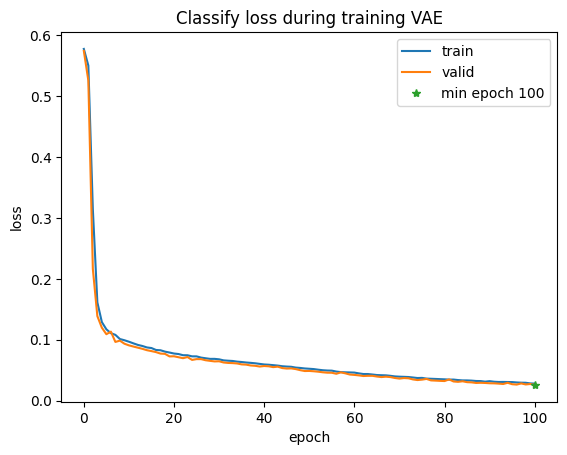

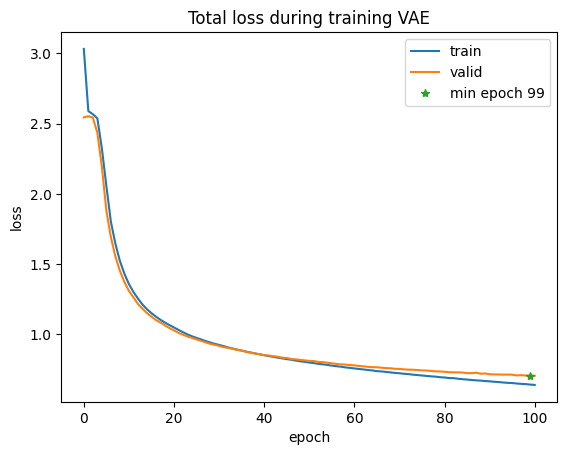

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.819  &0.999  &0.999  &0.305

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.971  &1.768  &1.330  &0.667

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.837  &0.500  &0.837  &1.000  &0.000  &0.912 &0.664 &  nan &0.895



Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:101 [Train] Loss: 0.639 | KL Div: 0.002 | Recon: 0.636 | Classify: 0.028 | KL w: 0.051 | cls w: 0.101


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]


Epoch:101 [Valid] Loss: 0.704 | KL Div: 0.001 | Recon: 0.701 | Classify: 0.030 | KL w: 0.051 | cls w: 0.101
# SAVE MODEL: loss: 0.706 -> 0.704 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:102 [Train] Loss: 0.636 | KL Div: 0.002 | Recon: 0.633 | Classify: 0.028 | KL w: 0.051 | cls w: 0.102


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.98it/s]


Epoch:102 [Valid] Loss: 0.703 | KL Div: 0.001 | Recon: 0.700 | Classify: 0.026 | KL w: 0.051 | cls w: 0.102
# SAVE MODEL: loss: 0.704 -> 0.703 | EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:103 [Train] Loss: 0.633 | KL Div: 0.002 | Recon: 0.630 | Classify: 0.027 | KL w: 0.051 | cls w: 0.103


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


Epoch:103 [Valid] Loss: 0.702 | KL Div: 0.001 | Recon: 0.700 | Classify: 0.025 | KL w: 0.051 | cls w: 0.103
# SAVE MODEL: loss: 0.703 -> 0.702 | ## SAVE Enc, Dec, Cls: classify loss: 0.026 -> 0.025  | runtime: 2.704 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Epoch:104 [Train] Loss: 0.632 | KL Div: 0.002 | Recon: 0.629 | Classify: 0.027 | KL w: 0.052 | cls w: 0.104


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.77it/s]


Epoch:104 [Valid] Loss: 0.702 | KL Div: 0.001 | Recon: 0.699 | Classify: 0.026 | KL w: 0.052 | cls w: 0.104
# SAVE MODEL: loss: 0.702 -> 0.702 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:105 [Train] Loss: 0.629 | KL Div: 0.002 | Recon: 0.626 | Classify: 0.027 | KL w: 0.052 | cls w: 0.105


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]


Epoch:105 [Valid] Loss: 0.702 | KL Div: 0.001 | Recon: 0.699 | Classify: 0.025 | KL w: 0.052 | cls w: 0.105
# SAVE MODEL: loss: 0.702 -> 0.702 | ## SAVE Enc, Dec, Cls: classify loss: 0.025 -> 0.025  | runtime: 2.662 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:106 [Train] Loss: 0.628 | KL Div: 0.002 | Recon: 0.625 | Classify: 0.027 | KL w: 0.053 | cls w: 0.106


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.30it/s]


Epoch:106 [Valid] Loss: 0.700 | KL Div: 0.001 | Recon: 0.697 | Classify: 0.025 | KL w: 0.053 | cls w: 0.106
# SAVE MODEL: loss: 0.702 -> 0.700 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:107 [Train] Loss: 0.626 | KL Div: 0.002 | Recon: 0.623 | Classify: 0.027 | KL w: 0.053 | cls w: 0.107


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Epoch:107 [Valid] Loss: 0.697 | KL Div: 0.001 | Recon: 0.695 | Classify: 0.025 | KL w: 0.053 | cls w: 0.107
# SAVE MODEL: loss: 0.700 -> 0.697 | ## SAVE Enc, Dec, Cls: classify loss: 0.025 -> 0.025  | runtime: 2.637 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:108 [Train] Loss: 0.623 | KL Div: 0.002 | Recon: 0.620 | Classify: 0.026 | KL w: 0.054 | cls w: 0.108


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]


Epoch:108 [Valid] Loss: 0.696 | KL Div: 0.001 | Recon: 0.693 | Classify: 0.024 | KL w: 0.054 | cls w: 0.108
# SAVE MODEL: loss: 0.697 -> 0.696 | ## SAVE Enc, Dec, Cls: classify loss: 0.025 -> 0.024  | runtime: 2.673 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:109 [Train] Loss: 0.620 | KL Div: 0.002 | Recon: 0.618 | Classify: 0.026 | KL w: 0.054 | cls w: 0.109


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]


Epoch:109 [Valid] Loss: 0.697 | KL Div: 0.001 | Recon: 0.695 | Classify: 0.024 | KL w: 0.054 | cls w: 0.109
## SAVE Enc, Dec, Cls: classify loss: 0.024 -> 0.024  | runtime: 2.661 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:110 [Train] Loss: 0.618 | KL Div: 0.002 | Recon: 0.615 | Classify: 0.026 | KL w: 0.055 | cls w: 0.110


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


Epoch:110 [Valid] Loss: 0.698 | KL Div: 0.001 | Recon: 0.695 | Classify: 0.024 | KL w: 0.055 | cls w: 0.110
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:111 [Train] Loss: 0.616 | KL Div: 0.002 | Recon: 0.613 | Classify: 0.025 | KL w: 0.056 | cls w: 0.111


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.33it/s]


Epoch:111 [Valid] Loss: 0.692 | KL Div: 0.001 | Recon: 0.689 | Classify: 0.024 | KL w: 0.056 | cls w: 0.111
# SAVE MODEL: loss: 0.696 -> 0.692 | ## SAVE Enc, Dec, Cls: classify loss: 0.024 -> 0.024  | runtime: 2.714 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:112 [Train] Loss: 0.614 | KL Div: 0.002 | Recon: 0.611 | Classify: 0.026 | KL w: 0.056 | cls w: 0.112


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]


Epoch:112 [Valid] Loss: 0.694 | KL Div: 0.001 | Recon: 0.691 | Classify: 0.024 | KL w: 0.056 | cls w: 0.112
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:113 [Train] Loss: 0.612 | KL Div: 0.002 | Recon: 0.609 | Classify: 0.025 | KL w: 0.057 | cls w: 0.113


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Epoch:113 [Valid] Loss: 0.693 | KL Div: 0.001 | Recon: 0.691 | Classify: 0.022 | KL w: 0.057 | cls w: 0.113
## SAVE Enc, Dec, Cls: classify loss: 0.024 -> 0.022  | runtime: 2.656 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:114 [Train] Loss: 0.610 | KL Div: 0.002 | Recon: 0.607 | Classify: 0.025 | KL w: 0.057 | cls w: 0.114


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.02it/s]


Epoch:114 [Valid] Loss: 0.693 | KL Div: 0.001 | Recon: 0.691 | Classify: 0.022 | KL w: 0.057 | cls w: 0.114
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


Epoch:115 [Train] Loss: 0.608 | KL Div: 0.002 | Recon: 0.605 | Classify: 0.024 | KL w: 0.058 | cls w: 0.115


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Epoch:115 [Valid] Loss: 0.694 | KL Div: 0.001 | Recon: 0.691 | Classify: 0.024 | KL w: 0.058 | cls w: 0.115
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Epoch:116 [Train] Loss: 0.606 | KL Div: 0.002 | Recon: 0.603 | Classify: 0.025 | KL w: 0.058 | cls w: 0.116


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]


Epoch:116 [Valid] Loss: 0.691 | KL Div: 0.001 | Recon: 0.689 | Classify: 0.024 | KL w: 0.058 | cls w: 0.116
# SAVE MODEL: loss: 0.692 -> 0.691 | EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:117 [Train] Loss: 0.603 | KL Div: 0.002 | Recon: 0.600 | Classify: 0.024 | KL w: 0.059 | cls w: 0.117


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]


Epoch:117 [Valid] Loss: 0.691 | KL Div: 0.001 | Recon: 0.688 | Classify: 0.022 | KL w: 0.059 | cls w: 0.117
# SAVE MODEL: loss: 0.691 -> 0.691 | ## SAVE Enc, Dec, Cls: classify loss: 0.022 -> 0.022  | runtime: 2.656 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:118 [Train] Loss: 0.601 | KL Div: 0.002 | Recon: 0.598 | Classify: 0.023 | KL w: 0.059 | cls w: 0.118


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.86it/s]


Epoch:118 [Valid] Loss: 0.691 | KL Div: 0.001 | Recon: 0.689 | Classify: 0.022 | KL w: 0.059 | cls w: 0.118
## SAVE Enc, Dec, Cls: classify loss: 0.022 -> 0.022  | runtime: 2.671 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:119 [Train] Loss: 0.599 | KL Div: 0.002 | Recon: 0.596 | Classify: 0.023 | KL w: 0.059 | cls w: 0.119


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.51it/s]


Epoch:119 [Valid] Loss: 0.687 | KL Div: 0.001 | Recon: 0.684 | Classify: 0.023 | KL w: 0.059 | cls w: 0.119
# SAVE MODEL: loss: 0.691 -> 0.687 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


Epoch:120 [Train] Loss: 0.597 | KL Div: 0.002 | Recon: 0.594 | Classify: 0.023 | KL w: 0.060 | cls w: 0.120


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Epoch:120 [Valid] Loss: 0.690 | KL Div: 0.001 | Recon: 0.687 | Classify: 0.022 | KL w: 0.060 | cls w: 0.120
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:121 [Train] Loss: 0.595 | KL Div: 0.002 | Recon: 0.592 | Classify: 0.023 | KL w: 0.060 | cls w: 0.121


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]


Epoch:121 [Valid] Loss: 0.688 | KL Div: 0.001 | Recon: 0.685 | Classify: 0.021 | KL w: 0.060 | cls w: 0.121
## SAVE Enc, Dec, Cls: classify loss: 0.022 -> 0.021  | runtime: 2.712 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Epoch:122 [Train] Loss: 0.593 | KL Div: 0.002 | Recon: 0.590 | Classify: 0.023 | KL w: 0.061 | cls w: 0.122


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.03it/s]


Epoch:122 [Valid] Loss: 0.686 | KL Div: 0.001 | Recon: 0.683 | Classify: 0.021 | KL w: 0.061 | cls w: 0.122
# SAVE MODEL: loss: 0.687 -> 0.686 | ## SAVE Enc, Dec, Cls: classify loss: 0.021 -> 0.021  | runtime: 2.696 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:123 [Train] Loss: 0.591 | KL Div: 0.002 | Recon: 0.588 | Classify: 0.023 | KL w: 0.061 | cls w: 0.123


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Epoch:123 [Valid] Loss: 0.686 | KL Div: 0.001 | Recon: 0.684 | Classify: 0.022 | KL w: 0.061 | cls w: 0.123
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:124 [Train] Loss: 0.589 | KL Div: 0.002 | Recon: 0.586 | Classify: 0.023 | KL w: 0.062 | cls w: 0.124


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Epoch:124 [Valid] Loss: 0.686 | KL Div: 0.001 | Recon: 0.683 | Classify: 0.021 | KL w: 0.062 | cls w: 0.124
# SAVE MODEL: loss: 0.686 -> 0.686 | EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:125 [Train] Loss: 0.587 | KL Div: 0.002 | Recon: 0.584 | Classify: 0.022 | KL w: 0.062 | cls w: 0.125


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]


Epoch:125 [Valid] Loss: 0.685 | KL Div: 0.001 | Recon: 0.683 | Classify: 0.021 | KL w: 0.062 | cls w: 0.125
# SAVE MODEL: loss: 0.686 -> 0.685 | ## SAVE Enc, Dec, Cls: classify loss: 0.021 -> 0.021  | runtime: 2.652 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:126 [Train] Loss: 0.585 | KL Div: 0.002 | Recon: 0.582 | Classify: 0.022 | KL w: 0.063 | cls w: 0.126


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]


Epoch:126 [Valid] Loss: 0.683 | KL Div: 0.001 | Recon: 0.681 | Classify: 0.021 | KL w: 0.063 | cls w: 0.126
# SAVE MODEL: loss: 0.685 -> 0.683 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:127 [Train] Loss: 0.583 | KL Div: 0.002 | Recon: 0.580 | Classify: 0.022 | KL w: 0.064 | cls w: 0.127


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]


Epoch:127 [Valid] Loss: 0.684 | KL Div: 0.001 | Recon: 0.682 | Classify: 0.021 | KL w: 0.064 | cls w: 0.127
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:128 [Train] Loss: 0.581 | KL Div: 0.002 | Recon: 0.578 | Classify: 0.022 | KL w: 0.064 | cls w: 0.128


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.99it/s]


Epoch:128 [Valid] Loss: 0.684 | KL Div: 0.001 | Recon: 0.681 | Classify: 0.021 | KL w: 0.064 | cls w: 0.128
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:129 [Train] Loss: 0.580 | KL Div: 0.002 | Recon: 0.577 | Classify: 0.021 | KL w: 0.065 | cls w: 0.129


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.19it/s]


Epoch:129 [Valid] Loss: 0.685 | KL Div: 0.001 | Recon: 0.683 | Classify: 0.020 | KL w: 0.065 | cls w: 0.129
## SAVE Enc, Dec, Cls: classify loss: 0.021 -> 0.020  | runtime: 2.675 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


Epoch:130 [Train] Loss: 0.577 | KL Div: 0.002 | Recon: 0.575 | Classify: 0.022 | KL w: 0.065 | cls w: 0.130


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]


Epoch:130 [Valid] Loss: 0.682 | KL Div: 0.001 | Recon: 0.679 | Classify: 0.022 | KL w: 0.065 | cls w: 0.130
# SAVE MODEL: loss: 0.683 -> 0.682 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Epoch:131 [Train] Loss: 0.576 | KL Div: 0.002 | Recon: 0.573 | Classify: 0.021 | KL w: 0.066 | cls w: 0.131


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Epoch:131 [Valid] Loss: 0.683 | KL Div: 0.001 | Recon: 0.680 | Classify: 0.020 | KL w: 0.066 | cls w: 0.131
## SAVE Enc, Dec, Cls: classify loss: 0.020 -> 0.020  | runtime: 2.625 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:132 [Train] Loss: 0.574 | KL Div: 0.002 | Recon: 0.571 | Classify: 0.020 | KL w: 0.066 | cls w: 0.132


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]


Epoch:132 [Valid] Loss: 0.681 | KL Div: 0.001 | Recon: 0.678 | Classify: 0.019 | KL w: 0.066 | cls w: 0.132
# SAVE MODEL: loss: 0.682 -> 0.681 | ## SAVE Enc, Dec, Cls: classify loss: 0.020 -> 0.019  | runtime: 2.693 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:133 [Train] Loss: 0.571 | KL Div: 0.002 | Recon: 0.568 | Classify: 0.021 | KL w: 0.067 | cls w: 0.133


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.47it/s]


Epoch:133 [Valid] Loss: 0.679 | KL Div: 0.001 | Recon: 0.677 | Classify: 0.020 | KL w: 0.067 | cls w: 0.133
# SAVE MODEL: loss: 0.681 -> 0.679 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]


Epoch:134 [Train] Loss: 0.571 | KL Div: 0.002 | Recon: 0.568 | Classify: 0.020 | KL w: 0.067 | cls w: 0.134


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


Epoch:134 [Valid] Loss: 0.683 | KL Div: 0.001 | Recon: 0.680 | Classify: 0.020 | KL w: 0.067 | cls w: 0.134
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Epoch:135 [Train] Loss: 0.568 | KL Div: 0.002 | Recon: 0.565 | Classify: 0.021 | KL w: 0.068 | cls w: 0.135


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]


Epoch:135 [Valid] Loss: 0.682 | KL Div: 0.001 | Recon: 0.679 | Classify: 0.020 | KL w: 0.068 | cls w: 0.135
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:136 [Train] Loss: 0.566 | KL Div: 0.002 | Recon: 0.563 | Classify: 0.020 | KL w: 0.068 | cls w: 0.136


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]


Epoch:136 [Valid] Loss: 0.682 | KL Div: 0.001 | Recon: 0.679 | Classify: 0.019 | KL w: 0.068 | cls w: 0.136
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:137 [Train] Loss: 0.565 | KL Div: 0.002 | Recon: 0.562 | Classify: 0.020 | KL w: 0.069 | cls w: 0.137


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


Epoch:137 [Valid] Loss: 0.680 | KL Div: 0.001 | Recon: 0.677 | Classify: 0.019 | KL w: 0.069 | cls w: 0.137
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:138 [Train] Loss: 0.562 | KL Div: 0.002 | Recon: 0.559 | Classify: 0.020 | KL w: 0.069 | cls w: 0.138


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]


Epoch:138 [Valid] Loss: 0.686 | KL Div: 0.001 | Recon: 0.683 | Classify: 0.020 | KL w: 0.069 | cls w: 0.138
EarlyStopping counter: 6 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:139 [Train] Loss: 0.561 | KL Div: 0.002 | Recon: 0.558 | Classify: 0.020 | KL w: 0.070 | cls w: 0.139


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]


Epoch:139 [Valid] Loss: 0.680 | KL Div: 0.001 | Recon: 0.678 | Classify: 0.019 | KL w: 0.070 | cls w: 0.139
## SAVE Enc, Dec, Cls: classify loss: 0.019 -> 0.019  | runtime: 2.649 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:140 [Train] Loss: 0.559 | KL Div: 0.002 | Recon: 0.556 | Classify: 0.020 | KL w: 0.070 | cls w: 0.140


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]


Epoch:140 [Valid] Loss: 0.679 | KL Div: 0.001 | Recon: 0.676 | Classify: 0.019 | KL w: 0.070 | cls w: 0.140
# SAVE MODEL: loss: 0.679 -> 0.679 | ## SAVE Enc, Dec, Cls: classify loss: 0.019 -> 0.019  | runtime: 2.679 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:141 [Train] Loss: 0.557 | KL Div: 0.001 | Recon: 0.554 | Classify: 0.019 | KL w: 0.070 | cls w: 0.141


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


Epoch:141 [Valid] Loss: 0.676 | KL Div: 0.001 | Recon: 0.673 | Classify: 0.019 | KL w: 0.070 | cls w: 0.141
# SAVE MODEL: loss: 0.679 -> 0.676 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Epoch:142 [Train] Loss: 0.555 | KL Div: 0.001 | Recon: 0.552 | Classify: 0.020 | KL w: 0.071 | cls w: 0.142


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]


Epoch:142 [Valid] Loss: 0.679 | KL Div: 0.001 | Recon: 0.677 | Classify: 0.019 | KL w: 0.071 | cls w: 0.142
## SAVE Enc, Dec, Cls: classify loss: 0.019 -> 0.019  | runtime: 2.620 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:143 [Train] Loss: 0.554 | KL Div: 0.001 | Recon: 0.551 | Classify: 0.019 | KL w: 0.071 | cls w: 0.143


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epoch:143 [Valid] Loss: 0.679 | KL Div: 0.001 | Recon: 0.676 | Classify: 0.019 | KL w: 0.071 | cls w: 0.143
## SAVE Enc, Dec, Cls: classify loss: 0.019 -> 0.019  | runtime: 2.690 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s]


Epoch:144 [Train] Loss: 0.551 | KL Div: 0.002 | Recon: 0.548 | Classify: 0.019 | KL w: 0.072 | cls w: 0.144


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


Epoch:144 [Valid] Loss: 0.676 | KL Div: 0.001 | Recon: 0.673 | Classify: 0.019 | KL w: 0.072 | cls w: 0.144
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s]


Epoch:145 [Train] Loss: 0.550 | KL Div: 0.001 | Recon: 0.547 | Classify: 0.019 | KL w: 0.072 | cls w: 0.145


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.94it/s]


Epoch:145 [Valid] Loss: 0.679 | KL Div: 0.001 | Recon: 0.676 | Classify: 0.019 | KL w: 0.072 | cls w: 0.145
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:146 [Train] Loss: 0.549 | KL Div: 0.001 | Recon: 0.546 | Classify: 0.019 | KL w: 0.073 | cls w: 0.146


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]


Epoch:146 [Valid] Loss: 0.676 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.019 | KL w: 0.073 | cls w: 0.146
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:147 [Train] Loss: 0.547 | KL Div: 0.001 | Recon: 0.544 | Classify: 0.018 | KL w: 0.073 | cls w: 0.147


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]


Epoch:147 [Valid] Loss: 0.675 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.018 | KL w: 0.073 | cls w: 0.147
# SAVE MODEL: loss: 0.676 -> 0.675 | ## SAVE Enc, Dec, Cls: classify loss: 0.019 -> 0.018  | runtime: 2.652 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:148 [Train] Loss: 0.544 | KL Div: 0.001 | Recon: 0.541 | Classify: 0.019 | KL w: 0.074 | cls w: 0.148


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]


Epoch:148 [Valid] Loss: 0.677 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.018 | KL w: 0.074 | cls w: 0.148
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s]


Epoch:149 [Train] Loss: 0.543 | KL Div: 0.001 | Recon: 0.540 | Classify: 0.019 | KL w: 0.074 | cls w: 0.149


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.94it/s]


Epoch:149 [Valid] Loss: 0.675 | KL Div: 0.001 | Recon: 0.673 | Classify: 0.019 | KL w: 0.074 | cls w: 0.149
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:150 [Train] Loss: 0.541 | KL Div: 0.001 | Recon: 0.538 | Classify: 0.018 | KL w: 0.075 | cls w: 0.150


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]


Epoch:150 [Valid] Loss: 0.675 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.018 | KL w: 0.075 | cls w: 0.150
# SAVE MODEL: loss: 0.675 -> 0.675 | ## SAVE Enc, Dec, Cls: classify loss: 0.018 -> 0.018  | runtime: 2.674 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


Epoch:151 [Train] Loss: 0.541 | KL Div: 0.001 | Recon: 0.538 | Classify: 0.018 | KL w: 0.075 | cls w: 0.151


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]


Epoch:151 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.017 | KL w: 0.075 | cls w: 0.151
# SAVE MODEL: loss: 0.675 -> 0.674 | ## SAVE Enc, Dec, Cls: classify loss: 0.018 -> 0.017  | runtime: 2.725 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:152 [Train] Loss: 0.539 | KL Div: 0.001 | Recon: 0.536 | Classify: 0.018 | KL w: 0.076 | cls w: 0.152


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Epoch:152 [Valid] Loss: 0.672 | KL Div: 0.001 | Recon: 0.669 | Classify: 0.018 | KL w: 0.076 | cls w: 0.152
# SAVE MODEL: loss: 0.674 -> 0.672 | EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.02it/s]


Epoch:153 [Train] Loss: 0.536 | KL Div: 0.001 | Recon: 0.533 | Classify: 0.018 | KL w: 0.076 | cls w: 0.153


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.87it/s]


Epoch:153 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.019 | KL w: 0.076 | cls w: 0.153
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Epoch:154 [Train] Loss: 0.536 | KL Div: 0.001 | Recon: 0.533 | Classify: 0.018 | KL w: 0.077 | cls w: 0.154


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]


Epoch:154 [Valid] Loss: 0.677 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.018 | KL w: 0.077 | cls w: 0.154
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:155 [Train] Loss: 0.534 | KL Div: 0.001 | Recon: 0.531 | Classify: 0.018 | KL w: 0.077 | cls w: 0.155


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.59it/s]


Epoch:155 [Valid] Loss: 0.675 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.018 | KL w: 0.077 | cls w: 0.155
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:156 [Train] Loss: 0.533 | KL Div: 0.001 | Recon: 0.530 | Classify: 0.017 | KL w: 0.078 | cls w: 0.156


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.67it/s]


Epoch:156 [Valid] Loss: 0.672 | KL Div: 0.001 | Recon: 0.669 | Classify: 0.018 | KL w: 0.078 | cls w: 0.156
# SAVE MODEL: loss: 0.672 -> 0.672 | EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:157 [Train] Loss: 0.530 | KL Div: 0.001 | Recon: 0.527 | Classify: 0.017 | KL w: 0.079 | cls w: 0.157


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.19it/s]


Epoch:157 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.017 | KL w: 0.079 | cls w: 0.157
## SAVE Enc, Dec, Cls: classify loss: 0.017 -> 0.017  | runtime: 2.666 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Epoch:158 [Train] Loss: 0.529 | KL Div: 0.001 | Recon: 0.526 | Classify: 0.017 | KL w: 0.079 | cls w: 0.158


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]


Epoch:158 [Valid] Loss: 0.677 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.018 | KL w: 0.079 | cls w: 0.158
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:159 [Train] Loss: 0.527 | KL Div: 0.001 | Recon: 0.524 | Classify: 0.017 | KL w: 0.080 | cls w: 0.159


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]


Epoch:159 [Valid] Loss: 0.675 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.018 | KL w: 0.080 | cls w: 0.159
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:160 [Train] Loss: 0.525 | KL Div: 0.001 | Recon: 0.522 | Classify: 0.017 | KL w: 0.080 | cls w: 0.160


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


Epoch:160 [Valid] Loss: 0.675 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.017 | KL w: 0.080 | cls w: 0.160
## SAVE Enc, Dec, Cls: classify loss: 0.017 -> 0.017  | runtime: 2.674 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Epoch:161 [Train] Loss: 0.525 | KL Div: 0.001 | Recon: 0.522 | Classify: 0.017 | KL w: 0.081 | cls w: 0.161


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]


Epoch:161 [Valid] Loss: 0.675 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.017 | KL w: 0.081 | cls w: 0.161
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:162 [Train] Loss: 0.522 | KL Div: 0.001 | Recon: 0.519 | Classify: 0.017 | KL w: 0.081 | cls w: 0.162


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.58it/s]


Epoch:162 [Valid] Loss: 0.677 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.017 | KL w: 0.081 | cls w: 0.162
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:163 [Train] Loss: 0.520 | KL Div: 0.001 | Recon: 0.517 | Classify: 0.017 | KL w: 0.082 | cls w: 0.163


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Epoch:163 [Valid] Loss: 0.673 | KL Div: 0.001 | Recon: 0.670 | Classify: 0.018 | KL w: 0.082 | cls w: 0.163
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:164 [Train] Loss: 0.519 | KL Div: 0.001 | Recon: 0.516 | Classify: 0.017 | KL w: 0.082 | cls w: 0.164


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epoch:164 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.017 | KL w: 0.082 | cls w: 0.164
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:165 [Train] Loss: 0.517 | KL Div: 0.001 | Recon: 0.514 | Classify: 0.017 | KL w: 0.083 | cls w: 0.165


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]


Epoch:165 [Valid] Loss: 0.675 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.017 | KL w: 0.083 | cls w: 0.165
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:166 [Train] Loss: 0.515 | KL Div: 0.001 | Recon: 0.512 | Classify: 0.016 | KL w: 0.083 | cls w: 0.166


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]


Epoch:166 [Valid] Loss: 0.675 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.017 | KL w: 0.083 | cls w: 0.166
EarlyStopping counter: 6 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:167 [Train] Loss: 0.514 | KL Div: 0.001 | Recon: 0.511 | Classify: 0.016 | KL w: 0.084 | cls w: 0.167


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epoch:167 [Valid] Loss: 0.672 | KL Div: 0.001 | Recon: 0.670 | Classify: 0.016 | KL w: 0.084 | cls w: 0.167
## SAVE Enc, Dec, Cls: classify loss: 0.017 -> 0.016  | runtime: 2.642 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:168 [Train] Loss: 0.514 | KL Div: 0.001 | Recon: 0.511 | Classify: 0.016 | KL w: 0.084 | cls w: 0.168


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Epoch:168 [Valid] Loss: 0.673 | KL Div: 0.001 | Recon: 0.670 | Classify: 0.016 | KL w: 0.084 | cls w: 0.168
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:169 [Train] Loss: 0.510 | KL Div: 0.001 | Recon: 0.507 | Classify: 0.017 | KL w: 0.085 | cls w: 0.169


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Epoch:169 [Valid] Loss: 0.671 | KL Div: 0.001 | Recon: 0.668 | Classify: 0.016 | KL w: 0.085 | cls w: 0.169
# SAVE MODEL: loss: 0.672 -> 0.671 | EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:170 [Train] Loss: 0.510 | KL Div: 0.001 | Recon: 0.507 | Classify: 0.016 | KL w: 0.085 | cls w: 0.170


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.23it/s]


Epoch:170 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.016 | KL w: 0.085 | cls w: 0.170
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:171 [Train] Loss: 0.509 | KL Div: 0.001 | Recon: 0.506 | Classify: 0.016 | KL w: 0.086 | cls w: 0.171


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.54it/s]


Epoch:171 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.016 | KL w: 0.086 | cls w: 0.171
## SAVE Enc, Dec, Cls: classify loss: 0.016 -> 0.016  | runtime: 2.671 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:172 [Train] Loss: 0.507 | KL Div: 0.001 | Recon: 0.504 | Classify: 0.016 | KL w: 0.086 | cls w: 0.172


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.03it/s]


Epoch:172 [Valid] Loss: 0.675 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.016 | KL w: 0.086 | cls w: 0.172
## SAVE Enc, Dec, Cls: classify loss: 0.016 -> 0.016  | runtime: 2.686 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:173 [Train] Loss: 0.505 | KL Div: 0.001 | Recon: 0.502 | Classify: 0.016 | KL w: 0.086 | cls w: 0.173


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]


Epoch:173 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.016 | KL w: 0.086 | cls w: 0.173
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:174 [Train] Loss: 0.504 | KL Div: 0.001 | Recon: 0.501 | Classify: 0.016 | KL w: 0.087 | cls w: 0.174


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]


Epoch:174 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.016 | KL w: 0.087 | cls w: 0.174
## SAVE Enc, Dec, Cls: classify loss: 0.016 -> 0.016  | runtime: 2.654 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:175 [Train] Loss: 0.503 | KL Div: 0.001 | Recon: 0.500 | Classify: 0.016 | KL w: 0.087 | cls w: 0.175


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Epoch:175 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.015 | KL w: 0.087 | cls w: 0.175
## SAVE Enc, Dec, Cls: classify loss: 0.016 -> 0.015  | runtime: 2.665 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:176 [Train] Loss: 0.501 | KL Div: 0.001 | Recon: 0.498 | Classify: 0.016 | KL w: 0.088 | cls w: 0.176


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.10it/s]


Epoch:176 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.017 | KL w: 0.088 | cls w: 0.176
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:177 [Train] Loss: 0.499 | KL Div: 0.001 | Recon: 0.496 | Classify: 0.016 | KL w: 0.088 | cls w: 0.177


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]


Epoch:177 [Valid] Loss: 0.676 | KL Div: 0.001 | Recon: 0.673 | Classify: 0.016 | KL w: 0.088 | cls w: 0.177
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:178 [Train] Loss: 0.499 | KL Div: 0.001 | Recon: 0.496 | Classify: 0.015 | KL w: 0.089 | cls w: 0.178


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]


Epoch:178 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.015 | KL w: 0.089 | cls w: 0.178
## SAVE Enc, Dec, Cls: classify loss: 0.015 -> 0.015  | runtime: 2.712 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:179 [Train] Loss: 0.497 | KL Div: 0.001 | Recon: 0.494 | Classify: 0.015 | KL w: 0.089 | cls w: 0.179


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]


Epoch:179 [Valid] Loss: 0.676 | KL Div: 0.001 | Recon: 0.673 | Classify: 0.016 | KL w: 0.089 | cls w: 0.179
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.87it/s]


Epoch:180 [Train] Loss: 0.495 | KL Div: 0.001 | Recon: 0.492 | Classify: 0.015 | KL w: 0.090 | cls w: 0.180


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.98it/s]


Epoch:180 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.016 | KL w: 0.090 | cls w: 0.180
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:181 [Train] Loss: 0.494 | KL Div: 0.001 | Recon: 0.491 | Classify: 0.015 | KL w: 0.090 | cls w: 0.181


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.55it/s]


Epoch:181 [Valid] Loss: 0.675 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.015 | KL w: 0.090 | cls w: 0.181
## SAVE Enc, Dec, Cls: classify loss: 0.015 -> 0.015  | runtime: 2.662 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:182 [Train] Loss: 0.493 | KL Div: 0.001 | Recon: 0.490 | Classify: 0.015 | KL w: 0.091 | cls w: 0.182


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]


Epoch:182 [Valid] Loss: 0.677 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.017 | KL w: 0.091 | cls w: 0.182
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:183 [Train] Loss: 0.491 | KL Div: 0.001 | Recon: 0.489 | Classify: 0.015 | KL w: 0.091 | cls w: 0.183


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]


Epoch:183 [Valid] Loss: 0.673 | KL Div: 0.001 | Recon: 0.670 | Classify: 0.015 | KL w: 0.091 | cls w: 0.183
## SAVE Enc, Dec, Cls: classify loss: 0.015 -> 0.015  | runtime: 2.659 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:184 [Train] Loss: 0.489 | KL Div: 0.001 | Recon: 0.487 | Classify: 0.015 | KL w: 0.092 | cls w: 0.184


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.32it/s]


Epoch:184 [Valid] Loss: 0.676 | KL Div: 0.001 | Recon: 0.673 | Classify: 0.015 | KL w: 0.092 | cls w: 0.184
## SAVE Enc, Dec, Cls: classify loss: 0.015 -> 0.015  | runtime: 2.656 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:185 [Train] Loss: 0.488 | KL Div: 0.001 | Recon: 0.485 | Classify: 0.015 | KL w: 0.092 | cls w: 0.185


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.16it/s]


Epoch:185 [Valid] Loss: 0.676 | KL Div: 0.001 | Recon: 0.673 | Classify: 0.016 | KL w: 0.092 | cls w: 0.185
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:186 [Train] Loss: 0.487 | KL Div: 0.001 | Recon: 0.484 | Classify: 0.015 | KL w: 0.093 | cls w: 0.186


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.16it/s]


Epoch:186 [Valid] Loss: 0.675 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.015 | KL w: 0.093 | cls w: 0.186
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:187 [Train] Loss: 0.486 | KL Div: 0.001 | Recon: 0.483 | Classify: 0.015 | KL w: 0.093 | cls w: 0.187


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


Epoch:187 [Valid] Loss: 0.676 | KL Div: 0.001 | Recon: 0.672 | Classify: 0.016 | KL w: 0.093 | cls w: 0.187
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:188 [Train] Loss: 0.484 | KL Div: 0.001 | Recon: 0.482 | Classify: 0.014 | KL w: 0.094 | cls w: 0.188


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]


Epoch:188 [Valid] Loss: 0.677 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.015 | KL w: 0.094 | cls w: 0.188
## SAVE Enc, Dec, Cls: classify loss: 0.015 -> 0.015  | runtime: 2.676 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:189 [Train] Loss: 0.483 | KL Div: 0.001 | Recon: 0.480 | Classify: 0.015 | KL w: 0.095 | cls w: 0.189


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]


Epoch:189 [Valid] Loss: 0.678 | KL Div: 0.001 | Recon: 0.675 | Classify: 0.016 | KL w: 0.095 | cls w: 0.189
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:190 [Train] Loss: 0.482 | KL Div: 0.001 | Recon: 0.479 | Classify: 0.015 | KL w: 0.095 | cls w: 0.190


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]


Epoch:190 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.015 | KL w: 0.095 | cls w: 0.190
## SAVE Enc, Dec, Cls: classify loss: 0.015 -> 0.015  | runtime: 2.663 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:191 [Train] Loss: 0.480 | KL Div: 0.001 | Recon: 0.477 | Classify: 0.014 | KL w: 0.096 | cls w: 0.191


Valid: 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]


Epoch:191 [Valid] Loss: 0.674 | KL Div: 0.001 | Recon: 0.671 | Classify: 0.016 | KL w: 0.096 | cls w: 0.191
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:192 [Train] Loss: 0.479 | KL Div: 0.001 | Recon: 0.476 | Classify: 0.015 | KL w: 0.096 | cls w: 0.192


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]


Epoch:192 [Valid] Loss: 0.676 | KL Div: 0.001 | Recon: 0.673 | Classify: 0.016 | KL w: 0.096 | cls w: 0.192
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s]


Epoch:193 [Train] Loss: 0.478 | KL Div: 0.001 | Recon: 0.475 | Classify: 0.014 | KL w: 0.097 | cls w: 0.193


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.33it/s]


Epoch:193 [Valid] Loss: 0.677 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.015 | KL w: 0.097 | cls w: 0.193
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Epoch:194 [Train] Loss: 0.476 | KL Div: 0.001 | Recon: 0.473 | Classify: 0.014 | KL w: 0.097 | cls w: 0.194


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]


Epoch:194 [Valid] Loss: 0.678 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.016 | KL w: 0.097 | cls w: 0.194
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:195 [Train] Loss: 0.475 | KL Div: 0.001 | Recon: 0.472 | Classify: 0.014 | KL w: 0.098 | cls w: 0.195


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


Epoch:195 [Valid] Loss: 0.678 | KL Div: 0.001 | Recon: 0.675 | Classify: 0.015 | KL w: 0.098 | cls w: 0.195
## SAVE Enc, Dec, Cls: classify loss: 0.015 -> 0.015  | runtime: 2.662 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:196 [Train] Loss: 0.473 | KL Div: 0.001 | Recon: 0.470 | Classify: 0.014 | KL w: 0.098 | cls w: 0.196


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


Epoch:196 [Valid] Loss: 0.677 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.015 | KL w: 0.098 | cls w: 0.196
## SAVE Enc, Dec, Cls: classify loss: 0.015 -> 0.015  | runtime: 2.665 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:197 [Train] Loss: 0.472 | KL Div: 0.001 | Recon: 0.469 | Classify: 0.014 | KL w: 0.099 | cls w: 0.197


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.87it/s]


Epoch:197 [Valid] Loss: 0.676 | KL Div: 0.001 | Recon: 0.673 | Classify: 0.015 | KL w: 0.099 | cls w: 0.197
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:198 [Train] Loss: 0.471 | KL Div: 0.001 | Recon: 0.468 | Classify: 0.014 | KL w: 0.099 | cls w: 0.198


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


Epoch:198 [Valid] Loss: 0.680 | KL Div: 0.001 | Recon: 0.676 | Classify: 0.015 | KL w: 0.099 | cls w: 0.198
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:199 [Train] Loss: 0.470 | KL Div: 0.001 | Recon: 0.467 | Classify: 0.014 | KL w: 0.100 | cls w: 0.199


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Epoch:199 [Valid] Loss: 0.679 | KL Div: 0.001 | Recon: 0.676 | Classify: 0.015 | KL w: 0.100 | cls w: 0.199
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Epoch:200 [Train] Loss: 0.468 | KL Div: 0.001 | Recon: 0.465 | Classify: 0.014 | KL w: 0.100 | cls w: 0.200


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]


Epoch:200 [Valid] Loss: 0.677 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.015 | KL w: 0.100 | cls w: 0.200
EarlyStopping counter: 4 out of 30
Train time: 2.669+/-0.036 ms
different task weight ['0.254', '0.733', '0.013']


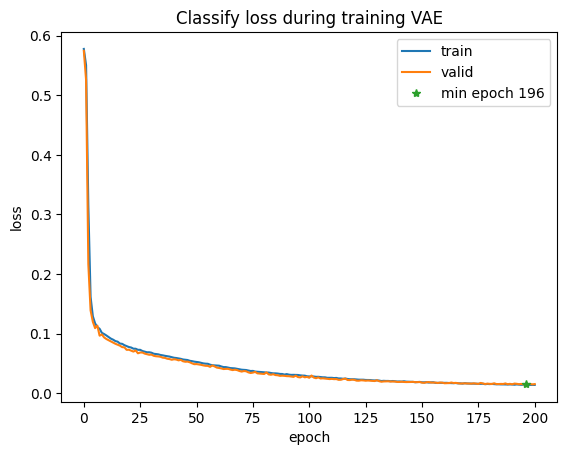

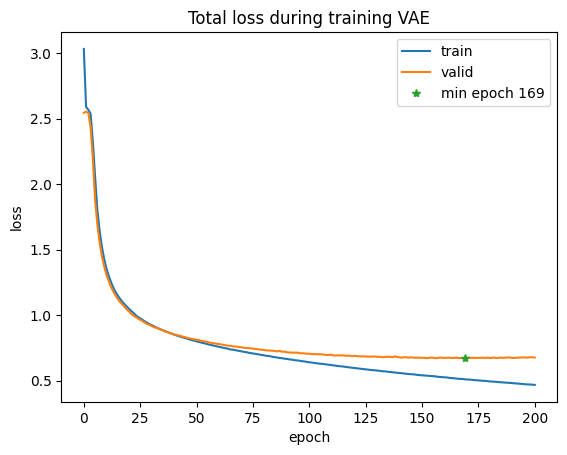

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.689  &0.727  &0.853  &0.494

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.878  &1.477  &1.215  &0.722

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.837  &0.500  &0.837  &1.000  &0.000  &0.912 &0.740 &  nan &0.924



Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:201 [Train] Loss: 0.467 | KL Div: 0.001 | Recon: 0.464 | Classify: 0.014 | KL w: 0.101 | cls w: 0.201


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.65it/s]


Epoch:201 [Valid] Loss: 0.677 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.015 | KL w: 0.101 | cls w: 0.201
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Epoch:202 [Train] Loss: 0.465 | KL Div: 0.001 | Recon: 0.463 | Classify: 0.014 | KL w: 0.101 | cls w: 0.202


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]


Epoch:202 [Valid] Loss: 0.676 | KL Div: 0.001 | Recon: 0.673 | Classify: 0.014 | KL w: 0.101 | cls w: 0.202
## SAVE Enc, Dec, Cls: classify loss: 0.015 -> 0.014  | runtime: 2.698 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:203 [Train] Loss: 0.465 | KL Div: 0.001 | Recon: 0.462 | Classify: 0.014 | KL w: 0.102 | cls w: 0.203


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]


Epoch:203 [Valid] Loss: 0.678 | KL Div: 0.001 | Recon: 0.675 | Classify: 0.015 | KL w: 0.102 | cls w: 0.203
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:204 [Train] Loss: 0.463 | KL Div: 0.001 | Recon: 0.461 | Classify: 0.013 | KL w: 0.102 | cls w: 0.204


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]


Epoch:204 [Valid] Loss: 0.676 | KL Div: 0.001 | Recon: 0.673 | Classify: 0.014 | KL w: 0.102 | cls w: 0.204
## SAVE Enc, Dec, Cls: classify loss: 0.014 -> 0.014  | runtime: 2.684 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:205 [Train] Loss: 0.462 | KL Div: 0.001 | Recon: 0.459 | Classify: 0.013 | KL w: 0.102 | cls w: 0.205


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.33it/s]


Epoch:205 [Valid] Loss: 0.680 | KL Div: 0.001 | Recon: 0.677 | Classify: 0.015 | KL w: 0.102 | cls w: 0.205
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:206 [Train] Loss: 0.461 | KL Div: 0.001 | Recon: 0.458 | Classify: 0.013 | KL w: 0.103 | cls w: 0.206


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.02it/s]


Epoch:206 [Valid] Loss: 0.679 | KL Div: 0.001 | Recon: 0.676 | Classify: 0.015 | KL w: 0.103 | cls w: 0.206
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:207 [Train] Loss: 0.460 | KL Div: 0.001 | Recon: 0.457 | Classify: 0.013 | KL w: 0.103 | cls w: 0.207


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.63it/s]


Epoch:207 [Valid] Loss: 0.682 | KL Div: 0.001 | Recon: 0.679 | Classify: 0.014 | KL w: 0.103 | cls w: 0.207
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:208 [Train] Loss: 0.459 | KL Div: 0.001 | Recon: 0.456 | Classify: 0.013 | KL w: 0.104 | cls w: 0.208


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]


Epoch:208 [Valid] Loss: 0.682 | KL Div: 0.001 | Recon: 0.679 | Classify: 0.016 | KL w: 0.104 | cls w: 0.208
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:209 [Train] Loss: 0.458 | KL Div: 0.001 | Recon: 0.455 | Classify: 0.014 | KL w: 0.104 | cls w: 0.209


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]


Epoch:209 [Valid] Loss: 0.680 | KL Div: 0.001 | Recon: 0.677 | Classify: 0.014 | KL w: 0.104 | cls w: 0.209
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Epoch:210 [Train] Loss: 0.456 | KL Div: 0.001 | Recon: 0.453 | Classify: 0.013 | KL w: 0.105 | cls w: 0.210


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


Epoch:210 [Valid] Loss: 0.679 | KL Div: 0.001 | Recon: 0.676 | Classify: 0.014 | KL w: 0.105 | cls w: 0.210
## SAVE Enc, Dec, Cls: classify loss: 0.014 -> 0.014  | runtime: 2.696 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:211 [Train] Loss: 0.455 | KL Div: 0.001 | Recon: 0.452 | Classify: 0.013 | KL w: 0.105 | cls w: 0.211


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]


Epoch:211 [Valid] Loss: 0.680 | KL Div: 0.001 | Recon: 0.678 | Classify: 0.014 | KL w: 0.105 | cls w: 0.211
## SAVE Enc, Dec, Cls: classify loss: 0.014 -> 0.014  | runtime: 2.686 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:212 [Train] Loss: 0.454 | KL Div: 0.001 | Recon: 0.451 | Classify: 0.013 | KL w: 0.106 | cls w: 0.212


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]


Epoch:212 [Valid] Loss: 0.685 | KL Div: 0.001 | Recon: 0.682 | Classify: 0.014 | KL w: 0.106 | cls w: 0.212
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Epoch:213 [Train] Loss: 0.452 | KL Div: 0.001 | Recon: 0.450 | Classify: 0.013 | KL w: 0.106 | cls w: 0.213


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]


Epoch:213 [Valid] Loss: 0.677 | KL Div: 0.001 | Recon: 0.674 | Classify: 0.014 | KL w: 0.106 | cls w: 0.213
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:214 [Train] Loss: 0.452 | KL Div: 0.001 | Recon: 0.449 | Classify: 0.013 | KL w: 0.107 | cls w: 0.214


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.94it/s]


Epoch:214 [Valid] Loss: 0.682 | KL Div: 0.001 | Recon: 0.679 | Classify: 0.014 | KL w: 0.107 | cls w: 0.214
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:215 [Train] Loss: 0.450 | KL Div: 0.001 | Recon: 0.448 | Classify: 0.013 | KL w: 0.107 | cls w: 0.215


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]


Epoch:215 [Valid] Loss: 0.684 | KL Div: 0.001 | Recon: 0.681 | Classify: 0.014 | KL w: 0.107 | cls w: 0.215
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:216 [Train] Loss: 0.449 | KL Div: 0.001 | Recon: 0.446 | Classify: 0.013 | KL w: 0.108 | cls w: 0.216


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Epoch:216 [Valid] Loss: 0.684 | KL Div: 0.001 | Recon: 0.681 | Classify: 0.014 | KL w: 0.108 | cls w: 0.216
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:217 [Train] Loss: 0.448 | KL Div: 0.001 | Recon: 0.445 | Classify: 0.013 | KL w: 0.108 | cls w: 0.217


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]


Epoch:217 [Valid] Loss: 0.682 | KL Div: 0.001 | Recon: 0.679 | Classify: 0.014 | KL w: 0.108 | cls w: 0.217
## SAVE Enc, Dec, Cls: classify loss: 0.014 -> 0.014  | runtime: 2.634 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s]


Epoch:218 [Train] Loss: 0.447 | KL Div: 0.001 | Recon: 0.444 | Classify: 0.013 | KL w: 0.109 | cls w: 0.218


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]


Epoch:218 [Valid] Loss: 0.680 | KL Div: 0.001 | Recon: 0.677 | Classify: 0.014 | KL w: 0.109 | cls w: 0.218
## SAVE Enc, Dec, Cls: classify loss: 0.014 -> 0.014  | runtime: 2.598 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:219 [Train] Loss: 0.446 | KL Div: 0.001 | Recon: 0.443 | Classify: 0.013 | KL w: 0.110 | cls w: 0.219


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]


Epoch:219 [Valid] Loss: 0.683 | KL Div: 0.001 | Recon: 0.680 | Classify: 0.014 | KL w: 0.110 | cls w: 0.219
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:220 [Train] Loss: 0.445 | KL Div: 0.001 | Recon: 0.442 | Classify: 0.013 | KL w: 0.110 | cls w: 0.220


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.13it/s]


Epoch:220 [Valid] Loss: 0.683 | KL Div: 0.001 | Recon: 0.680 | Classify: 0.014 | KL w: 0.110 | cls w: 0.220
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:221 [Train] Loss: 0.443 | KL Div: 0.001 | Recon: 0.441 | Classify: 0.012 | KL w: 0.111 | cls w: 0.221


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Epoch:221 [Valid] Loss: 0.682 | KL Div: 0.001 | Recon: 0.679 | Classify: 0.014 | KL w: 0.111 | cls w: 0.221
## SAVE Enc, Dec, Cls: classify loss: 0.014 -> 0.014  | runtime: 2.722 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:222 [Train] Loss: 0.443 | KL Div: 0.001 | Recon: 0.440 | Classify: 0.012 | KL w: 0.111 | cls w: 0.222


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]


Epoch:222 [Valid] Loss: 0.684 | KL Div: 0.001 | Recon: 0.681 | Classify: 0.014 | KL w: 0.111 | cls w: 0.222
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:223 [Train] Loss: 0.441 | KL Div: 0.001 | Recon: 0.438 | Classify: 0.012 | KL w: 0.112 | cls w: 0.223


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.19it/s]


Epoch:223 [Valid] Loss: 0.687 | KL Div: 0.001 | Recon: 0.683 | Classify: 0.015 | KL w: 0.112 | cls w: 0.223
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:224 [Train] Loss: 0.440 | KL Div: 0.001 | Recon: 0.437 | Classify: 0.012 | KL w: 0.112 | cls w: 0.224


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.00it/s]


Epoch:224 [Valid] Loss: 0.686 | KL Div: 0.001 | Recon: 0.682 | Classify: 0.014 | KL w: 0.112 | cls w: 0.224
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:225 [Train] Loss: 0.440 | KL Div: 0.001 | Recon: 0.437 | Classify: 0.012 | KL w: 0.113 | cls w: 0.225


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]


Epoch:225 [Valid] Loss: 0.689 | KL Div: 0.001 | Recon: 0.686 | Classify: 0.014 | KL w: 0.113 | cls w: 0.225
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Epoch:226 [Train] Loss: 0.438 | KL Div: 0.001 | Recon: 0.435 | Classify: 0.012 | KL w: 0.113 | cls w: 0.226


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.96it/s]


Epoch:226 [Valid] Loss: 0.681 | KL Div: 0.001 | Recon: 0.678 | Classify: 0.014 | KL w: 0.113 | cls w: 0.226
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:227 [Train] Loss: 0.437 | KL Div: 0.001 | Recon: 0.434 | Classify: 0.012 | KL w: 0.114 | cls w: 0.227


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]


Epoch:227 [Valid] Loss: 0.686 | KL Div: 0.001 | Recon: 0.683 | Classify: 0.015 | KL w: 0.114 | cls w: 0.227
EarlyStopping counter: 6 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:228 [Train] Loss: 0.436 | KL Div: 0.001 | Recon: 0.433 | Classify: 0.012 | KL w: 0.114 | cls w: 0.228


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]


Epoch:228 [Valid] Loss: 0.690 | KL Div: 0.001 | Recon: 0.687 | Classify: 0.013 | KL w: 0.114 | cls w: 0.228
## SAVE Enc, Dec, Cls: classify loss: 0.014 -> 0.013  | runtime: 2.666 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:229 [Train] Loss: 0.435 | KL Div: 0.001 | Recon: 0.432 | Classify: 0.012 | KL w: 0.115 | cls w: 0.229


Valid: 100%|██████████| 13/13 [00:02<00:00,  6.48it/s]


Epoch:229 [Valid] Loss: 0.686 | KL Div: 0.001 | Recon: 0.683 | Classify: 0.013 | KL w: 0.115 | cls w: 0.229
## SAVE Enc, Dec, Cls: classify loss: 0.013 -> 0.013  | runtime: 2.638 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:230 [Train] Loss: 0.434 | KL Div: 0.001 | Recon: 0.431 | Classify: 0.012 | KL w: 0.115 | cls w: 0.230


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]


Epoch:230 [Valid] Loss: 0.684 | KL Div: 0.001 | Recon: 0.681 | Classify: 0.013 | KL w: 0.115 | cls w: 0.230
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s]


Epoch:231 [Train] Loss: 0.433 | KL Div: 0.001 | Recon: 0.430 | Classify: 0.012 | KL w: 0.116 | cls w: 0.231


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]


Epoch:231 [Valid] Loss: 0.690 | KL Div: 0.001 | Recon: 0.687 | Classify: 0.013 | KL w: 0.116 | cls w: 0.231
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:232 [Train] Loss: 0.432 | KL Div: 0.001 | Recon: 0.429 | Classify: 0.012 | KL w: 0.116 | cls w: 0.232


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]


Epoch:232 [Valid] Loss: 0.686 | KL Div: 0.001 | Recon: 0.682 | Classify: 0.013 | KL w: 0.116 | cls w: 0.232
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:233 [Train] Loss: 0.431 | KL Div: 0.001 | Recon: 0.428 | Classify: 0.012 | KL w: 0.117 | cls w: 0.233


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.83it/s]


Epoch:233 [Valid] Loss: 0.691 | KL Div: 0.001 | Recon: 0.688 | Classify: 0.014 | KL w: 0.117 | cls w: 0.233
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:234 [Train] Loss: 0.430 | KL Div: 0.001 | Recon: 0.427 | Classify: 0.012 | KL w: 0.117 | cls w: 0.234


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.06it/s]


Epoch:234 [Valid] Loss: 0.692 | KL Div: 0.001 | Recon: 0.689 | Classify: 0.013 | KL w: 0.117 | cls w: 0.234
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Epoch:235 [Train] Loss: 0.429 | KL Div: 0.001 | Recon: 0.426 | Classify: 0.012 | KL w: 0.117 | cls w: 0.235


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.68it/s]


Epoch:235 [Valid] Loss: 0.686 | KL Div: 0.001 | Recon: 0.683 | Classify: 0.013 | KL w: 0.117 | cls w: 0.235
EarlyStopping counter: 6 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:236 [Train] Loss: 0.428 | KL Div: 0.001 | Recon: 0.425 | Classify: 0.012 | KL w: 0.118 | cls w: 0.236


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]


Epoch:236 [Valid] Loss: 0.690 | KL Div: 0.001 | Recon: 0.687 | Classify: 0.013 | KL w: 0.118 | cls w: 0.236
## SAVE Enc, Dec, Cls: classify loss: 0.013 -> 0.013  | runtime: 2.646 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:237 [Train] Loss: 0.427 | KL Div: 0.001 | Recon: 0.424 | Classify: 0.012 | KL w: 0.118 | cls w: 0.237


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]


Epoch:237 [Valid] Loss: 0.691 | KL Div: 0.001 | Recon: 0.688 | Classify: 0.013 | KL w: 0.118 | cls w: 0.237
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:238 [Train] Loss: 0.426 | KL Div: 0.001 | Recon: 0.423 | Classify: 0.012 | KL w: 0.119 | cls w: 0.238


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.09it/s]


Epoch:238 [Valid] Loss: 0.693 | KL Div: 0.001 | Recon: 0.690 | Classify: 0.013 | KL w: 0.119 | cls w: 0.238
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Epoch:239 [Train] Loss: 0.424 | KL Div: 0.001 | Recon: 0.421 | Classify: 0.012 | KL w: 0.119 | cls w: 0.239


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.53it/s]


Epoch:239 [Valid] Loss: 0.689 | KL Div: 0.001 | Recon: 0.686 | Classify: 0.013 | KL w: 0.119 | cls w: 0.239
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:240 [Train] Loss: 0.424 | KL Div: 0.001 | Recon: 0.421 | Classify: 0.011 | KL w: 0.120 | cls w: 0.240


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.98it/s]


Epoch:240 [Valid] Loss: 0.692 | KL Div: 0.001 | Recon: 0.688 | Classify: 0.013 | KL w: 0.120 | cls w: 0.240
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:241 [Train] Loss: 0.422 | KL Div: 0.001 | Recon: 0.420 | Classify: 0.011 | KL w: 0.120 | cls w: 0.241


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]


Epoch:241 [Valid] Loss: 0.695 | KL Div: 0.001 | Recon: 0.692 | Classify: 0.013 | KL w: 0.120 | cls w: 0.241
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:242 [Train] Loss: 0.422 | KL Div: 0.001 | Recon: 0.419 | Classify: 0.011 | KL w: 0.121 | cls w: 0.242


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.37it/s]


Epoch:242 [Valid] Loss: 0.692 | KL Div: 0.001 | Recon: 0.688 | Classify: 0.015 | KL w: 0.121 | cls w: 0.242
EarlyStopping counter: 6 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s]


Epoch:243 [Train] Loss: 0.420 | KL Div: 0.001 | Recon: 0.417 | Classify: 0.011 | KL w: 0.121 | cls w: 0.243


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


Epoch:243 [Valid] Loss: 0.694 | KL Div: 0.001 | Recon: 0.690 | Classify: 0.013 | KL w: 0.121 | cls w: 0.243
EarlyStopping counter: 7 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:244 [Train] Loss: 0.420 | KL Div: 0.001 | Recon: 0.417 | Classify: 0.011 | KL w: 0.122 | cls w: 0.244


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.24it/s]


Epoch:244 [Valid] Loss: 0.694 | KL Div: 0.001 | Recon: 0.690 | Classify: 0.013 | KL w: 0.122 | cls w: 0.244
EarlyStopping counter: 8 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Epoch:245 [Train] Loss: 0.419 | KL Div: 0.001 | Recon: 0.416 | Classify: 0.012 | KL w: 0.122 | cls w: 0.245


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.61it/s]


Epoch:245 [Valid] Loss: 0.695 | KL Div: 0.001 | Recon: 0.692 | Classify: 0.013 | KL w: 0.122 | cls w: 0.245
EarlyStopping counter: 9 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:246 [Train] Loss: 0.417 | KL Div: 0.001 | Recon: 0.414 | Classify: 0.011 | KL w: 0.123 | cls w: 0.246


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


Epoch:246 [Valid] Loss: 0.695 | KL Div: 0.001 | Recon: 0.691 | Classify: 0.013 | KL w: 0.123 | cls w: 0.246
EarlyStopping counter: 10 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:247 [Train] Loss: 0.416 | KL Div: 0.001 | Recon: 0.414 | Classify: 0.011 | KL w: 0.123 | cls w: 0.247


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.08it/s]


Epoch:247 [Valid] Loss: 0.701 | KL Div: 0.001 | Recon: 0.698 | Classify: 0.013 | KL w: 0.123 | cls w: 0.247
EarlyStopping counter: 11 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s]


Epoch:248 [Train] Loss: 0.416 | KL Div: 0.001 | Recon: 0.413 | Classify: 0.011 | KL w: 0.124 | cls w: 0.248


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Epoch:248 [Valid] Loss: 0.698 | KL Div: 0.001 | Recon: 0.695 | Classify: 0.013 | KL w: 0.124 | cls w: 0.248
EarlyStopping counter: 12 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Epoch:249 [Train] Loss: 0.415 | KL Div: 0.001 | Recon: 0.412 | Classify: 0.011 | KL w: 0.124 | cls w: 0.249


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.79it/s]


Epoch:249 [Valid] Loss: 0.695 | KL Div: 0.001 | Recon: 0.692 | Classify: 0.013 | KL w: 0.124 | cls w: 0.249
EarlyStopping counter: 13 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:250 [Train] Loss: 0.413 | KL Div: 0.001 | Recon: 0.410 | Classify: 0.011 | KL w: 0.125 | cls w: 0.250


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.38it/s]


Epoch:250 [Valid] Loss: 0.700 | KL Div: 0.001 | Recon: 0.697 | Classify: 0.013 | KL w: 0.125 | cls w: 0.250
EarlyStopping counter: 14 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:251 [Train] Loss: 0.412 | KL Div: 0.001 | Recon: 0.409 | Classify: 0.011 | KL w: 0.126 | cls w: 0.251


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.26it/s]


Epoch:251 [Valid] Loss: 0.698 | KL Div: 0.001 | Recon: 0.695 | Classify: 0.013 | KL w: 0.126 | cls w: 0.251
## SAVE Enc, Dec, Cls: classify loss: 0.013 -> 0.013  | runtime: 2.666 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:252 [Train] Loss: 0.411 | KL Div: 0.001 | Recon: 0.408 | Classify: 0.011 | KL w: 0.126 | cls w: 0.252


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]


Epoch:252 [Valid] Loss: 0.700 | KL Div: 0.001 | Recon: 0.697 | Classify: 0.013 | KL w: 0.126 | cls w: 0.252
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:253 [Train] Loss: 0.411 | KL Div: 0.001 | Recon: 0.408 | Classify: 0.011 | KL w: 0.127 | cls w: 0.253


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.27it/s]


Epoch:253 [Valid] Loss: 0.699 | KL Div: 0.001 | Recon: 0.696 | Classify: 0.013 | KL w: 0.127 | cls w: 0.253
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:254 [Train] Loss: 0.410 | KL Div: 0.001 | Recon: 0.408 | Classify: 0.011 | KL w: 0.127 | cls w: 0.254


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.97it/s]


Epoch:254 [Valid] Loss: 0.701 | KL Div: 0.001 | Recon: 0.698 | Classify: 0.012 | KL w: 0.127 | cls w: 0.254
## SAVE Enc, Dec, Cls: classify loss: 0.013 -> 0.012  | runtime: 2.679 ms


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:255 [Train] Loss: 0.410 | KL Div: 0.001 | Recon: 0.407 | Classify: 0.011 | KL w: 0.128 | cls w: 0.255


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]


Epoch:255 [Valid] Loss: 0.700 | KL Div: 0.001 | Recon: 0.697 | Classify: 0.012 | KL w: 0.128 | cls w: 0.255
## SAVE Enc, Dec, Cls: classify loss: 0.012 -> 0.012  | runtime: 2.647 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:256 [Train] Loss: 0.409 | KL Div: 0.001 | Recon: 0.406 | Classify: 0.011 | KL w: 0.128 | cls w: 0.256


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.31it/s]


Epoch:256 [Valid] Loss: 0.702 | KL Div: 0.001 | Recon: 0.699 | Classify: 0.012 | KL w: 0.128 | cls w: 0.256
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:257 [Train] Loss: 0.407 | KL Div: 0.001 | Recon: 0.404 | Classify: 0.011 | KL w: 0.129 | cls w: 0.257


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.98it/s]


Epoch:257 [Valid] Loss: 0.701 | KL Div: 0.001 | Recon: 0.697 | Classify: 0.013 | KL w: 0.129 | cls w: 0.257
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:258 [Train] Loss: 0.407 | KL Div: 0.001 | Recon: 0.404 | Classify: 0.011 | KL w: 0.129 | cls w: 0.258


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]


Epoch:258 [Valid] Loss: 0.701 | KL Div: 0.001 | Recon: 0.697 | Classify: 0.013 | KL w: 0.129 | cls w: 0.258
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:259 [Train] Loss: 0.406 | KL Div: 0.001 | Recon: 0.403 | Classify: 0.011 | KL w: 0.130 | cls w: 0.259


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Epoch:259 [Valid] Loss: 0.705 | KL Div: 0.001 | Recon: 0.701 | Classify: 0.014 | KL w: 0.130 | cls w: 0.259
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s]


Epoch:260 [Train] Loss: 0.404 | KL Div: 0.001 | Recon: 0.401 | Classify: 0.011 | KL w: 0.130 | cls w: 0.260


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]


Epoch:260 [Valid] Loss: 0.702 | KL Div: 0.001 | Recon: 0.698 | Classify: 0.013 | KL w: 0.130 | cls w: 0.260
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:261 [Train] Loss: 0.403 | KL Div: 0.001 | Recon: 0.401 | Classify: 0.011 | KL w: 0.131 | cls w: 0.261


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


Epoch:261 [Valid] Loss: 0.704 | KL Div: 0.001 | Recon: 0.700 | Classify: 0.014 | KL w: 0.131 | cls w: 0.261
EarlyStopping counter: 6 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.86it/s]


Epoch:262 [Train] Loss: 0.402 | KL Div: 0.001 | Recon: 0.400 | Classify: 0.011 | KL w: 0.131 | cls w: 0.262


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]


Epoch:262 [Valid] Loss: 0.704 | KL Div: 0.001 | Recon: 0.700 | Classify: 0.012 | KL w: 0.131 | cls w: 0.262
EarlyStopping counter: 7 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:263 [Train] Loss: 0.402 | KL Div: 0.001 | Recon: 0.399 | Classify: 0.010 | KL w: 0.132 | cls w: 0.263


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]


Epoch:263 [Valid] Loss: 0.706 | KL Div: 0.001 | Recon: 0.702 | Classify: 0.013 | KL w: 0.132 | cls w: 0.263
EarlyStopping counter: 8 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:264 [Train] Loss: 0.402 | KL Div: 0.001 | Recon: 0.399 | Classify: 0.011 | KL w: 0.132 | cls w: 0.264


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.76it/s]


Epoch:264 [Valid] Loss: 0.704 | KL Div: 0.001 | Recon: 0.701 | Classify: 0.013 | KL w: 0.132 | cls w: 0.264
EarlyStopping counter: 9 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:265 [Train] Loss: 0.401 | KL Div: 0.001 | Recon: 0.398 | Classify: 0.011 | KL w: 0.133 | cls w: 0.265


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]


Epoch:265 [Valid] Loss: 0.706 | KL Div: 0.001 | Recon: 0.702 | Classify: 0.012 | KL w: 0.133 | cls w: 0.265
## SAVE Enc, Dec, Cls: classify loss: 0.012 -> 0.012  | runtime: 2.671 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:266 [Train] Loss: 0.400 | KL Div: 0.001 | Recon: 0.397 | Classify: 0.010 | KL w: 0.133 | cls w: 0.266


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]


Epoch:266 [Valid] Loss: 0.704 | KL Div: 0.001 | Recon: 0.701 | Classify: 0.012 | KL w: 0.133 | cls w: 0.266
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:267 [Train] Loss: 0.399 | KL Div: 0.001 | Recon: 0.396 | Classify: 0.010 | KL w: 0.134 | cls w: 0.267


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.18it/s]


Epoch:267 [Valid] Loss: 0.703 | KL Div: 0.001 | Recon: 0.700 | Classify: 0.013 | KL w: 0.134 | cls w: 0.267
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:28<00:00,  3.04it/s]


Epoch:268 [Train] Loss: 0.398 | KL Div: 0.001 | Recon: 0.395 | Classify: 0.011 | KL w: 0.134 | cls w: 0.268


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


Epoch:268 [Valid] Loss: 0.709 | KL Div: 0.001 | Recon: 0.705 | Classify: 0.013 | KL w: 0.134 | cls w: 0.268
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:269 [Train] Loss: 0.397 | KL Div: 0.001 | Recon: 0.394 | Classify: 0.010 | KL w: 0.135 | cls w: 0.269


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.57it/s]


Epoch:269 [Valid] Loss: 0.706 | KL Div: 0.001 | Recon: 0.702 | Classify: 0.014 | KL w: 0.135 | cls w: 0.269
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Epoch:270 [Train] Loss: 0.395 | KL Div: 0.001 | Recon: 0.392 | Classify: 0.010 | KL w: 0.135 | cls w: 0.270


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epoch:270 [Valid] Loss: 0.709 | KL Div: 0.001 | Recon: 0.706 | Classify: 0.012 | KL w: 0.135 | cls w: 0.270
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:271 [Train] Loss: 0.396 | KL Div: 0.001 | Recon: 0.393 | Classify: 0.010 | KL w: 0.136 | cls w: 0.271


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]


Epoch:271 [Valid] Loss: 0.711 | KL Div: 0.001 | Recon: 0.707 | Classify: 0.013 | KL w: 0.136 | cls w: 0.271
EarlyStopping counter: 6 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:272 [Train] Loss: 0.394 | KL Div: 0.001 | Recon: 0.391 | Classify: 0.010 | KL w: 0.136 | cls w: 0.272


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.32it/s]


Epoch:272 [Valid] Loss: 0.711 | KL Div: 0.001 | Recon: 0.707 | Classify: 0.013 | KL w: 0.136 | cls w: 0.272
EarlyStopping counter: 7 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:273 [Train] Loss: 0.394 | KL Div: 0.001 | Recon: 0.391 | Classify: 0.010 | KL w: 0.137 | cls w: 0.273


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.12it/s]


Epoch:273 [Valid] Loss: 0.707 | KL Div: 0.001 | Recon: 0.703 | Classify: 0.012 | KL w: 0.137 | cls w: 0.273
## SAVE Enc, Dec, Cls: classify loss: 0.012 -> 0.012  | runtime: 2.665 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:274 [Train] Loss: 0.393 | KL Div: 0.001 | Recon: 0.390 | Classify: 0.010 | KL w: 0.137 | cls w: 0.274


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.17it/s]


Epoch:274 [Valid] Loss: 0.708 | KL Div: 0.001 | Recon: 0.704 | Classify: 0.012 | KL w: 0.137 | cls w: 0.274
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:275 [Train] Loss: 0.392 | KL Div: 0.001 | Recon: 0.389 | Classify: 0.010 | KL w: 0.138 | cls w: 0.275


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


Epoch:275 [Valid] Loss: 0.709 | KL Div: 0.001 | Recon: 0.706 | Classify: 0.012 | KL w: 0.138 | cls w: 0.275
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:276 [Train] Loss: 0.391 | KL Div: 0.001 | Recon: 0.388 | Classify: 0.010 | KL w: 0.138 | cls w: 0.276


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.70it/s]


Epoch:276 [Valid] Loss: 0.708 | KL Div: 0.001 | Recon: 0.704 | Classify: 0.012 | KL w: 0.138 | cls w: 0.276
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:277 [Train] Loss: 0.389 | KL Div: 0.001 | Recon: 0.386 | Classify: 0.010 | KL w: 0.139 | cls w: 0.277


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Epoch:277 [Valid] Loss: 0.714 | KL Div: 0.001 | Recon: 0.710 | Classify: 0.013 | KL w: 0.139 | cls w: 0.277
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:278 [Train] Loss: 0.389 | KL Div: 0.001 | Recon: 0.387 | Classify: 0.010 | KL w: 0.139 | cls w: 0.278


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


Epoch:278 [Valid] Loss: 0.715 | KL Div: 0.001 | Recon: 0.712 | Classify: 0.013 | KL w: 0.139 | cls w: 0.278
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:279 [Train] Loss: 0.389 | KL Div: 0.001 | Recon: 0.386 | Classify: 0.010 | KL w: 0.140 | cls w: 0.279


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.71it/s]


Epoch:279 [Valid] Loss: 0.713 | KL Div: 0.001 | Recon: 0.709 | Classify: 0.012 | KL w: 0.140 | cls w: 0.279
EarlyStopping counter: 6 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:280 [Train] Loss: 0.388 | KL Div: 0.001 | Recon: 0.385 | Classify: 0.010 | KL w: 0.140 | cls w: 0.280


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.89it/s]


Epoch:280 [Valid] Loss: 0.714 | KL Div: 0.001 | Recon: 0.710 | Classify: 0.012 | KL w: 0.140 | cls w: 0.280
## SAVE Enc, Dec, Cls: classify loss: 0.012 -> 0.012  | runtime: 2.685 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:281 [Train] Loss: 0.388 | KL Div: 0.001 | Recon: 0.385 | Classify: 0.010 | KL w: 0.141 | cls w: 0.281


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.15it/s]


Epoch:281 [Valid] Loss: 0.713 | KL Div: 0.001 | Recon: 0.709 | Classify: 0.013 | KL w: 0.141 | cls w: 0.281
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:282 [Train] Loss: 0.387 | KL Div: 0.001 | Recon: 0.384 | Classify: 0.010 | KL w: 0.141 | cls w: 0.282


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.31it/s]


Epoch:282 [Valid] Loss: 0.711 | KL Div: 0.001 | Recon: 0.708 | Classify: 0.013 | KL w: 0.141 | cls w: 0.282
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:283 [Train] Loss: 0.386 | KL Div: 0.001 | Recon: 0.383 | Classify: 0.010 | KL w: 0.141 | cls w: 0.283


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]


Epoch:283 [Valid] Loss: 0.715 | KL Div: 0.001 | Recon: 0.712 | Classify: 0.013 | KL w: 0.141 | cls w: 0.283
EarlyStopping counter: 3 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.01it/s]


Epoch:284 [Train] Loss: 0.385 | KL Div: 0.001 | Recon: 0.382 | Classify: 0.010 | KL w: 0.142 | cls w: 0.284


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.81it/s]


Epoch:284 [Valid] Loss: 0.714 | KL Div: 0.001 | Recon: 0.711 | Classify: 0.013 | KL w: 0.142 | cls w: 0.284
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:285 [Train] Loss: 0.383 | KL Div: 0.001 | Recon: 0.381 | Classify: 0.010 | KL w: 0.142 | cls w: 0.285


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.92it/s]


Epoch:285 [Valid] Loss: 0.714 | KL Div: 0.001 | Recon: 0.710 | Classify: 0.013 | KL w: 0.142 | cls w: 0.285
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:286 [Train] Loss: 0.384 | KL Div: 0.001 | Recon: 0.381 | Classify: 0.010 | KL w: 0.143 | cls w: 0.286


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.87it/s]


Epoch:286 [Valid] Loss: 0.714 | KL Div: 0.001 | Recon: 0.710 | Classify: 0.012 | KL w: 0.143 | cls w: 0.286
EarlyStopping counter: 6 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:287 [Train] Loss: 0.382 | KL Div: 0.001 | Recon: 0.380 | Classify: 0.010 | KL w: 0.143 | cls w: 0.287


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.93it/s]


Epoch:287 [Valid] Loss: 0.718 | KL Div: 0.001 | Recon: 0.715 | Classify: 0.012 | KL w: 0.143 | cls w: 0.287
EarlyStopping counter: 7 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Epoch:288 [Train] Loss: 0.382 | KL Div: 0.001 | Recon: 0.379 | Classify: 0.009 | KL w: 0.144 | cls w: 0.288


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]


Epoch:288 [Valid] Loss: 0.721 | KL Div: 0.001 | Recon: 0.717 | Classify: 0.012 | KL w: 0.144 | cls w: 0.288
EarlyStopping counter: 8 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:289 [Train] Loss: 0.381 | KL Div: 0.001 | Recon: 0.378 | Classify: 0.009 | KL w: 0.144 | cls w: 0.289


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.84it/s]


Epoch:289 [Valid] Loss: 0.717 | KL Div: 0.001 | Recon: 0.714 | Classify: 0.012 | KL w: 0.144 | cls w: 0.289
EarlyStopping counter: 9 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:290 [Train] Loss: 0.380 | KL Div: 0.001 | Recon: 0.377 | Classify: 0.009 | KL w: 0.145 | cls w: 0.290


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.56it/s]


Epoch:290 [Valid] Loss: 0.717 | KL Div: 0.001 | Recon: 0.714 | Classify: 0.012 | KL w: 0.145 | cls w: 0.290
EarlyStopping counter: 10 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:291 [Train] Loss: 0.380 | KL Div: 0.001 | Recon: 0.377 | Classify: 0.009 | KL w: 0.145 | cls w: 0.291


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.58it/s]


Epoch:291 [Valid] Loss: 0.719 | KL Div: 0.001 | Recon: 0.715 | Classify: 0.012 | KL w: 0.145 | cls w: 0.291
EarlyStopping counter: 11 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.03it/s]


Epoch:292 [Train] Loss: 0.379 | KL Div: 0.001 | Recon: 0.376 | Classify: 0.009 | KL w: 0.146 | cls w: 0.292


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.56it/s]


Epoch:292 [Valid] Loss: 0.723 | KL Div: 0.001 | Recon: 0.719 | Classify: 0.012 | KL w: 0.146 | cls w: 0.292
EarlyStopping counter: 12 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:293 [Train] Loss: 0.378 | KL Div: 0.001 | Recon: 0.375 | Classify: 0.010 | KL w: 0.146 | cls w: 0.293


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]


Epoch:293 [Valid] Loss: 0.718 | KL Div: 0.001 | Recon: 0.714 | Classify: 0.012 | KL w: 0.146 | cls w: 0.293
EarlyStopping counter: 13 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:294 [Train] Loss: 0.378 | KL Div: 0.001 | Recon: 0.375 | Classify: 0.009 | KL w: 0.147 | cls w: 0.294


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.85it/s]


Epoch:294 [Valid] Loss: 0.721 | KL Div: 0.001 | Recon: 0.717 | Classify: 0.012 | KL w: 0.147 | cls w: 0.294
EarlyStopping counter: 14 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:295 [Train] Loss: 0.377 | KL Div: 0.001 | Recon: 0.374 | Classify: 0.009 | KL w: 0.147 | cls w: 0.295


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.60it/s]


Epoch:295 [Valid] Loss: 0.723 | KL Div: 0.001 | Recon: 0.719 | Classify: 0.013 | KL w: 0.147 | cls w: 0.295
EarlyStopping counter: 15 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:296 [Train] Loss: 0.376 | KL Div: 0.001 | Recon: 0.373 | Classify: 0.009 | KL w: 0.148 | cls w: 0.296


Valid: 100%|██████████| 13/13 [00:02<00:00,  6.40it/s]


Epoch:296 [Valid] Loss: 0.722 | KL Div: 0.001 | Recon: 0.718 | Classify: 0.012 | KL w: 0.148 | cls w: 0.296
EarlyStopping counter: 16 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:297 [Train] Loss: 0.375 | KL Div: 0.001 | Recon: 0.372 | Classify: 0.009 | KL w: 0.148 | cls w: 0.297


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.86it/s]


Epoch:297 [Valid] Loss: 0.722 | KL Div: 0.001 | Recon: 0.718 | Classify: 0.012 | KL w: 0.148 | cls w: 0.297
## SAVE Enc, Dec, Cls: classify loss: 0.012 -> 0.012  | runtime: 2.653 ms


Train: 100%|██████████| 88/88 [00:30<00:00,  2.90it/s]


Epoch:298 [Train] Loss: 0.375 | KL Div: 0.001 | Recon: 0.372 | Classify: 0.009 | KL w: 0.149 | cls w: 0.298


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]


Epoch:298 [Valid] Loss: 0.720 | KL Div: 0.001 | Recon: 0.716 | Classify: 0.012 | KL w: 0.149 | cls w: 0.298
EarlyStopping counter: 1 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Epoch:299 [Train] Loss: 0.374 | KL Div: 0.001 | Recon: 0.371 | Classify: 0.009 | KL w: 0.149 | cls w: 0.299


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]


Epoch:299 [Valid] Loss: 0.724 | KL Div: 0.001 | Recon: 0.721 | Classify: 0.012 | KL w: 0.149 | cls w: 0.299
EarlyStopping counter: 2 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:300 [Train] Loss: 0.373 | KL Div: 0.001 | Recon: 0.370 | Classify: 0.009 | KL w: 0.150 | cls w: 0.300


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.94it/s]


Epoch:300 [Valid] Loss: 0.721 | KL Div: 0.001 | Recon: 0.717 | Classify: 0.012 | KL w: 0.150 | cls w: 0.300
EarlyStopping counter: 3 out of 30
Train time: 2.669+/-0.035 ms
different task weight ['0.287', '0.703', '0.010']


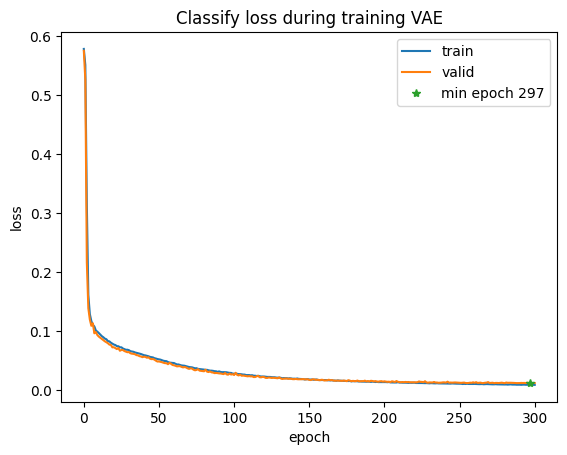

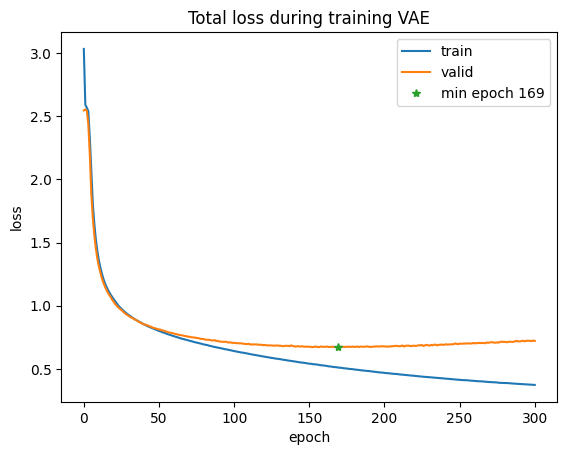

*************** Lipophilicity_AstraZeneca ***************
  MAE     MSE     RMSE    R2
&0.595  &0.590  &0.768  &0.590

*************** Solubility_AqSolDB ***************
  MAE     MSE     RMSE    R2
&0.764  &1.198  &1.095  &0.774

*************** PAMPA_NCATS ***************
  Acc,  w_acc,   prec,  recall,   SP,     F1,    AUC,   MCC,   AP
&0.837  &0.524  &0.844  &0.988  &0.061  &0.911 &0.731 &0.130 &0.887



Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:301 [Train] Loss: 0.373 | KL Div: 0.001 | Recon: 0.370 | Classify: 0.009 | KL w: 0.150 | cls w: 0.301


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.66it/s]


Epoch:301 [Valid] Loss: 0.724 | KL Div: 0.001 | Recon: 0.720 | Classify: 0.013 | KL w: 0.150 | cls w: 0.301
EarlyStopping counter: 4 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.95it/s]


Epoch:302 [Train] Loss: 0.372 | KL Div: 0.001 | Recon: 0.369 | Classify: 0.009 | KL w: 0.151 | cls w: 0.302


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.69it/s]


Epoch:302 [Valid] Loss: 0.728 | KL Div: 0.001 | Recon: 0.724 | Classify: 0.012 | KL w: 0.151 | cls w: 0.302
EarlyStopping counter: 5 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.88it/s]


Epoch:303 [Train] Loss: 0.372 | KL Div: 0.001 | Recon: 0.369 | Classify: 0.009 | KL w: 0.151 | cls w: 0.303


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]


Epoch:303 [Valid] Loss: 0.728 | KL Div: 0.001 | Recon: 0.724 | Classify: 0.013 | KL w: 0.151 | cls w: 0.303
EarlyStopping counter: 6 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s]


Epoch:304 [Train] Loss: 0.371 | KL Div: 0.001 | Recon: 0.368 | Classify: 0.009 | KL w: 0.152 | cls w: 0.304


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.72it/s]


Epoch:304 [Valid] Loss: 0.727 | KL Div: 0.001 | Recon: 0.723 | Classify: 0.013 | KL w: 0.152 | cls w: 0.304
EarlyStopping counter: 7 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Epoch:305 [Train] Loss: 0.371 | KL Div: 0.001 | Recon: 0.368 | Classify: 0.009 | KL w: 0.152 | cls w: 0.305


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.91it/s]


Epoch:305 [Valid] Loss: 0.727 | KL Div: 0.001 | Recon: 0.723 | Classify: 0.013 | KL w: 0.152 | cls w: 0.305
EarlyStopping counter: 8 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.93it/s]


Epoch:306 [Train] Loss: 0.369 | KL Div: 0.001 | Recon: 0.366 | Classify: 0.009 | KL w: 0.153 | cls w: 0.306


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.64it/s]


Epoch:306 [Valid] Loss: 0.732 | KL Div: 0.001 | Recon: 0.728 | Classify: 0.014 | KL w: 0.153 | cls w: 0.306
EarlyStopping counter: 9 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:307 [Train] Loss: 0.368 | KL Div: 0.001 | Recon: 0.365 | Classify: 0.009 | KL w: 0.153 | cls w: 0.307


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.90it/s]


Epoch:307 [Valid] Loss: 0.733 | KL Div: 0.001 | Recon: 0.729 | Classify: 0.013 | KL w: 0.153 | cls w: 0.307
EarlyStopping counter: 10 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:308 [Train] Loss: 0.368 | KL Div: 0.001 | Recon: 0.365 | Classify: 0.009 | KL w: 0.154 | cls w: 0.308


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.82it/s]


Epoch:308 [Valid] Loss: 0.730 | KL Div: 0.001 | Recon: 0.726 | Classify: 0.013 | KL w: 0.154 | cls w: 0.308
EarlyStopping counter: 11 out of 30


Train: 100%|██████████| 88/88 [00:31<00:00,  2.84it/s]


Epoch:309 [Train] Loss: 0.367 | KL Div: 0.001 | Recon: 0.364 | Classify: 0.009 | KL w: 0.154 | cls w: 0.309


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]


Epoch:309 [Valid] Loss: 0.728 | KL Div: 0.001 | Recon: 0.724 | Classify: 0.013 | KL w: 0.154 | cls w: 0.309
EarlyStopping counter: 12 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  3.00it/s]


Epoch:310 [Train] Loss: 0.366 | KL Div: 0.001 | Recon: 0.363 | Classify: 0.009 | KL w: 0.155 | cls w: 0.310


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]


Epoch:310 [Valid] Loss: 0.731 | KL Div: 0.001 | Recon: 0.727 | Classify: 0.012 | KL w: 0.155 | cls w: 0.310
EarlyStopping counter: 13 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:311 [Train] Loss: 0.366 | KL Div: 0.001 | Recon: 0.363 | Classify: 0.009 | KL w: 0.155 | cls w: 0.311


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.39it/s]


Epoch:311 [Valid] Loss: 0.729 | KL Div: 0.001 | Recon: 0.725 | Classify: 0.013 | KL w: 0.155 | cls w: 0.311
EarlyStopping counter: 14 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:312 [Train] Loss: 0.365 | KL Div: 0.001 | Recon: 0.362 | Classify: 0.009 | KL w: 0.156 | cls w: 0.312


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.78it/s]


Epoch:312 [Valid] Loss: 0.733 | KL Div: 0.001 | Recon: 0.728 | Classify: 0.013 | KL w: 0.156 | cls w: 0.312
EarlyStopping counter: 15 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:313 [Train] Loss: 0.364 | KL Div: 0.001 | Recon: 0.361 | Classify: 0.009 | KL w: 0.157 | cls w: 0.313


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]


Epoch:313 [Valid] Loss: 0.732 | KL Div: 0.001 | Recon: 0.728 | Classify: 0.012 | KL w: 0.157 | cls w: 0.313
EarlyStopping counter: 16 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:314 [Train] Loss: 0.364 | KL Div: 0.001 | Recon: 0.361 | Classify: 0.009 | KL w: 0.157 | cls w: 0.314


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.95it/s]


Epoch:314 [Valid] Loss: 0.735 | KL Div: 0.001 | Recon: 0.731 | Classify: 0.013 | KL w: 0.157 | cls w: 0.314
EarlyStopping counter: 17 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:315 [Train] Loss: 0.364 | KL Div: 0.001 | Recon: 0.361 | Classify: 0.009 | KL w: 0.158 | cls w: 0.315


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.88it/s]


Epoch:315 [Valid] Loss: 0.739 | KL Div: 0.001 | Recon: 0.735 | Classify: 0.012 | KL w: 0.158 | cls w: 0.315
EarlyStopping counter: 18 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.93it/s]


Epoch:316 [Train] Loss: 0.363 | KL Div: 0.001 | Recon: 0.360 | Classify: 0.009 | KL w: 0.158 | cls w: 0.316


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.07it/s]


Epoch:316 [Valid] Loss: 0.729 | KL Div: 0.001 | Recon: 0.725 | Classify: 0.013 | KL w: 0.158 | cls w: 0.316
EarlyStopping counter: 19 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:317 [Train] Loss: 0.362 | KL Div: 0.001 | Recon: 0.359 | Classify: 0.009 | KL w: 0.159 | cls w: 0.317


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.75it/s]


Epoch:317 [Valid] Loss: 0.733 | KL Div: 0.001 | Recon: 0.729 | Classify: 0.012 | KL w: 0.159 | cls w: 0.317
EarlyStopping counter: 20 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:318 [Train] Loss: 0.361 | KL Div: 0.001 | Recon: 0.358 | Classify: 0.009 | KL w: 0.159 | cls w: 0.318


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.10it/s]


Epoch:318 [Valid] Loss: 0.735 | KL Div: 0.001 | Recon: 0.731 | Classify: 0.013 | KL w: 0.159 | cls w: 0.318
EarlyStopping counter: 21 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.91it/s]


Epoch:319 [Train] Loss: 0.361 | KL Div: 0.001 | Recon: 0.358 | Classify: 0.009 | KL w: 0.160 | cls w: 0.319


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.87it/s]


Epoch:319 [Valid] Loss: 0.738 | KL Div: 0.001 | Recon: 0.734 | Classify: 0.013 | KL w: 0.160 | cls w: 0.319
EarlyStopping counter: 22 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.98it/s]


Epoch:320 [Train] Loss: 0.360 | KL Div: 0.001 | Recon: 0.358 | Classify: 0.009 | KL w: 0.160 | cls w: 0.320


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]


Epoch:320 [Valid] Loss: 0.739 | KL Div: 0.001 | Recon: 0.735 | Classify: 0.013 | KL w: 0.160 | cls w: 0.320
EarlyStopping counter: 23 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.99it/s]


Epoch:321 [Train] Loss: 0.360 | KL Div: 0.001 | Recon: 0.357 | Classify: 0.009 | KL w: 0.161 | cls w: 0.321


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.83it/s]


Epoch:321 [Valid] Loss: 0.742 | KL Div: 0.001 | Recon: 0.737 | Classify: 0.013 | KL w: 0.161 | cls w: 0.321
EarlyStopping counter: 24 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:322 [Train] Loss: 0.360 | KL Div: 0.001 | Recon: 0.357 | Classify: 0.009 | KL w: 0.161 | cls w: 0.322


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.01it/s]


Epoch:322 [Valid] Loss: 0.737 | KL Div: 0.001 | Recon: 0.733 | Classify: 0.013 | KL w: 0.161 | cls w: 0.322
EarlyStopping counter: 25 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.94it/s]


Epoch:323 [Train] Loss: 0.358 | KL Div: 0.001 | Recon: 0.356 | Classify: 0.008 | KL w: 0.162 | cls w: 0.323


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.05it/s]


Epoch:323 [Valid] Loss: 0.739 | KL Div: 0.001 | Recon: 0.735 | Classify: 0.013 | KL w: 0.162 | cls w: 0.323
EarlyStopping counter: 26 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.97it/s]


Epoch:324 [Train] Loss: 0.358 | KL Div: 0.001 | Recon: 0.355 | Classify: 0.009 | KL w: 0.162 | cls w: 0.324


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.74it/s]


Epoch:324 [Valid] Loss: 0.737 | KL Div: 0.001 | Recon: 0.733 | Classify: 0.012 | KL w: 0.162 | cls w: 0.324
EarlyStopping counter: 27 out of 30


Train: 100%|██████████| 88/88 [00:29<00:00,  2.96it/s]


Epoch:325 [Train] Loss: 0.357 | KL Div: 0.001 | Recon: 0.354 | Classify: 0.009 | KL w: 0.163 | cls w: 0.325


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.11it/s]


Epoch:325 [Valid] Loss: 0.741 | KL Div: 0.001 | Recon: 0.737 | Classify: 0.013 | KL w: 0.163 | cls w: 0.325
EarlyStopping counter: 28 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.89it/s]


Epoch:326 [Train] Loss: 0.356 | KL Div: 0.001 | Recon: 0.353 | Classify: 0.008 | KL w: 0.163 | cls w: 0.326


Valid: 100%|██████████| 13/13 [00:01<00:00,  7.23it/s]


Epoch:326 [Valid] Loss: 0.745 | KL Div: 0.001 | Recon: 0.741 | Classify: 0.013 | KL w: 0.163 | cls w: 0.326
EarlyStopping counter: 29 out of 30


Train: 100%|██████████| 88/88 [00:30<00:00,  2.92it/s]


Epoch:327 [Train] Loss: 0.357 | KL Div: 0.001 | Recon: 0.354 | Classify: 0.008 | KL w: 0.164 | cls w: 0.327


Valid: 100%|██████████| 13/13 [00:01<00:00,  6.79it/s]


Epoch:327 [Valid] Loss: 0.743 | KL Div: 0.001 | Recon: 0.738 | Classify: 0.013 | KL w: 0.164 | cls w: 0.327
EarlyStopping counter: 30 out of 30
early stop
Finished training


--> Train status saved at A3/uw/VAE_MT_0.yml
Model parameters:  7889033
Train time: 2.669+/-0.035 ms
best epoch: 169, min loss: 0.0118


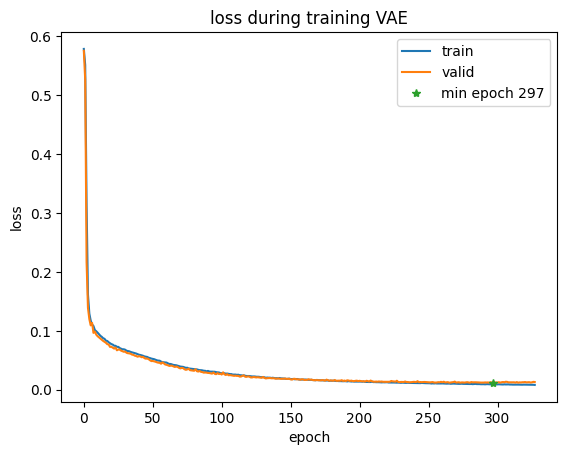

NameError: name 'train_cls' is not defined

In [ ]:
from scripts.TRAIN import *
for model_type in model_types:
    p = train_mt(A3, model_type, 'A3/uw', repeat_time=3, retrain=False, uw=True)